In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import warnings 
import itertools
import random
import copy
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [2]:
path =  "/kaggle/input/optiver-trading-at-the-close"
df = pd.read_csv(os.path.join(path,'train.csv'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [1]:
df.shape

NameError: name 'df' is not defined

In [4]:
df.nunique()

stock_id                       200
date_id                        481
seconds_in_bucket               55
imbalance_size             2971863
imbalance_buy_sell_flag          3
reference_price              28741
matched_size               2948862
far_price                    95739
near_price                   84625
bid_price                    28313
bid_size                   2591773
ask_price                    28266
ask_size                   2623254
wap                          31506
target                       15934
time_id                      26455
row_id                     5237980
dtype: int64

In [3]:
df.loc[:,'cat_Bool_target'] = df.target.apply(lambda x: 0 if x ==0 else -1 if x<0 else 1)
mean = np.nanmean(df.target.values)
std = np.nanstd(df.target.values)
df.loc[:,'std_target'] = df.target.apply(lambda x: (x-mean) / std)
df.loc[:, 'std_bool_target'] = df.std_target.apply(lambda x: 0 if np.abs(x) > 3 else 1)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 20 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
 17  cat_Bool_target          int64  
 18  std_target               float64
 19  std_bool_target          int64  
dtypes: float64(12), int64(7), object(1)
memory usa

    According to z-score there is no outliers

In [4]:
float_cols = [c for c in df.columns if df[c].dtypes == 'float64' and c not in  ['target','cat_Bool_target','std_target','std_bool_target']]
int_cols = [c for c in df.columns if df[c].dtypes == 'int64'  and c not in  ['cat_Bool_target','std_bool_target']]

In [9]:
###df[int_cols].hist(figsize = (15,20),  bins = 100, xlabelsize = 8 , ylabelsize = 8);
###df[float_cols].hist(figsize = (15,20), bins = 100, xlabelsize = 8 , ylabelsize = 8,log = True);

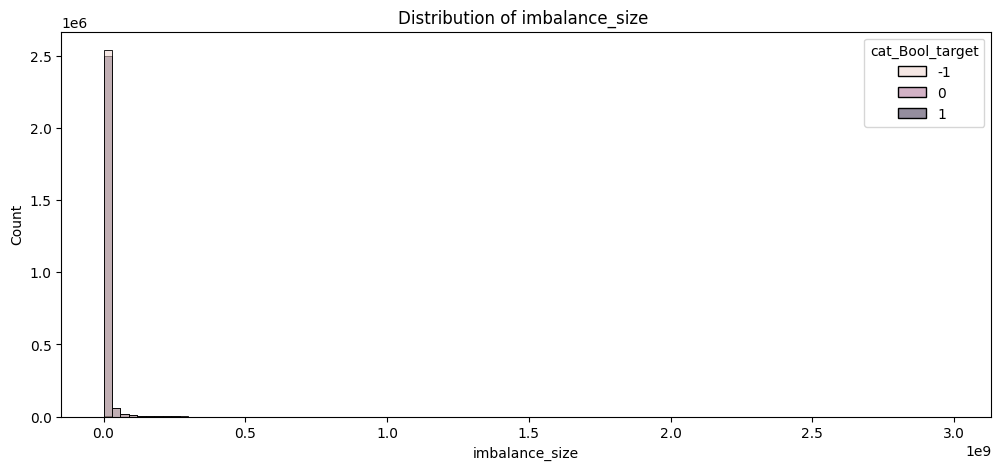

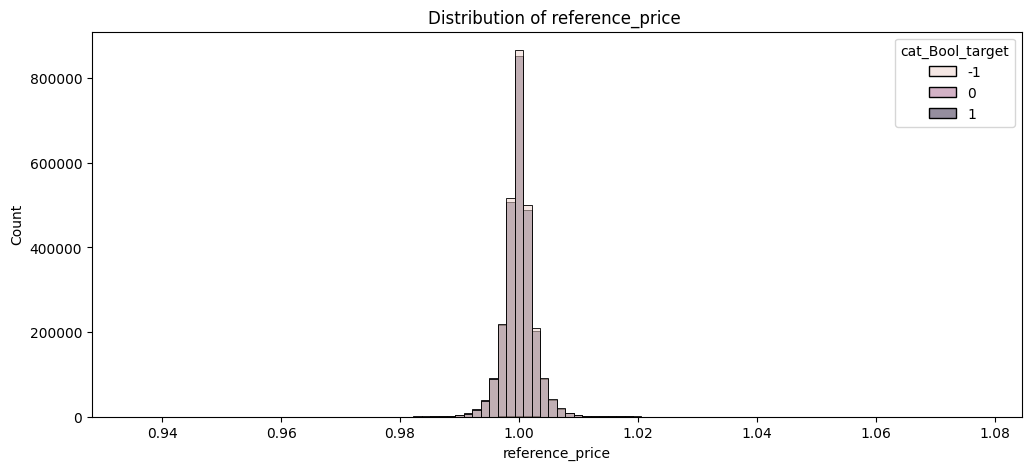

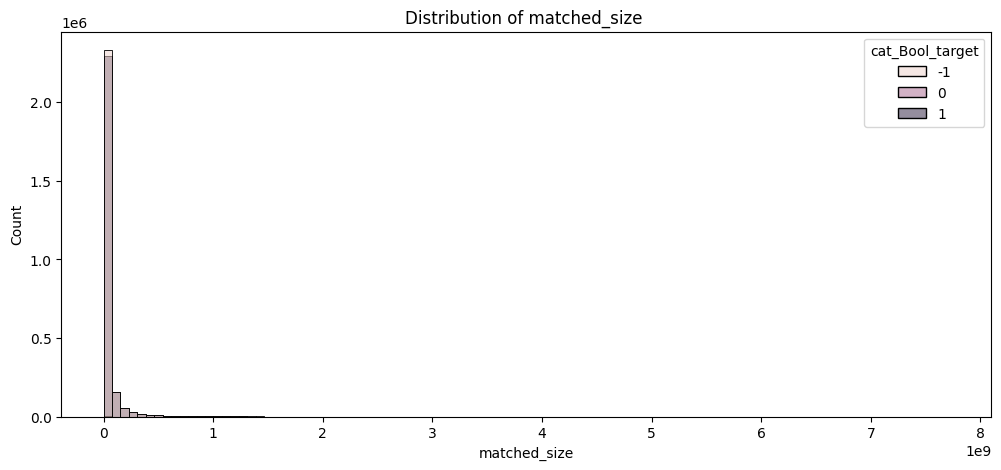

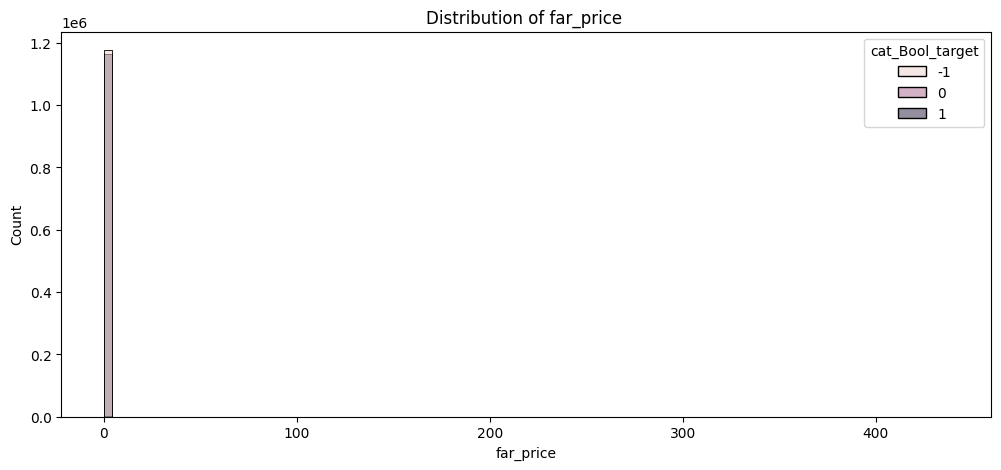

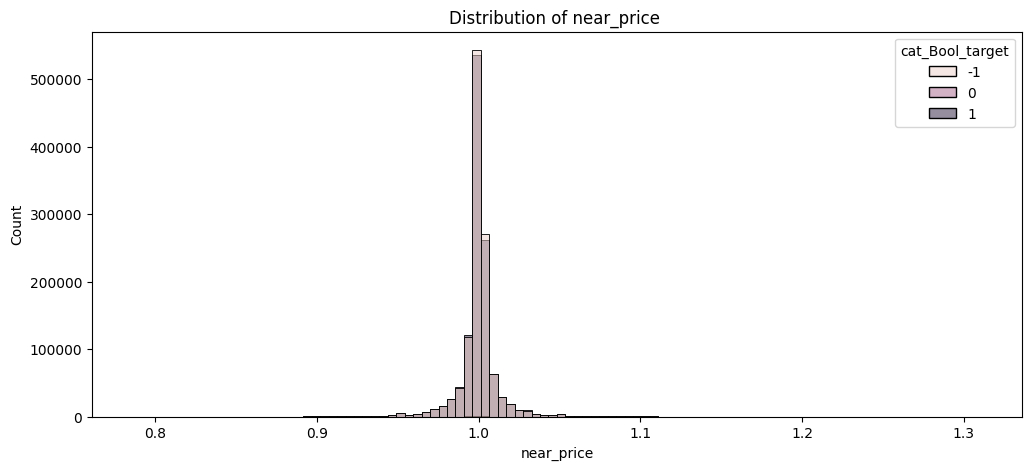

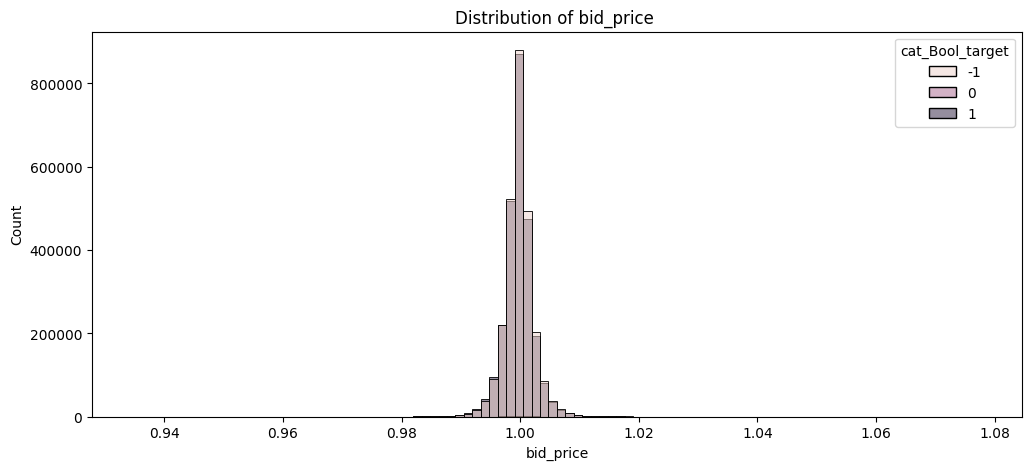

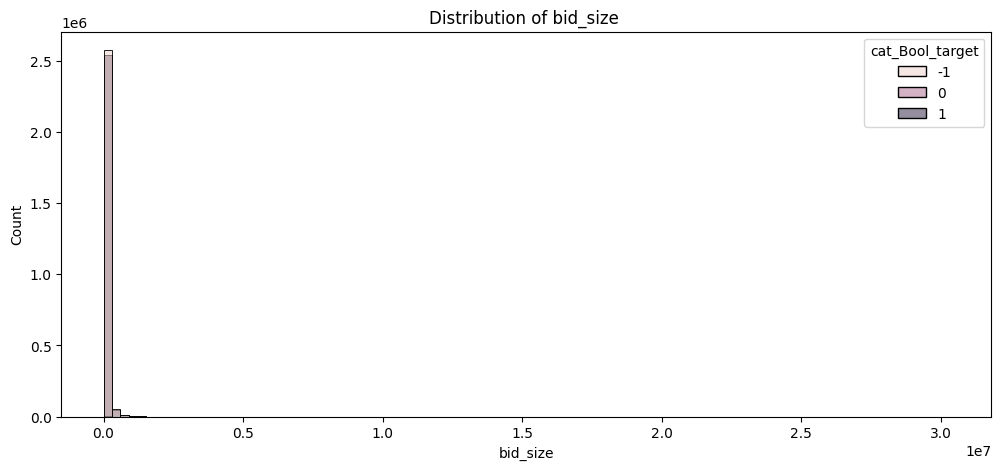

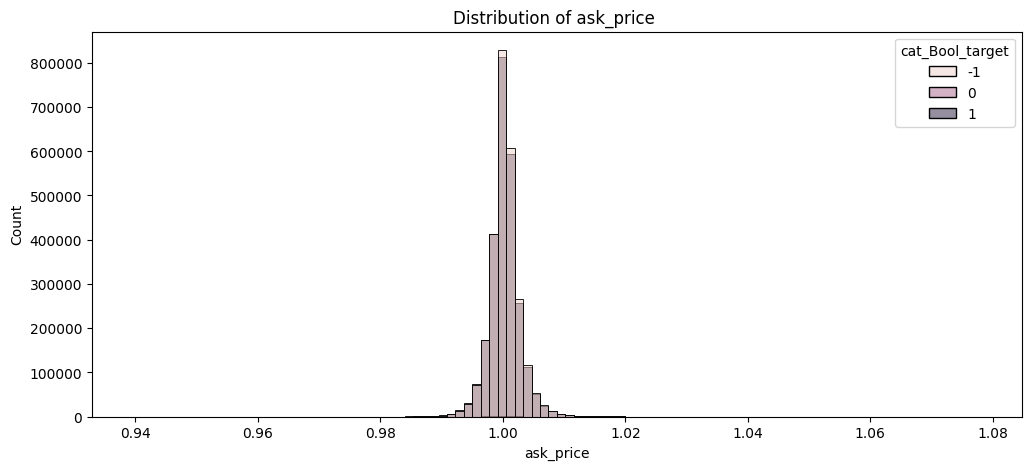

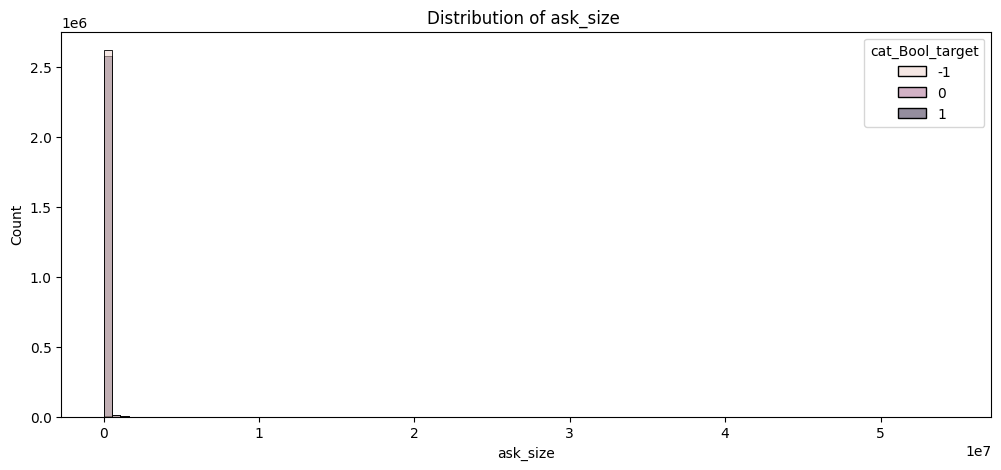

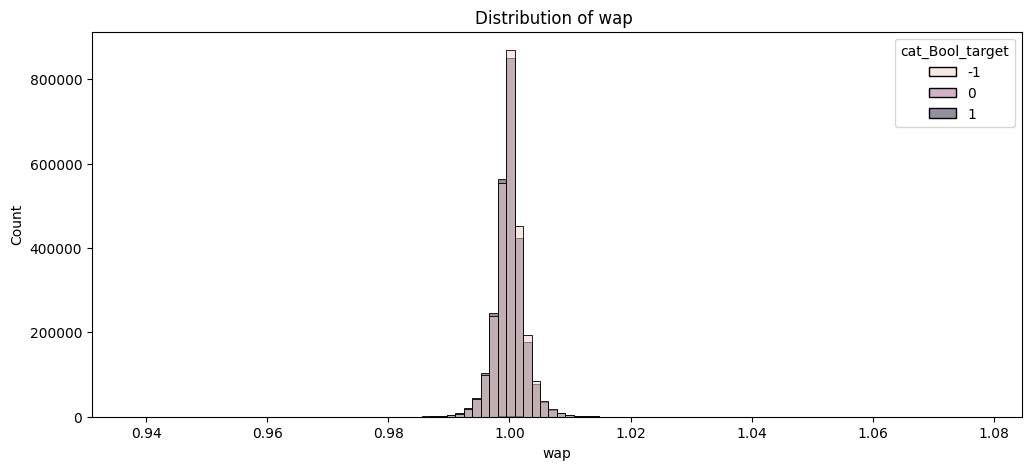

In [22]:
for f in float_cols:
    fig, axs = plt.subplots(1,1,figsize=(12, 5))
    sns.histplot(data=df, x=f, hue='cat_Bool_target', bins=100, alpha=0.5, ax=axs)
    axs.set_title(f"Distribution of {f} ")
    plt.show()

    Above hist plots show some Features Which can be good in Classification of classes 0  1 and -1 
    
    with out scaling
    wap
    ask_price
    bid_price
    reference price
    near price 
    
    with log scaling 
    matched_size
    bid_size
    ask_size
    imbalance_size
    far_price

In [ ]:
log_features = ['matched_size','bid_size','ask_size','imbalance_size','far_price']
non_log_features  = ['reference_price','near_price','bid_price','ask_price','wap']

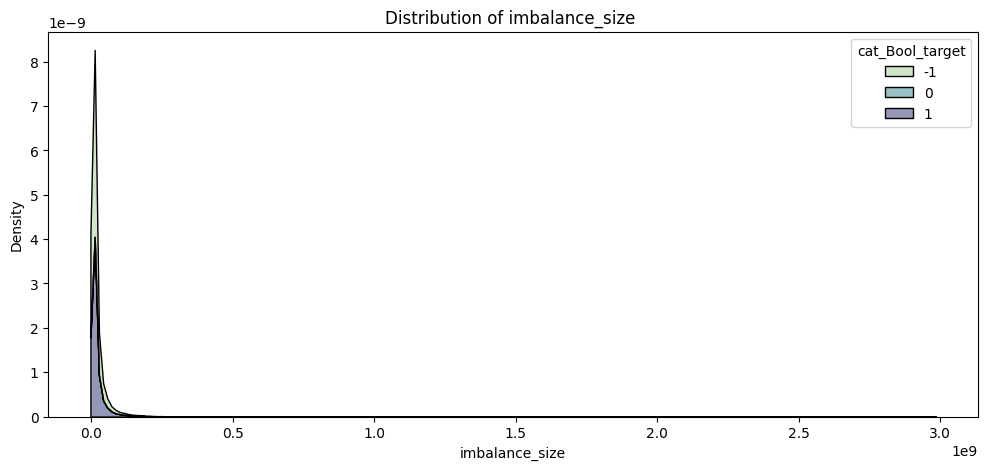

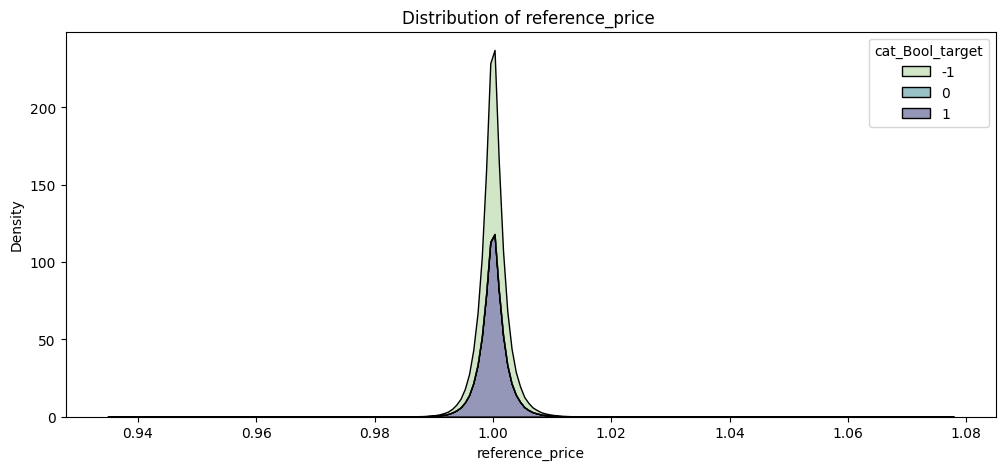

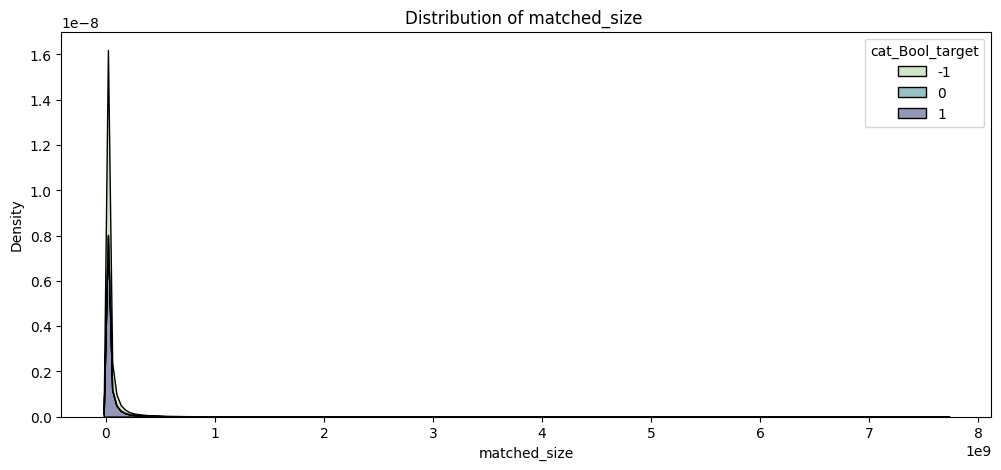

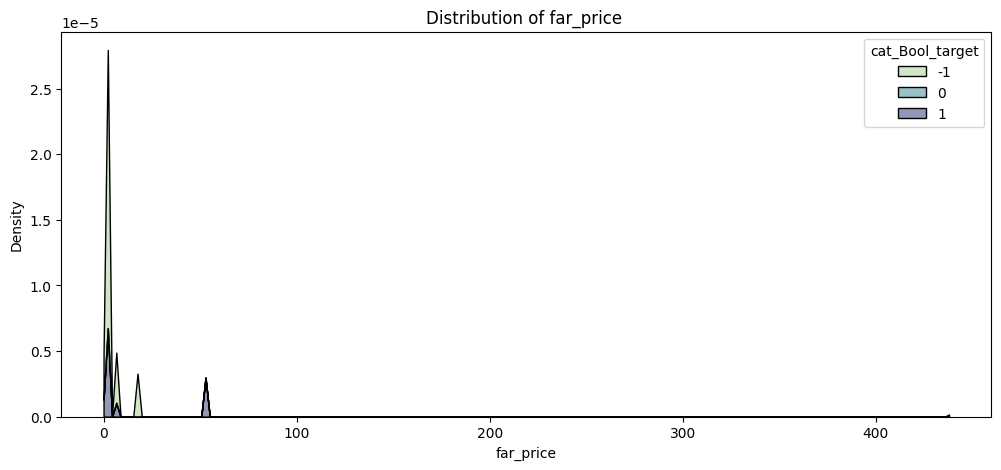

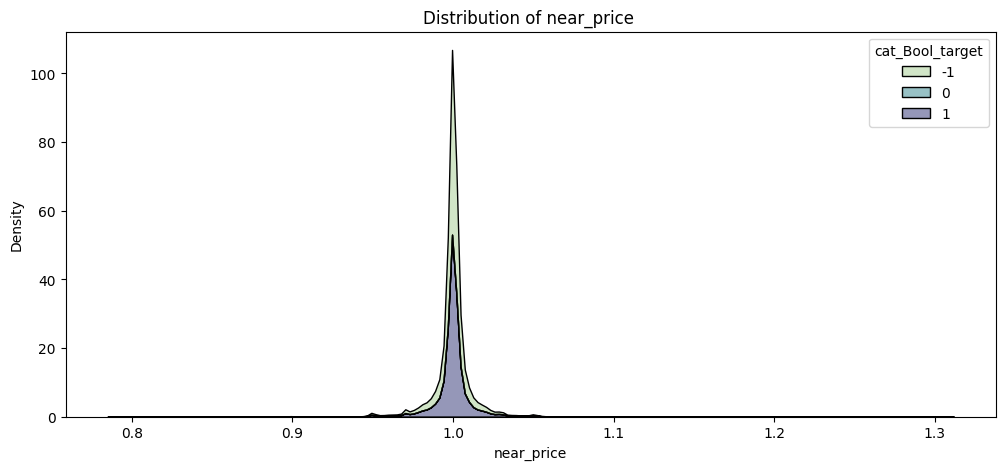

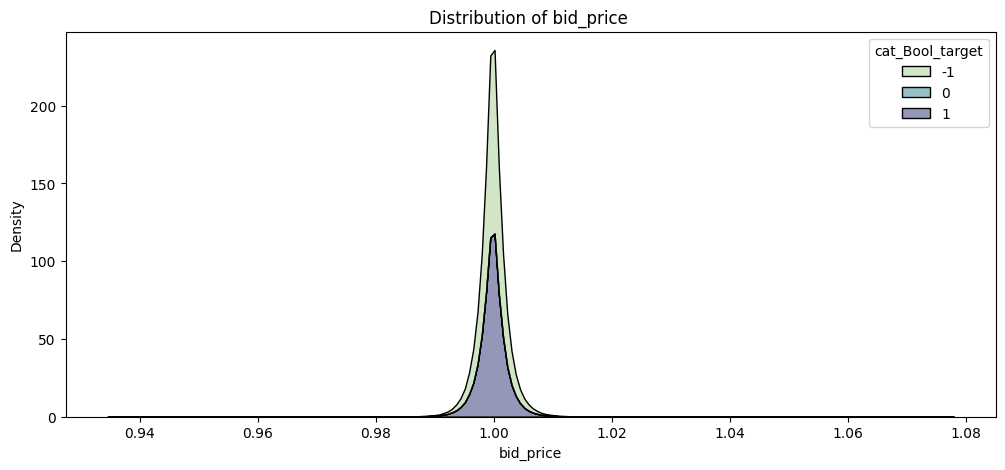

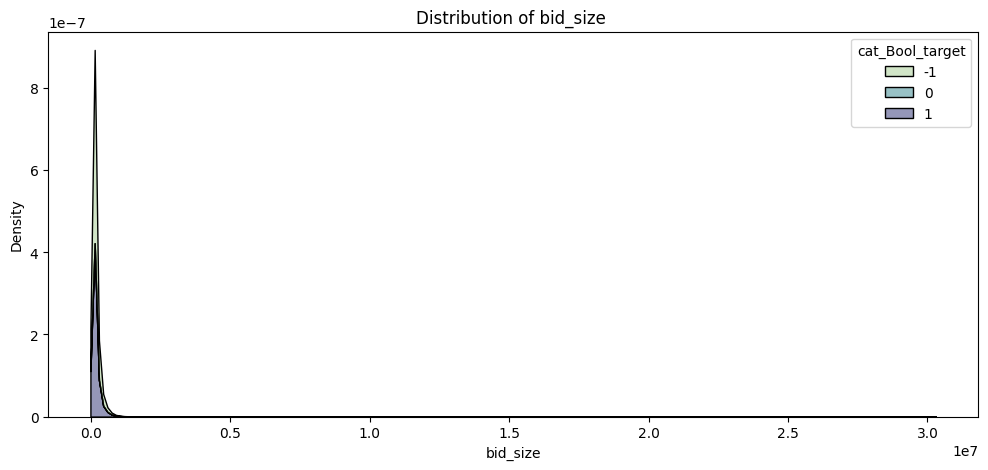

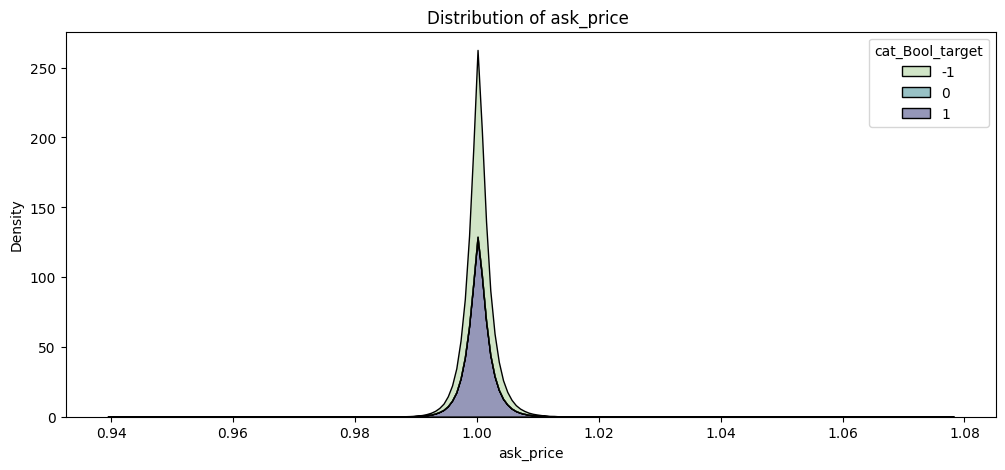

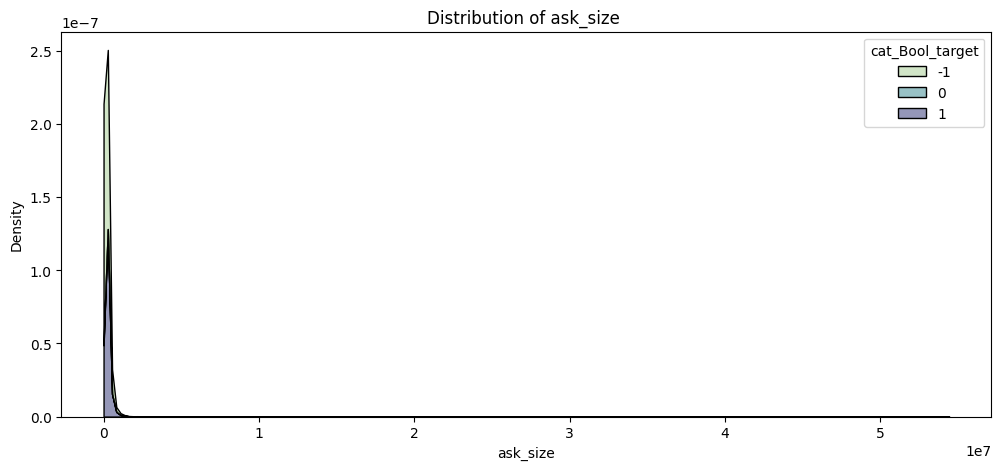

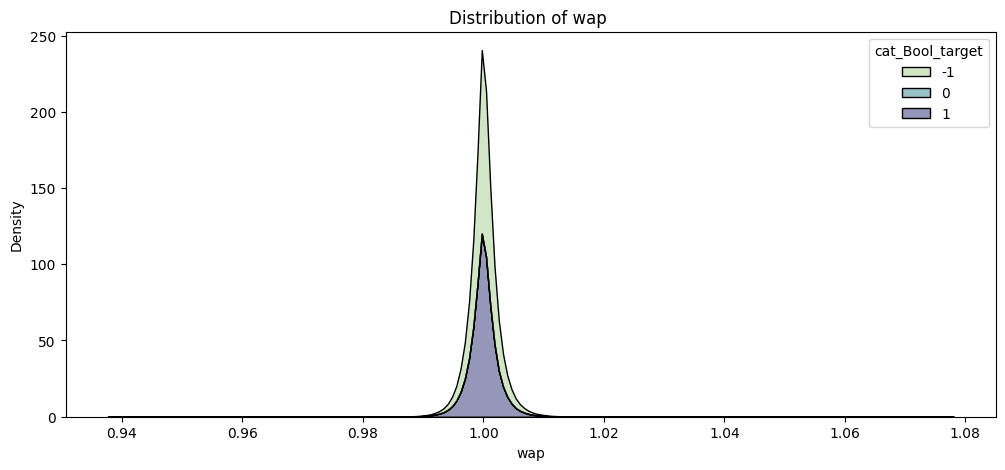

In [41]:
for f in float_cols:
    fig, axs = plt.subplots(1,1,figsize=(12, 5))
    sns.kdeplot(data=df, x=f, hue="cat_Bool_target", multiple="stack",alpha=.5, palette="crest",ax=axs);
    axs.set_title(f"Distribution of {f} ")
    plt.show()

    The above distriution almost same for  target class -1 and 1 but the density height of 1 is less than that of -1 , and both have nearly same count it indicates that the 1 category is distributed to the edges of the plot on x axis eg fro wap value > 1.1 and > 0.99

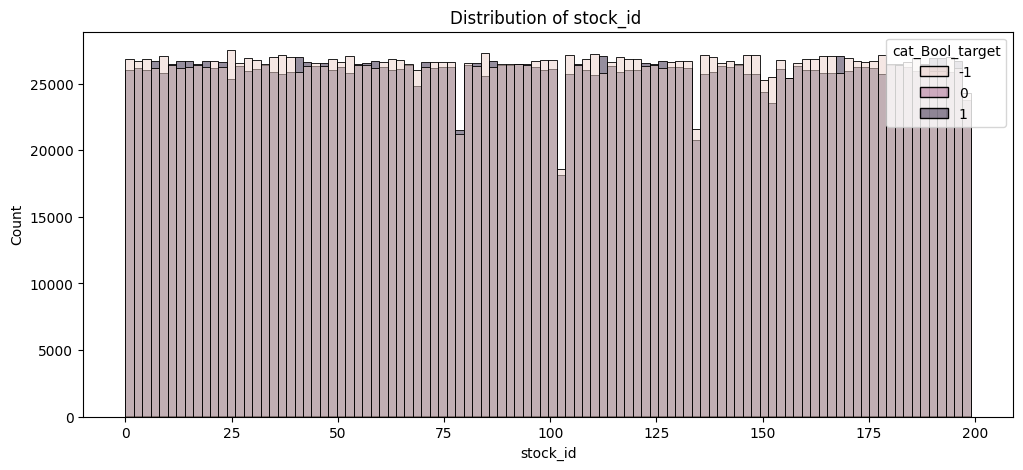

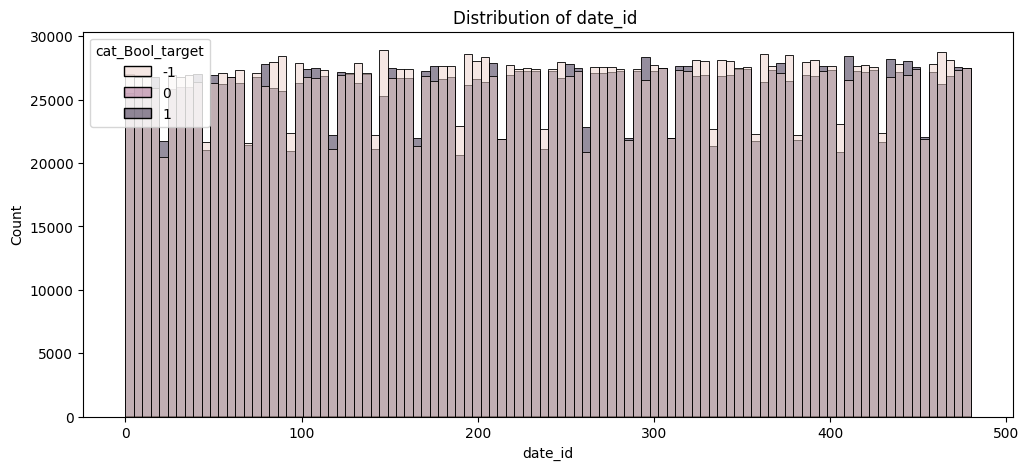

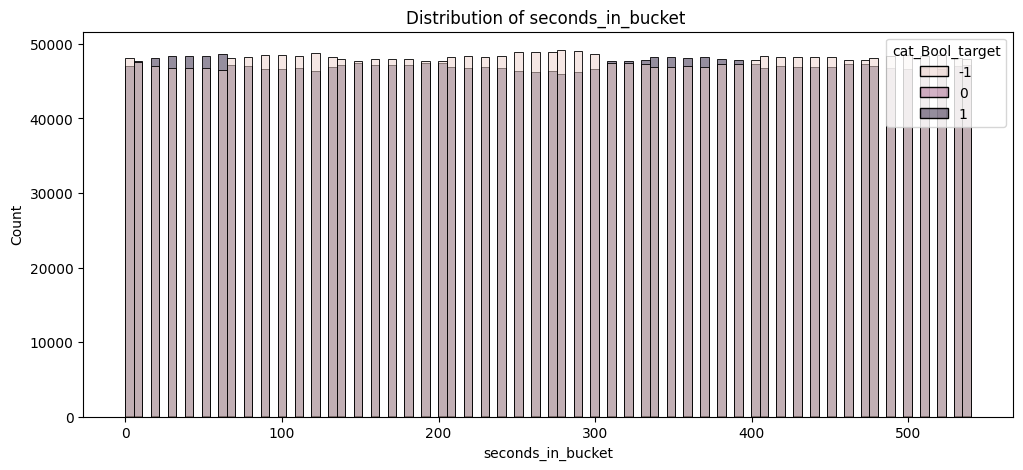

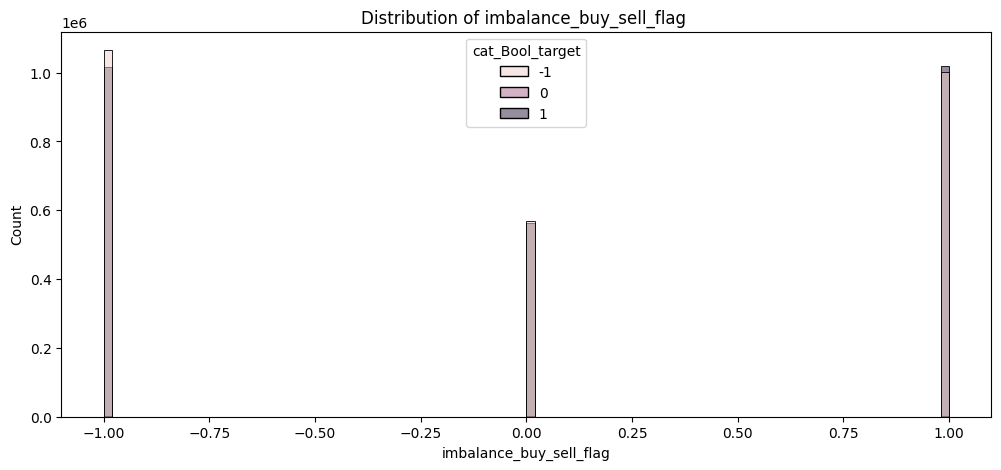

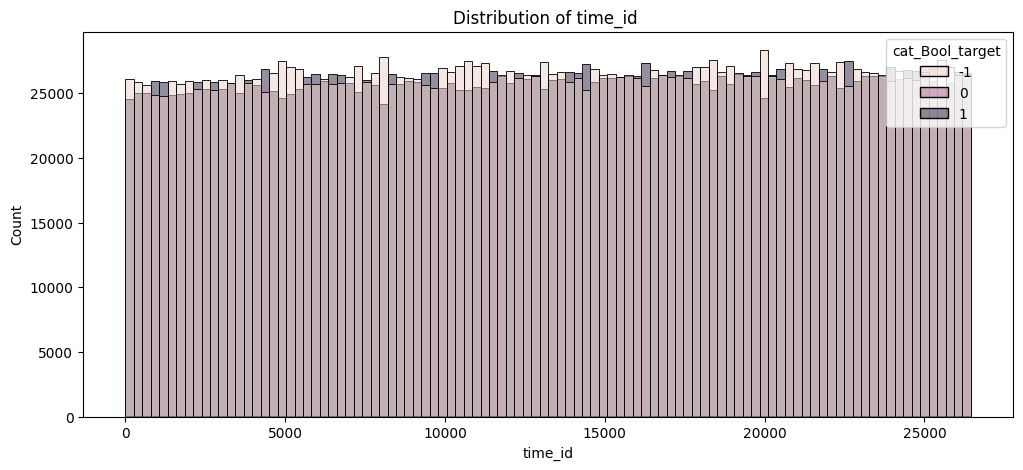

In [23]:
for f in int_cols:
    fig, axs = plt.subplots(1,1,figsize=(12, 5))
    sns.histplot(data=df, x=f, hue='cat_Bool_target', bins=100, alpha=0.5, ax=axs)
    axs.set_title(f"Distribution of {f} ")
    plt.show()

    The Distribution of Above Categorical features given in numeric format  are nearly same in the data:
    time_id
    seconds_in_bucket 
    date_id
    stock_id
    
    The imbalance_buy_sell_flag can be a usefull feature for categorization of move in stock

/tmp/ipykernel_42/3489840669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.target.values, color = 'green', bins = 100, hist_kws = {'alpha':0.5})


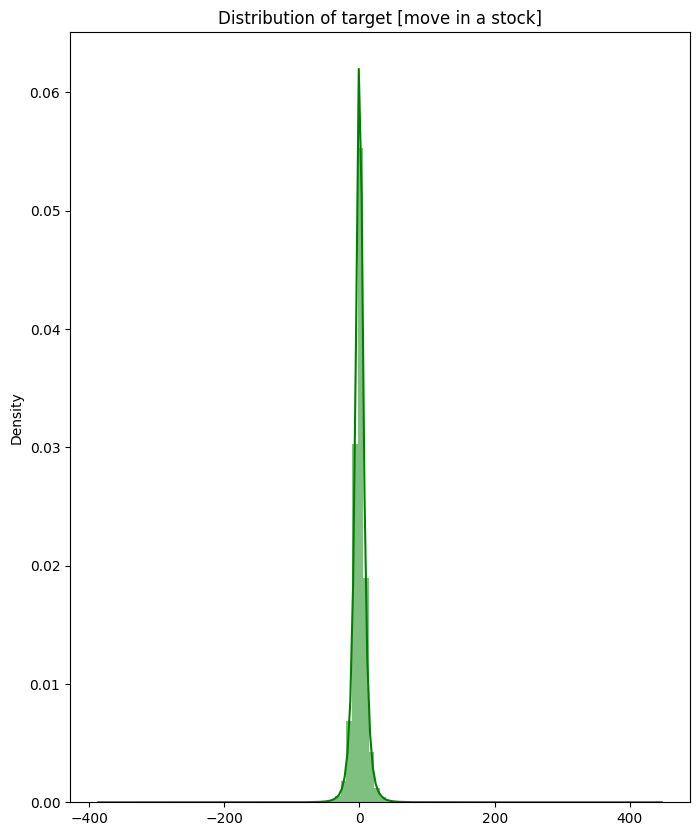

In [8]:
fig, axs = plt.subplots(figsize = (8,10))
sns.distplot(df.target.values, color = 'green', bins = 100, hist_kws = {'alpha':0.5})
plt.title("Distribution of target [move in a stock]")
plt.show()

In [14]:
df.head(20)

stock_id  date_id  seconds_in_bucket  imbalance_size  \
0          0        0                  0      3180602.69   
1          1        0                  0       166603.91   
2          2        0                  0       302879.87   
3          3        0                  0     11917682.27   
4          4        0                  0       447549.96   
5          5        0                  0            0.00   
6          6        0                  0       969969.40   
7          7        0                  0      9412959.10   
8          8        0                  0      2394875.85   
9          9        0                  0      3039700.65   
10        10        0                  0     10482752.19   
11        11        0                  0      1506120.20   
12        12        0                  0     11739945.44   
13        13        0                  0      5749286.01   
14        14        0                  0      8899495.49   
15        15        0                  0      4469771.00   
16        16        0                  0       472499.39   
17        17        0                  0     12411362.37   
18        18        0                  0       516904.04   
19        19        0                  0            0.00   

    imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                         1         0.999812   13380276.64        NaN   
1                        -1         0.999896    1642214.25        NaN   
2                        -1         0.999561    1819368.03        NaN   
3                        -1         1.000171   18389745.62        NaN   
4                        -1         0.999532   17860614.95        NaN   
5                         0         1.000635   13552875.92        NaN   
6                         1         1.000115    3647503.98        NaN   
7                         1         0.999818   21261245.87        NaN   
8                         1         0.999916    9473209.08        NaN   
9                        -1         1.000969    6248958.45        NaN   
10                       -1         1.001374    8839457.10        NaN   
11                       -1         0.999968    2001112.44        NaN   
12                        1         0.999794   13597118.70        NaN   
13                        1         0.998995    7039173.61        NaN   
14                        1         1.000495   39020484.94        NaN   
15                        1         0.999403    1765835.46        NaN   
16                       -1         0.999258    3438806.60        NaN   
17                       -1         1.000966   27288881.25        NaN   
18                       -1         1.000029    1263451.92        NaN   
19                        0         0.999387    2815450.75        NaN   

    near_price  bid_price   bid_size  ask_price   ask_size  wap     target  \
0          NaN   0.999812   60651.50   1.000026    8493.03  1.0  -3.029704   
1          NaN   0.999896    3233.04   1.000660   20605.09  1.0  -5.519986   
2          NaN   0.999403   37956.00   1.000298   18995.00  1.0  -8.389950   
3          NaN   0.999999    2324.90   1.000214  479032.40  1.0  -4.010200   
4          NaN   0.999394   16485.54   1.000016     434.10  1.0  -7.349849   
5          NaN   0.999779    1962.72   1.000635    5647.65  1.0   6.779432   
6          NaN   0.999506    6663.16   1.000283    3810.48  1.0  -2.499819   
7          NaN   0.999741    5139.20   1.000130    2570.60  1.0  -1.959801   
8          NaN   0.999022   52011.60   1.000041    2169.36  1.0  -5.970001   
9          NaN   0.999354    6191.00   1.000646    6199.00  1.0   7.970333   
10         NaN   0.999885   18802.00   1.001321  217098.37  1.0   5.350113   
11         NaN   0.999840    1174.45   1.000351    2585.11  1.0   2.559423   
12         NaN   0.999794   33221.00   1.000296   47824.00  1.0   8.399487   
13         NaN   0.999074   12327.73   1.000096    1272.20  1.0 -10.750294   
14         NaN   0.999976    4321.24   

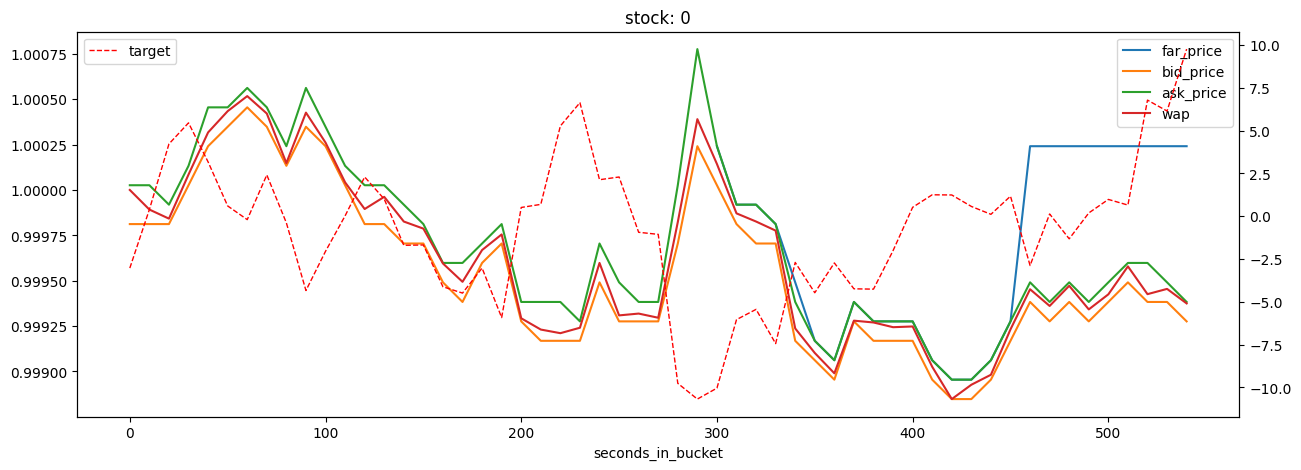

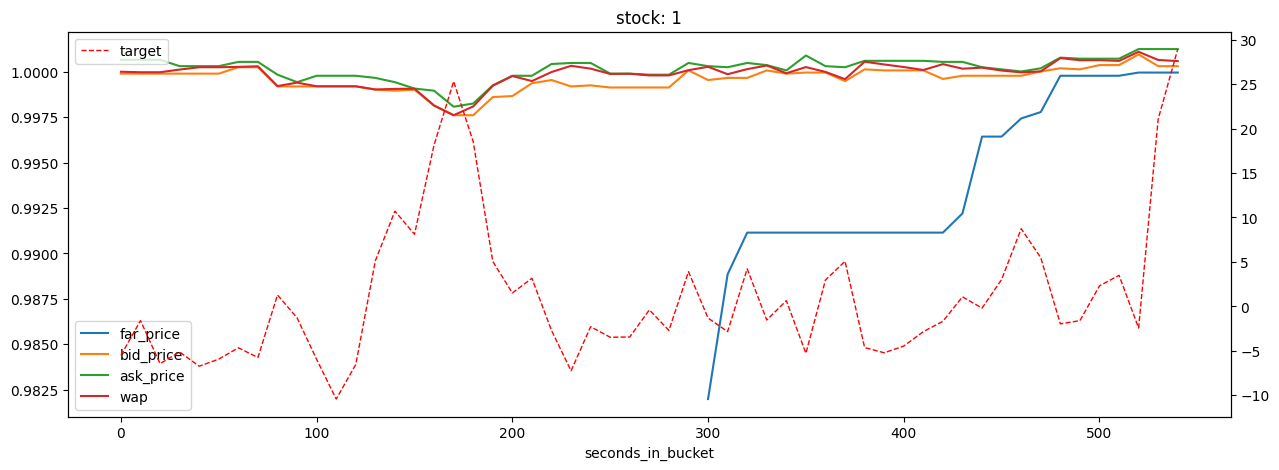

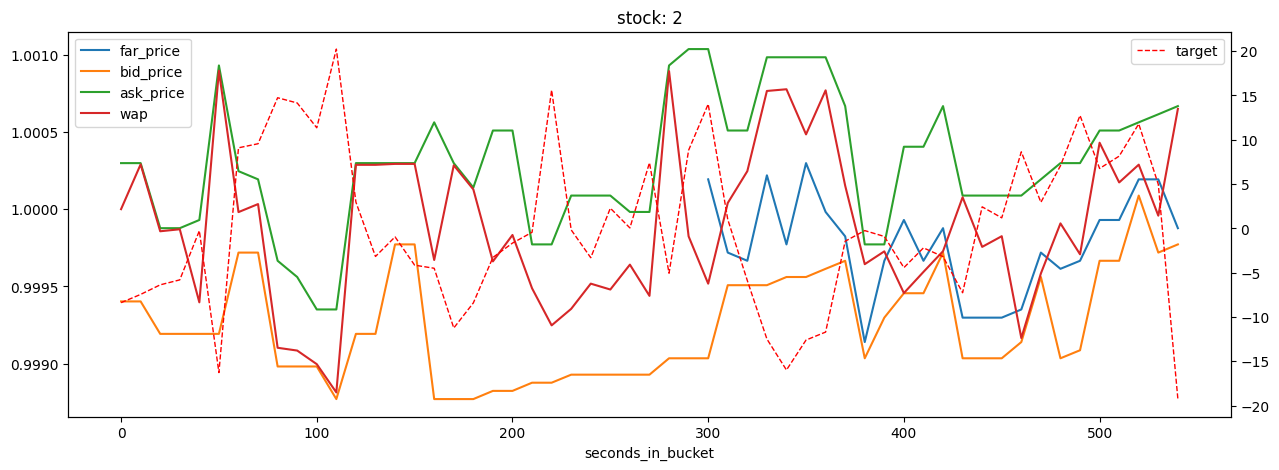

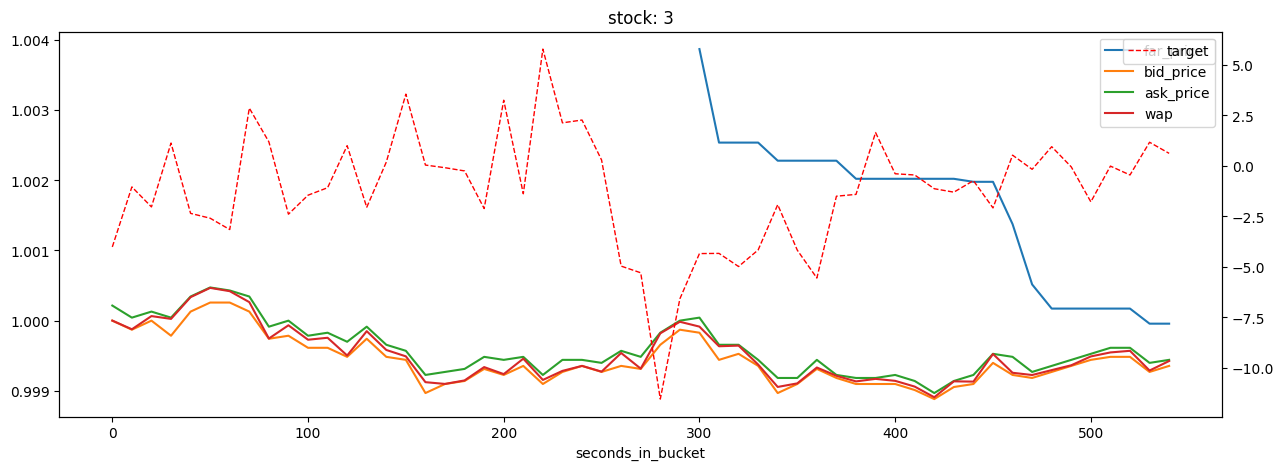

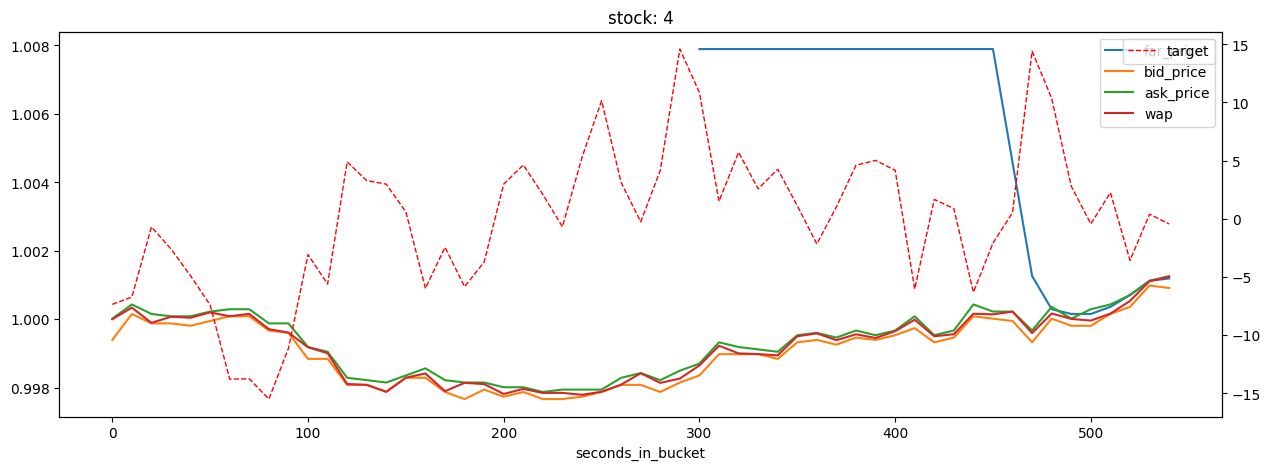

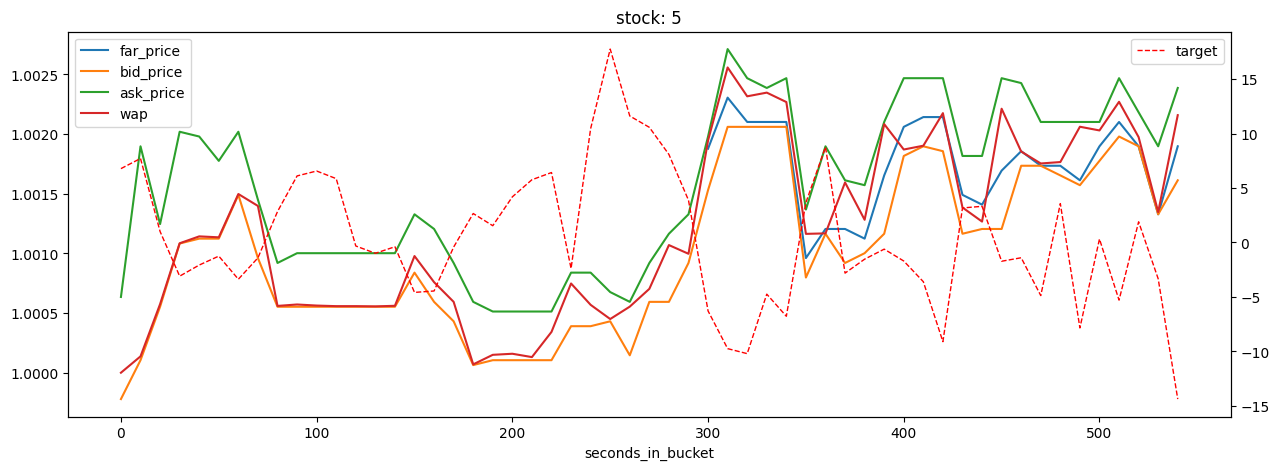

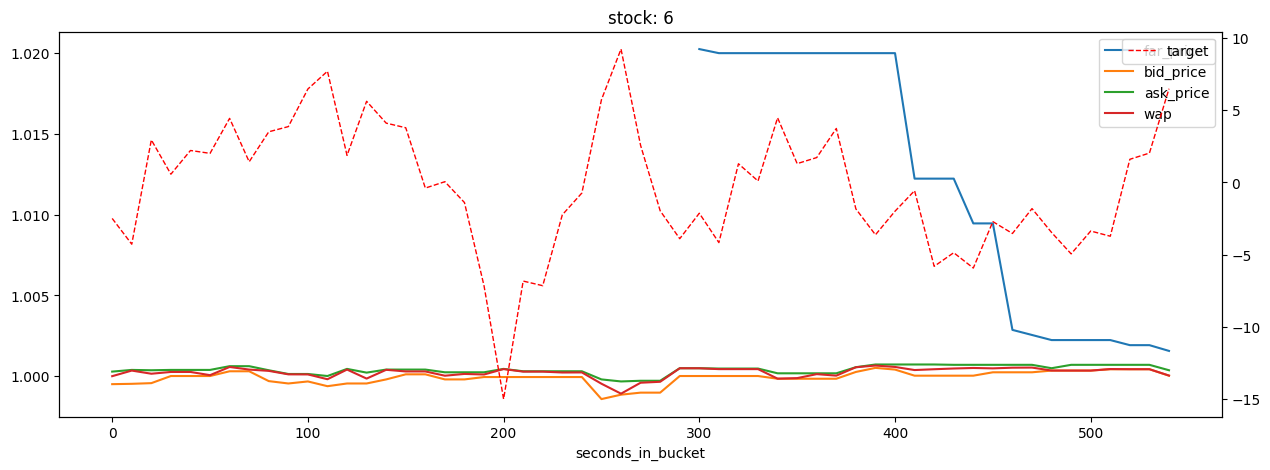

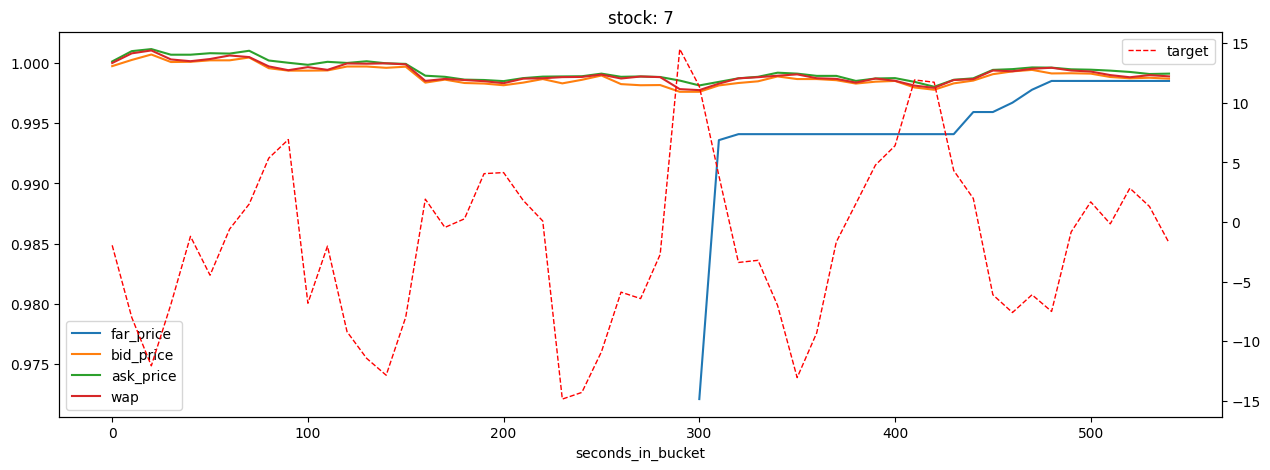

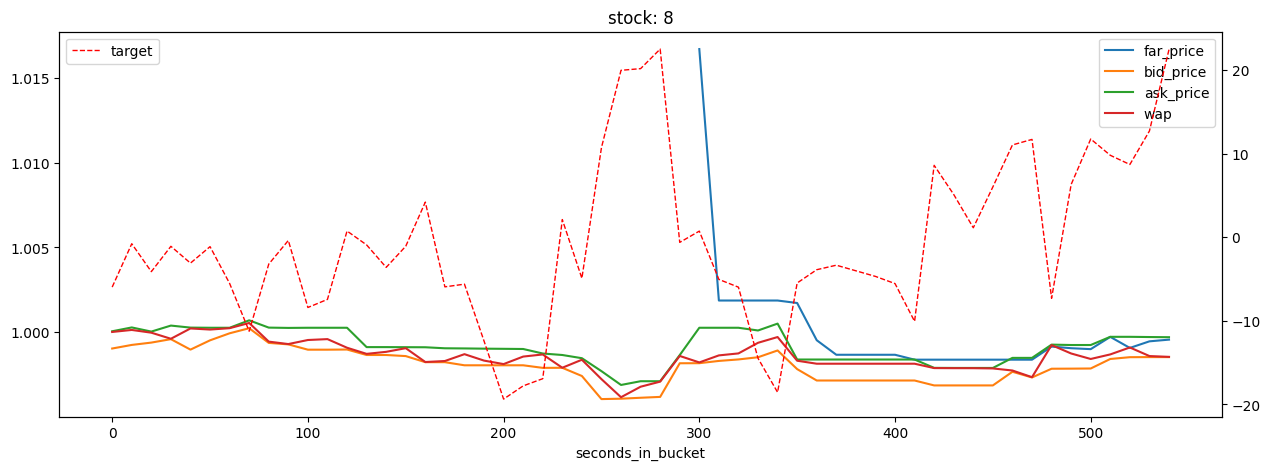

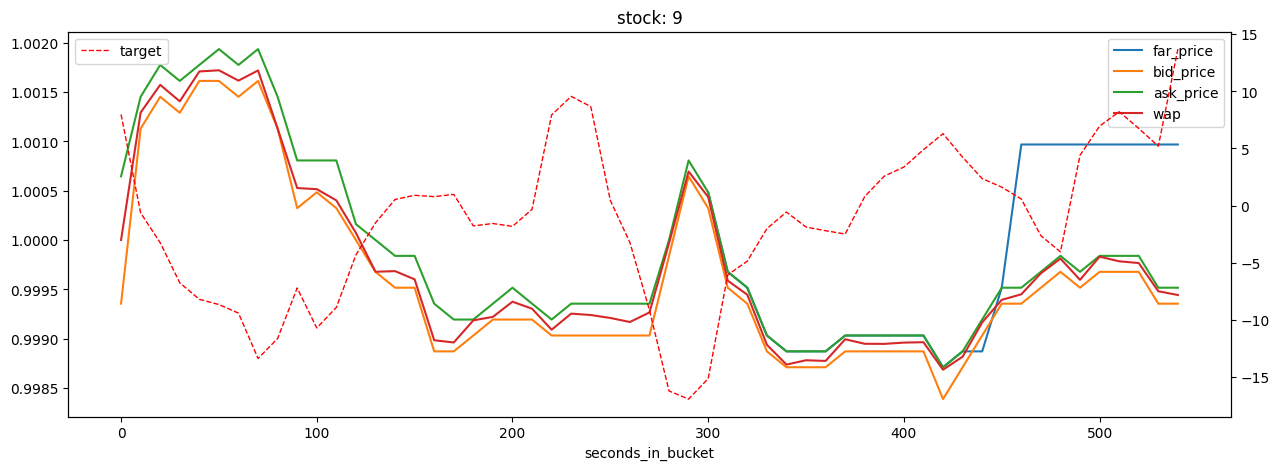

In [50]:
##Auction order book
count = 0 
for stock_id , data in df.groupby('stock_id'):
    fig , axs = plt.subplots(figsize = (15,5))
    data.query('date_id == 0').set_index('seconds_in_bucket')[['far_price','bid_price','ask_price','wap']].plot(ax = axs, title = f"stock: {stock_id}")
    ax2 = axs.twinx()
    data.query('date_id == 0').set_index('seconds_in_bucket')[['target']].plot(ax = ax2, color = "red", ls = '--',lw = 1)
    plt.show()
    count+=1
    if count == 10:
        break
    

    The bid ask and  wap price follow nearly the same trend
    The far price is only available at the last seconds
    The stock move [target] seems to be opposite that of other prices and wap

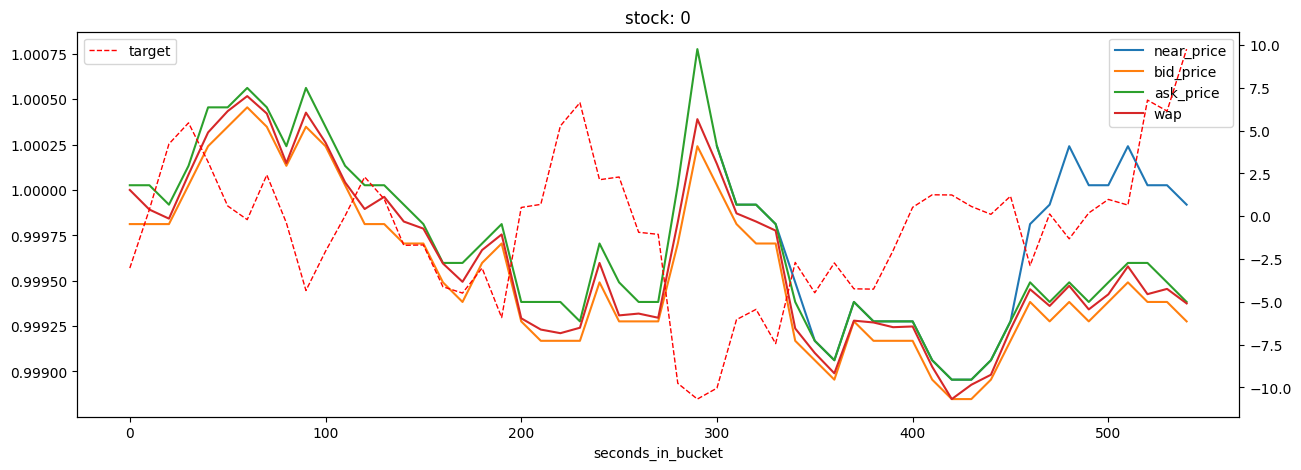

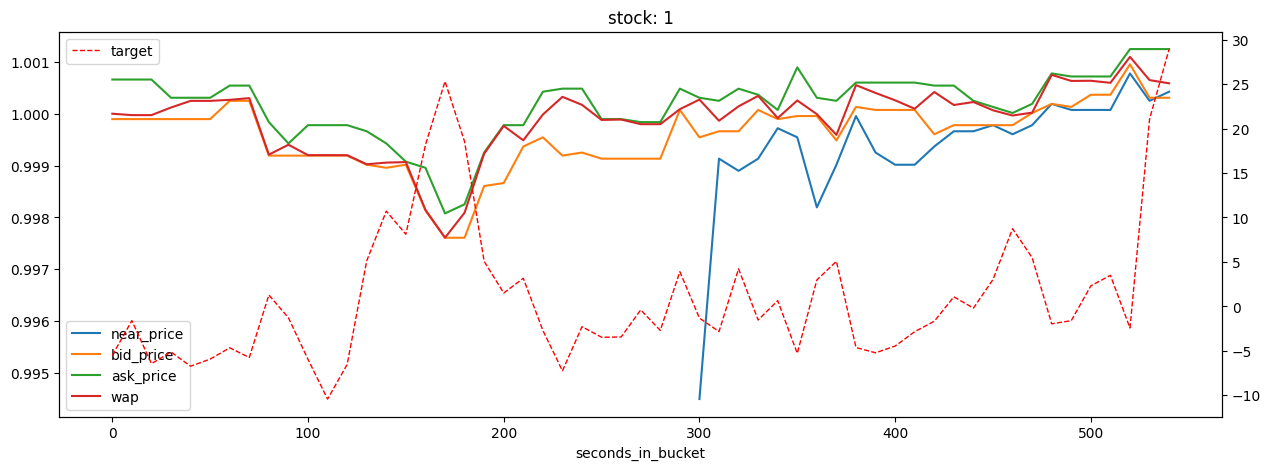

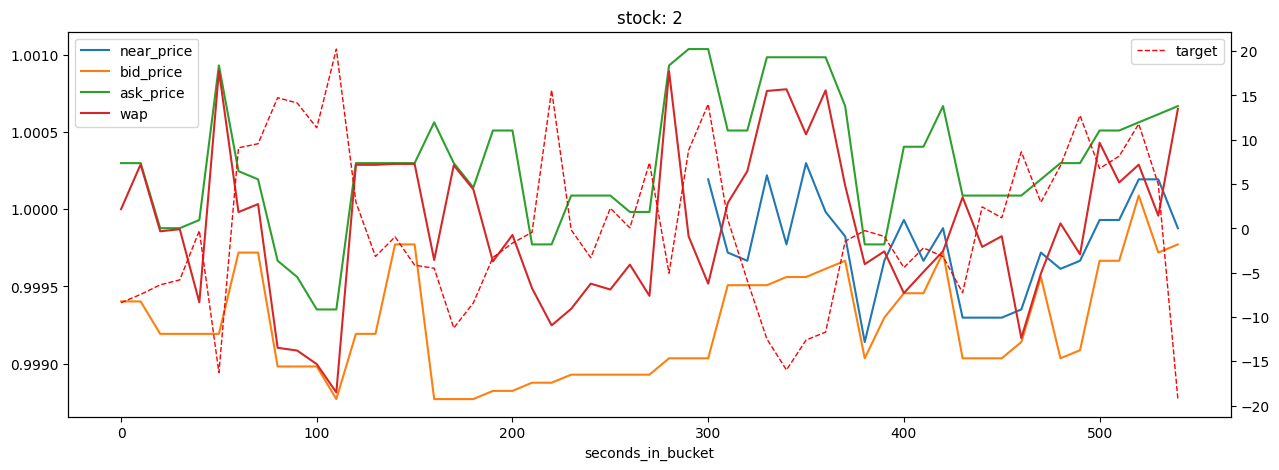

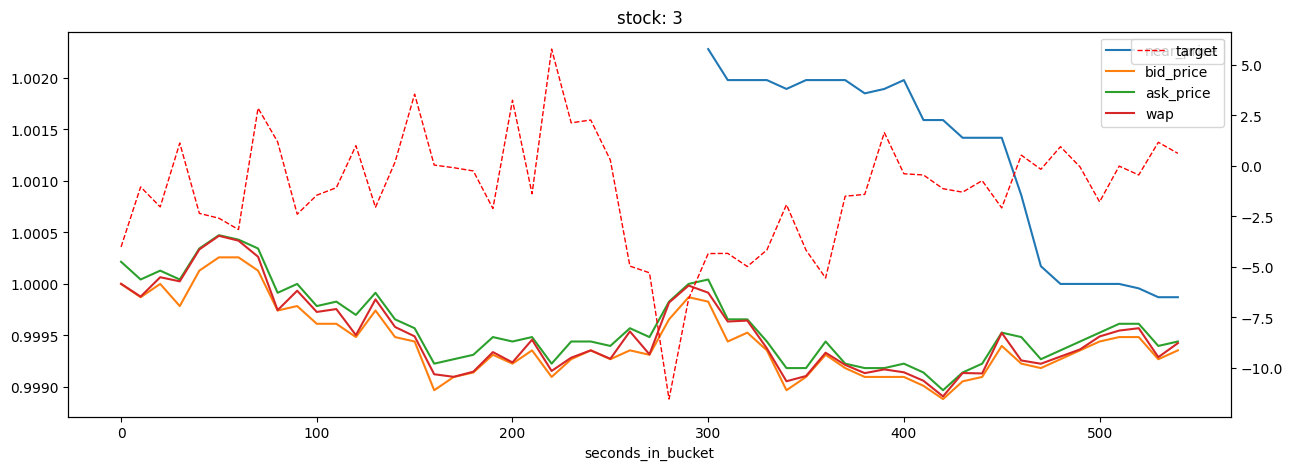

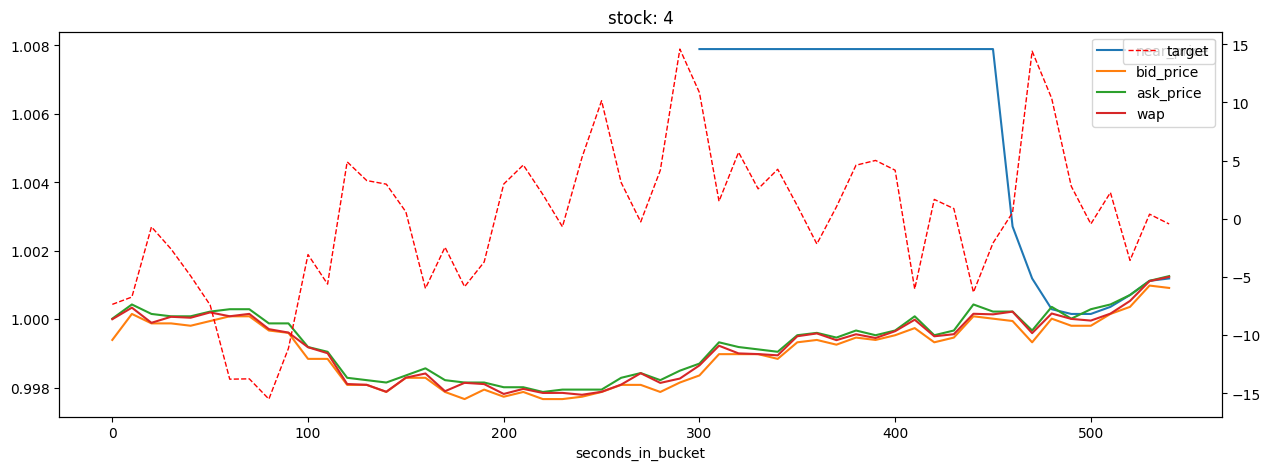

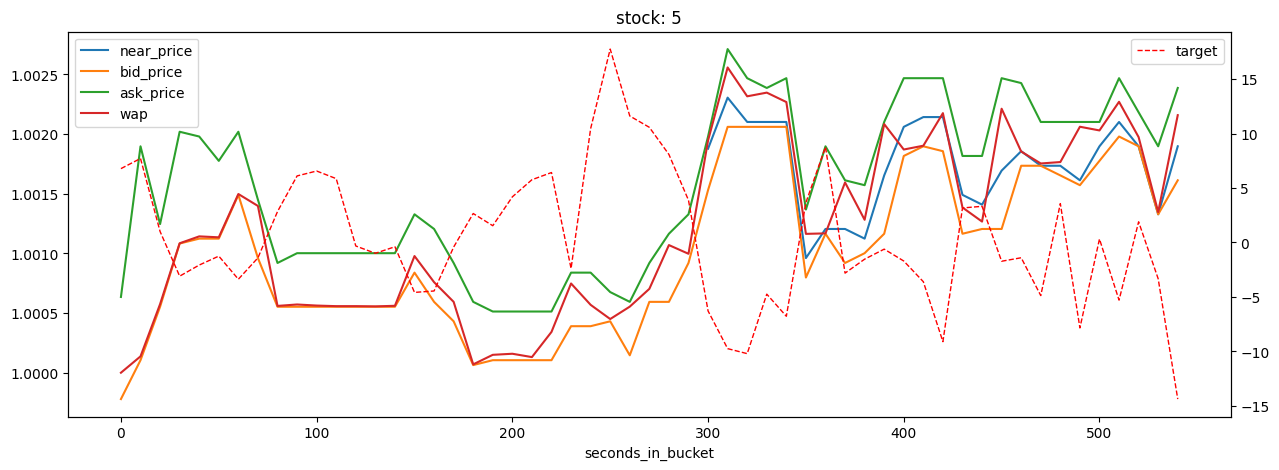

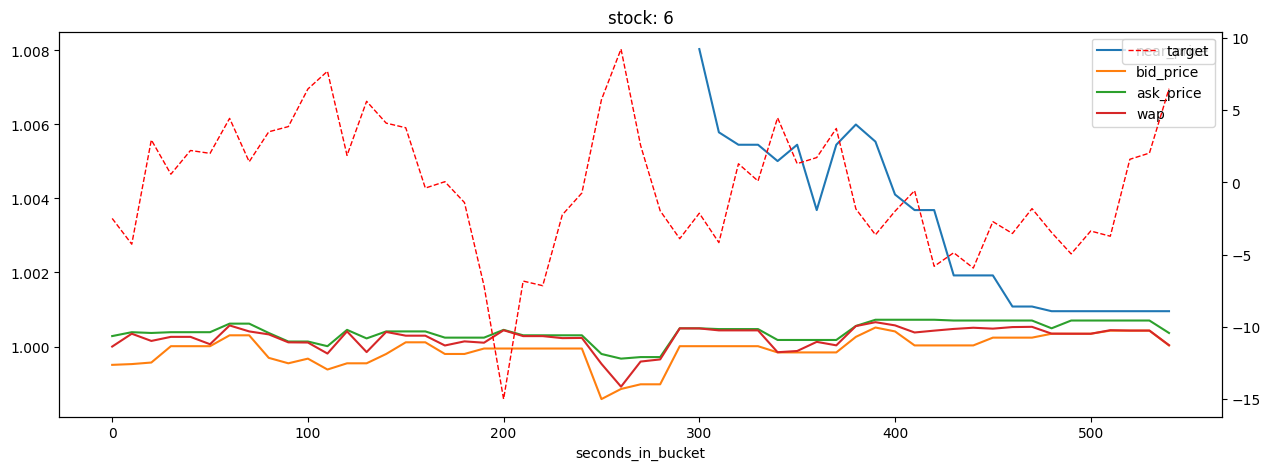

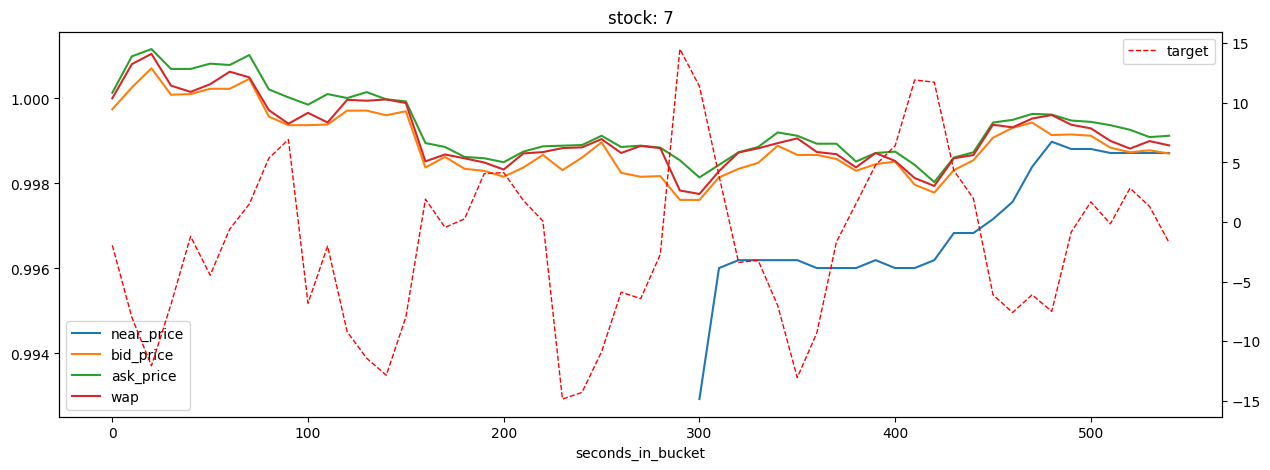

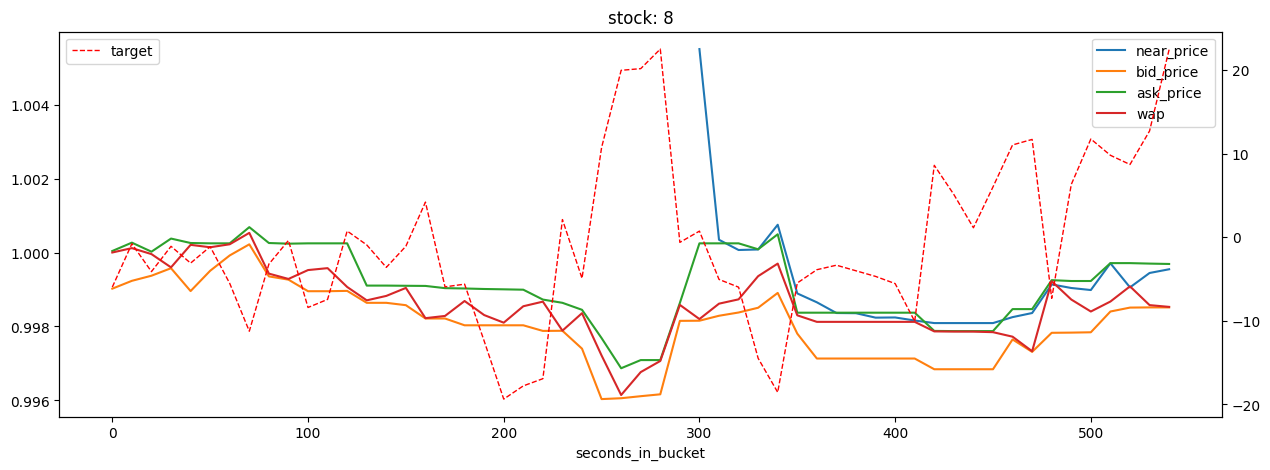

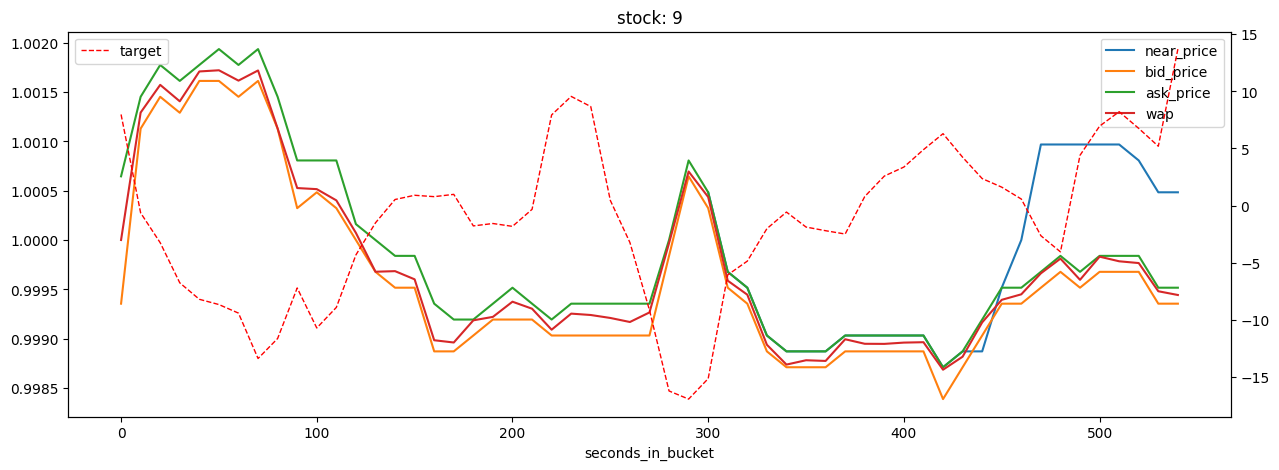

In [52]:
##Combined book
count = 0 
for stock_id , data in df.groupby('stock_id'):
    fig , axs = plt.subplots(figsize = (15,5))
    data.query('date_id == 0').set_index('seconds_in_bucket')[['near_price','bid_price','ask_price','wap']].plot(ax = axs, title = f"stock: {stock_id}")
    ax2 = axs.twinx()
    data.query('date_id == 0').set_index('seconds_in_bucket')[['target']].plot(ax = ax2, color = "red", ls = '--',lw = 1)
    plt.show()
    count+=1
    if count == 10:
        break
    

    Near price is following is same trend with other prices as far price

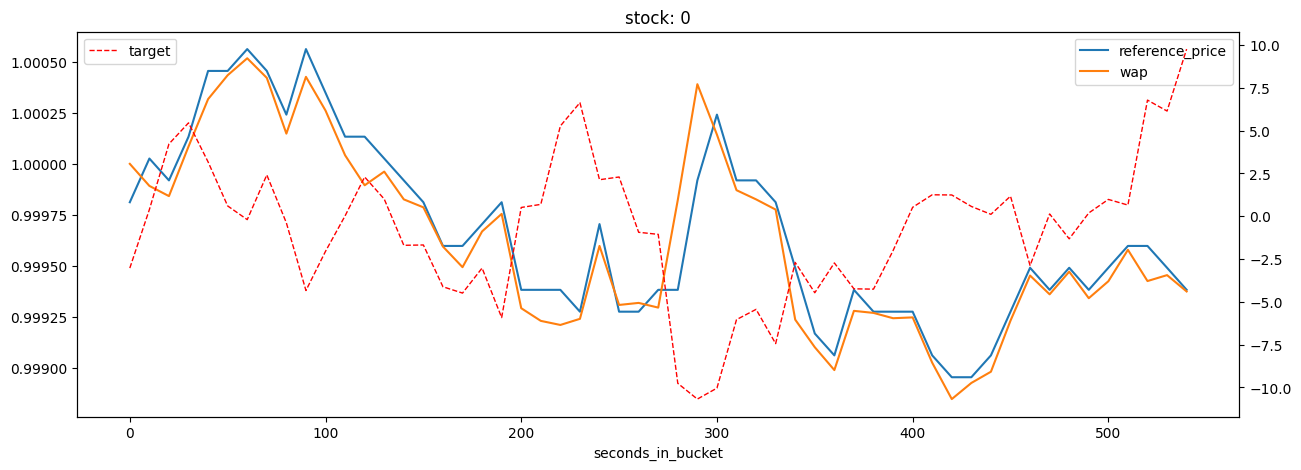

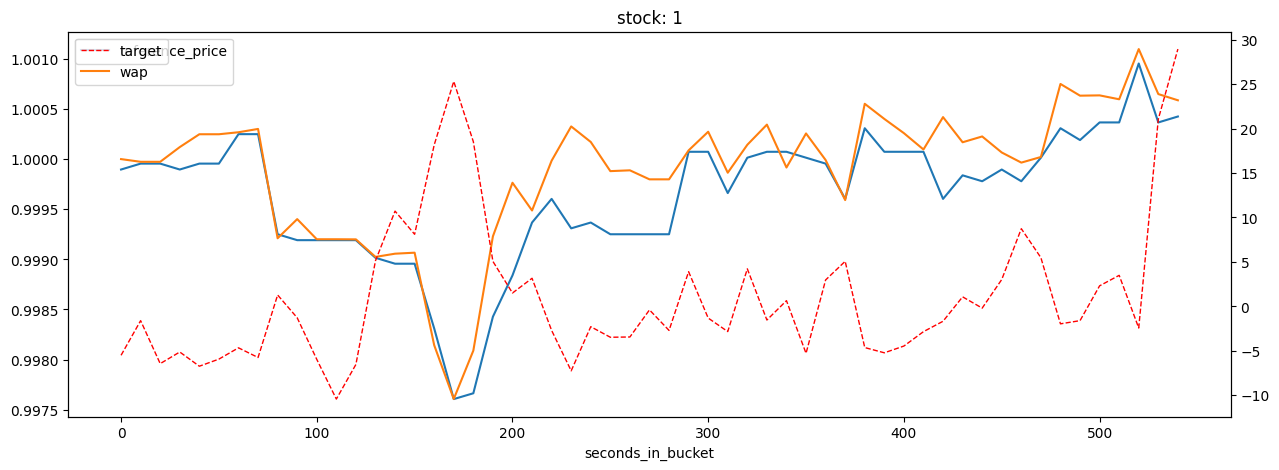

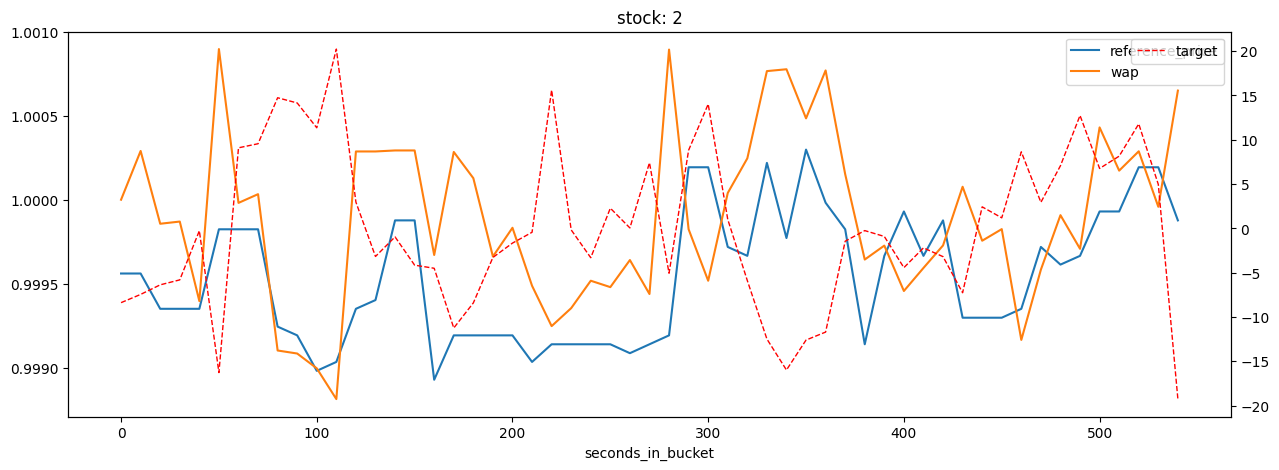

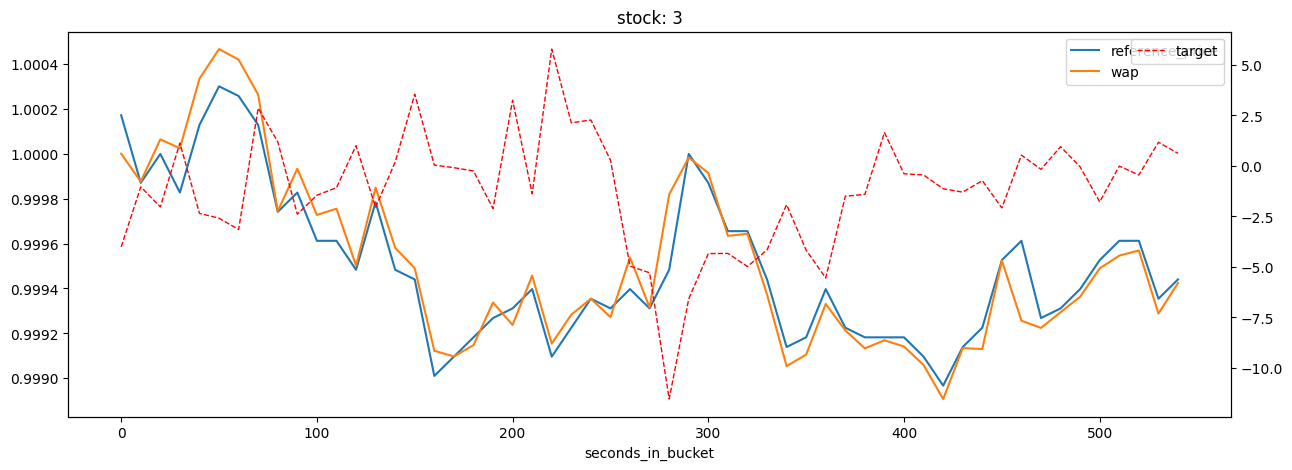

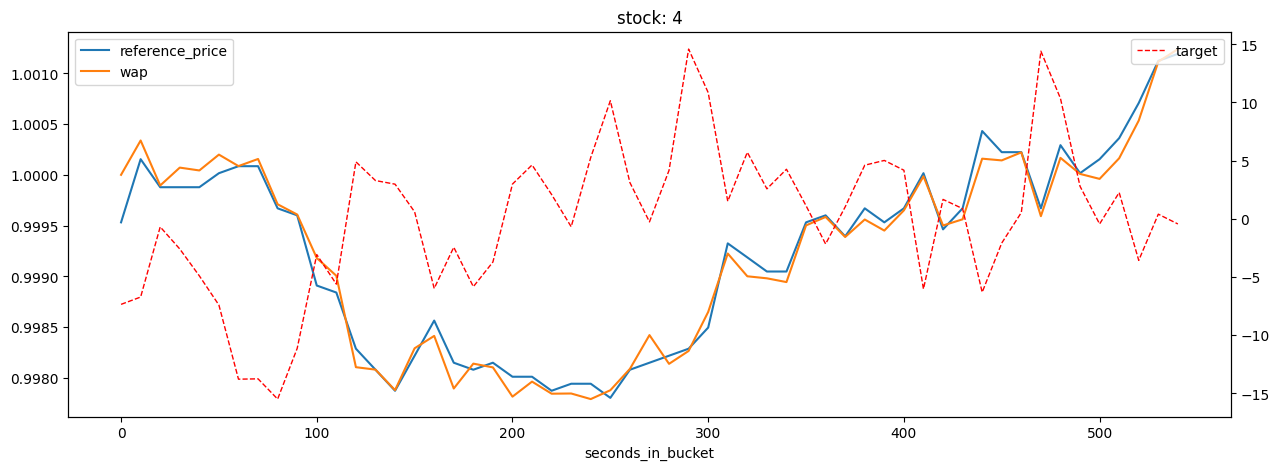

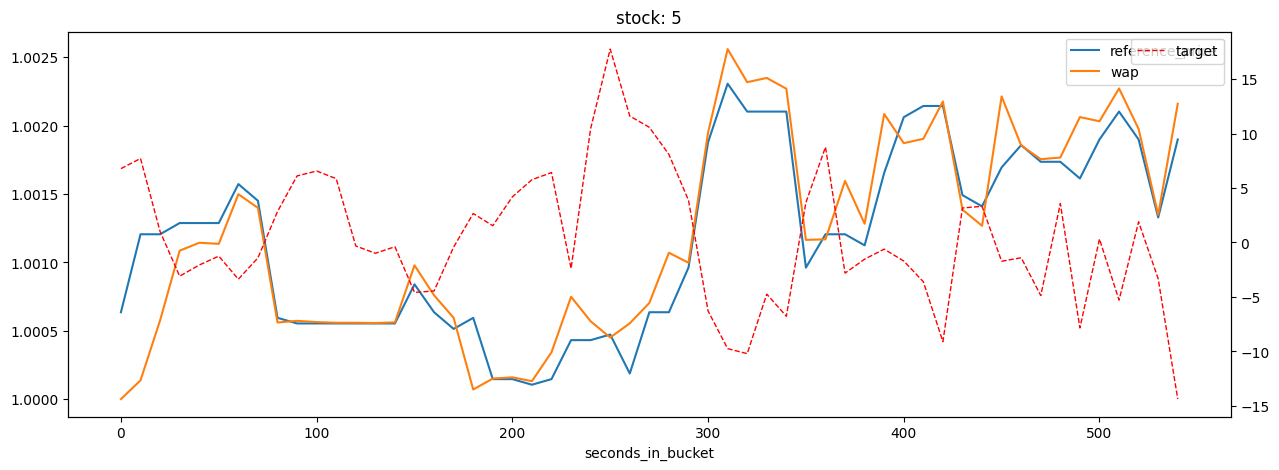

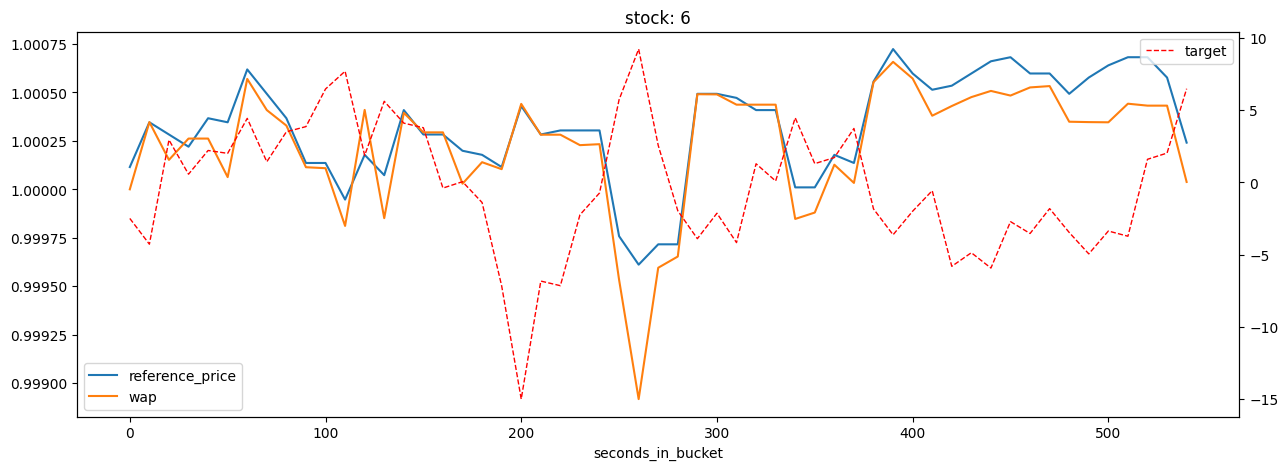

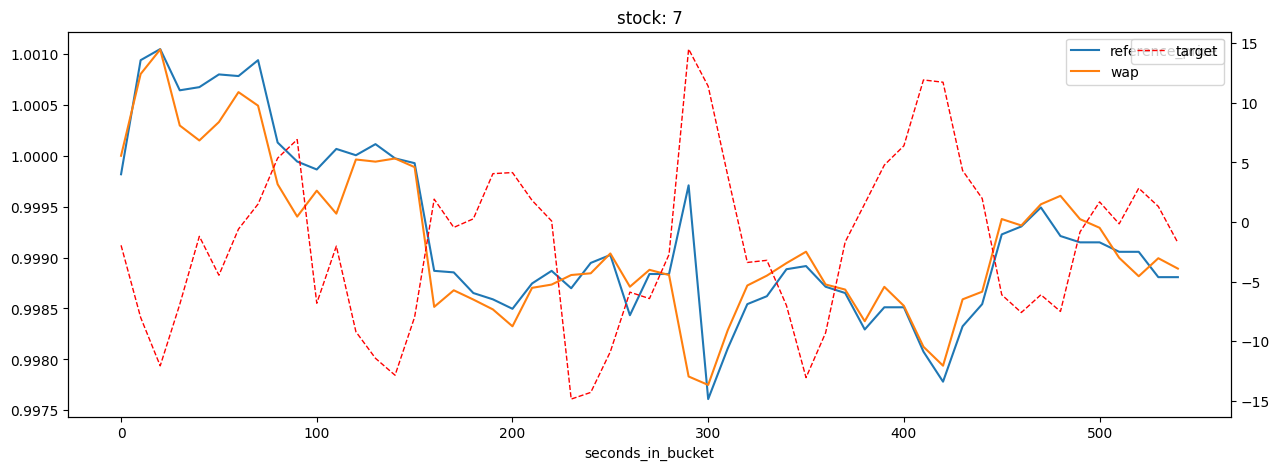

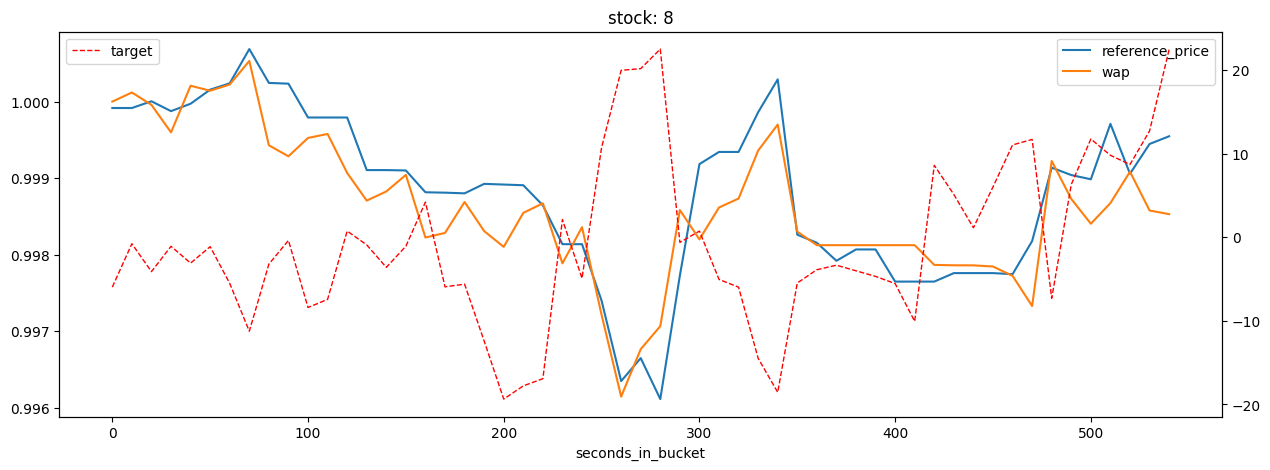

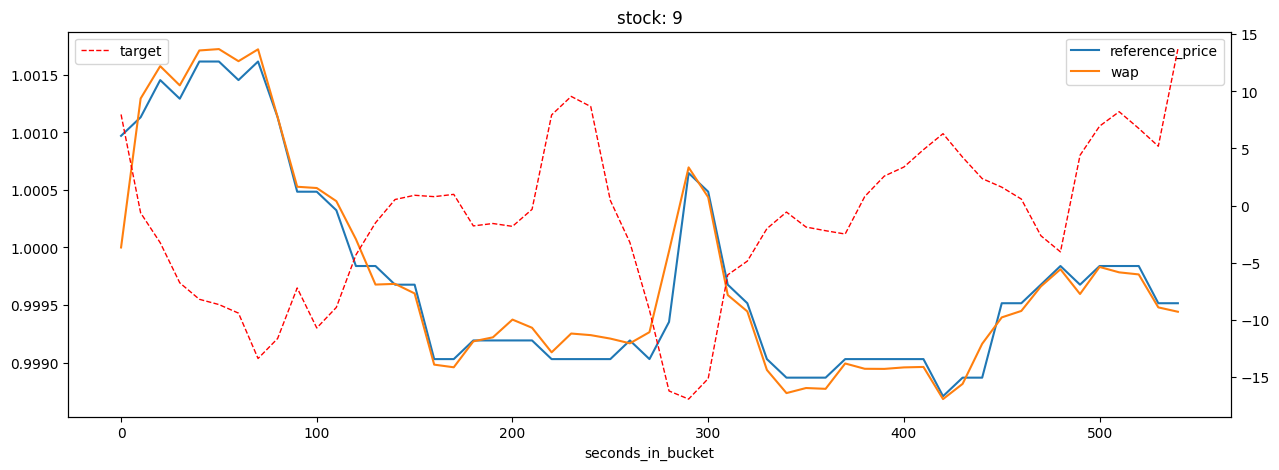

In [55]:
#reference Price
count = 0 
for stock_id , data in df.groupby('stock_id'):
    fig , axs = plt.subplots(figsize = (15,5))
    data.query('date_id == 0').set_index('seconds_in_bucket')[['reference_price','wap']].plot(ax = axs, title = f"stock: {stock_id}")
    ax2 = axs.twinx()
    data.query('date_id == 0').set_index('seconds_in_bucket')[['target']].plot(ax = ax2, color = "red", ls = '--',lw = 1)
    plt.show()
    count+=1
    if count == 10:
        break
    

    Reference and wap are following each other as seen from the plot 
    and the target and above prices are getting low and high in opposite manner

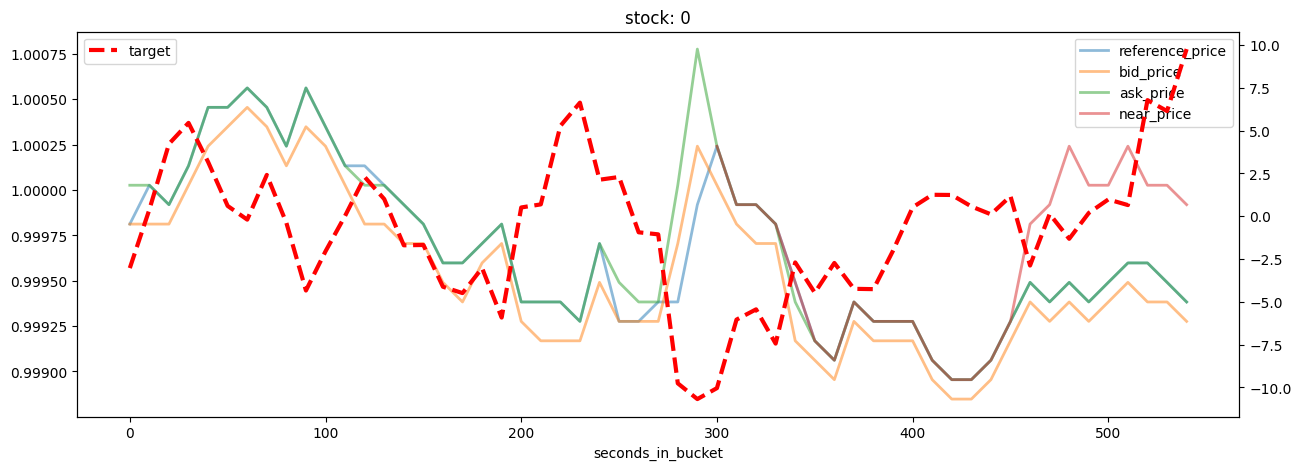

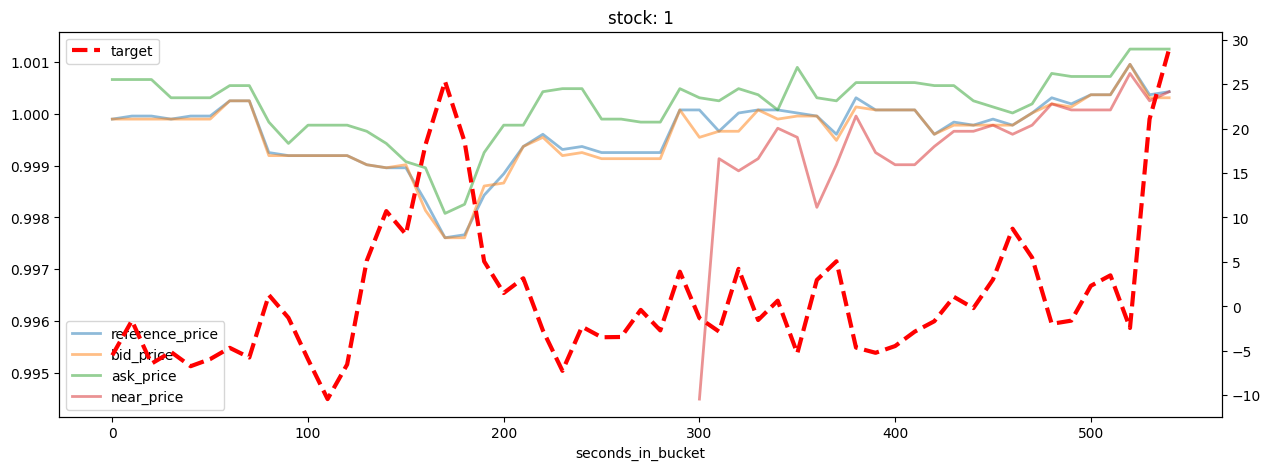

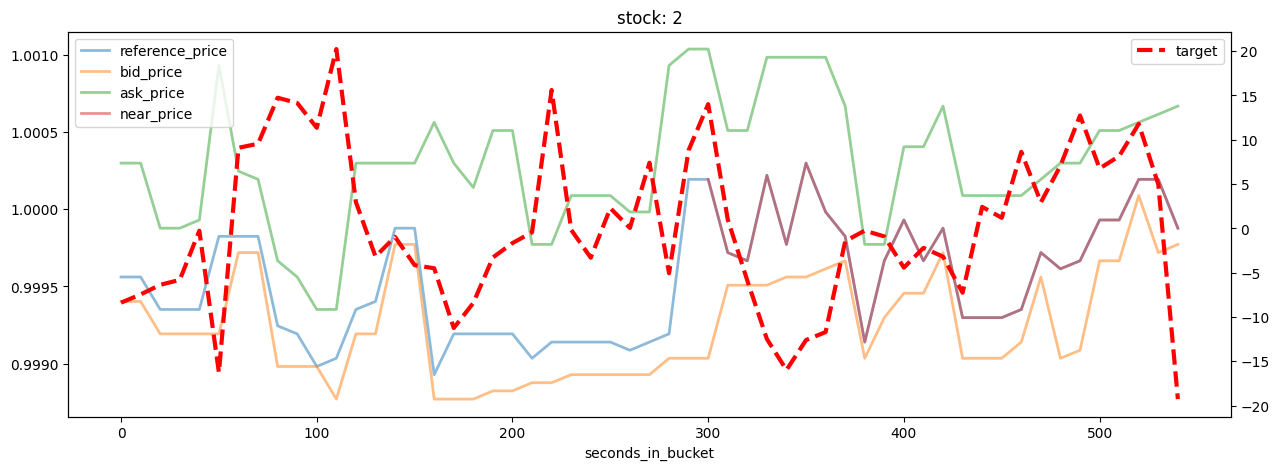

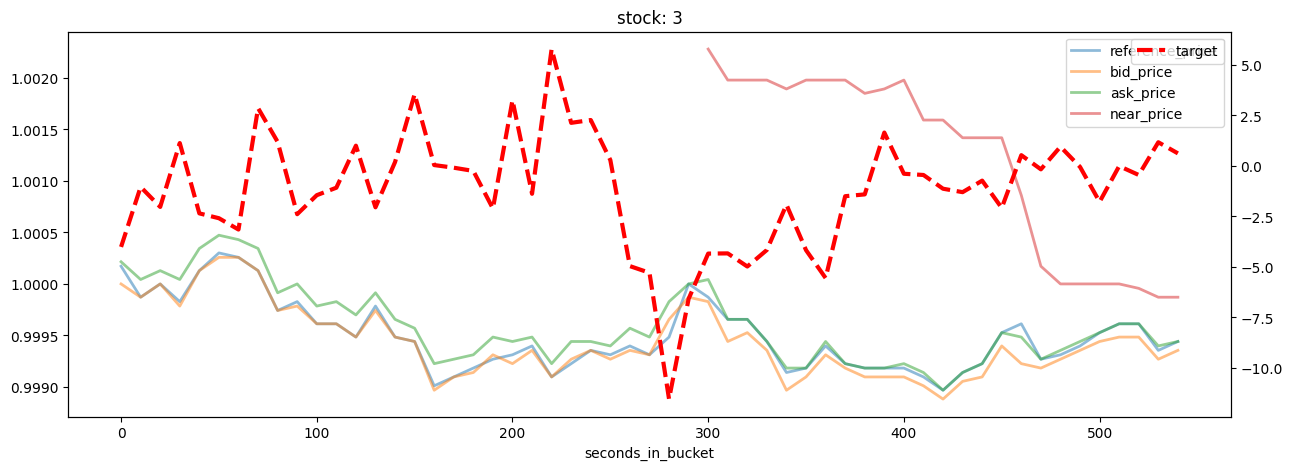

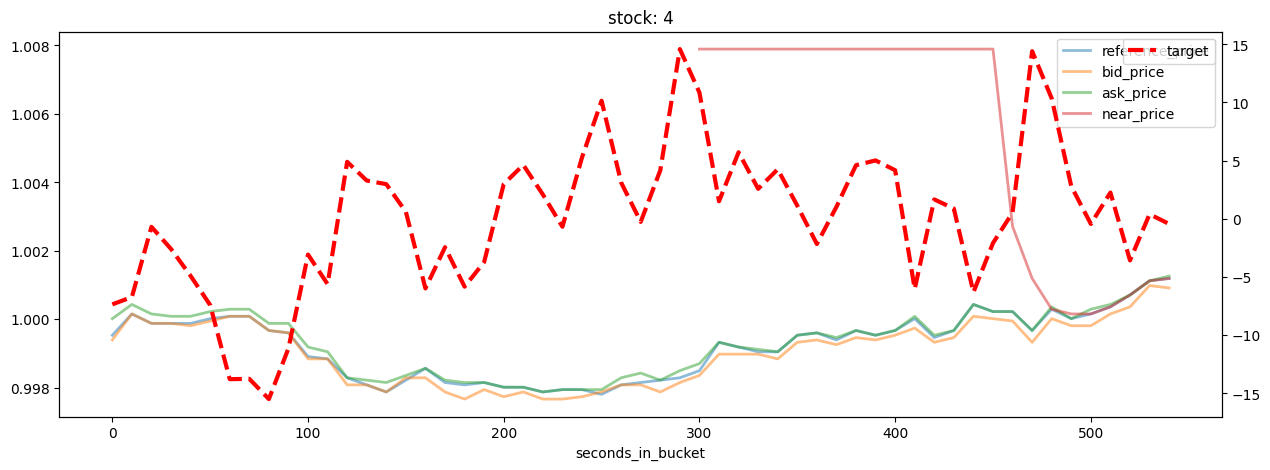

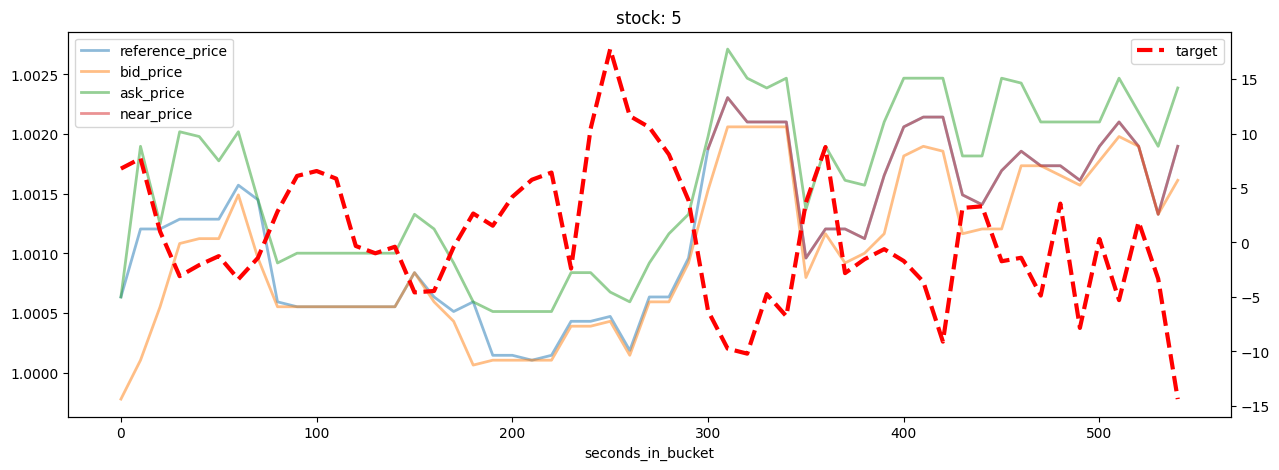

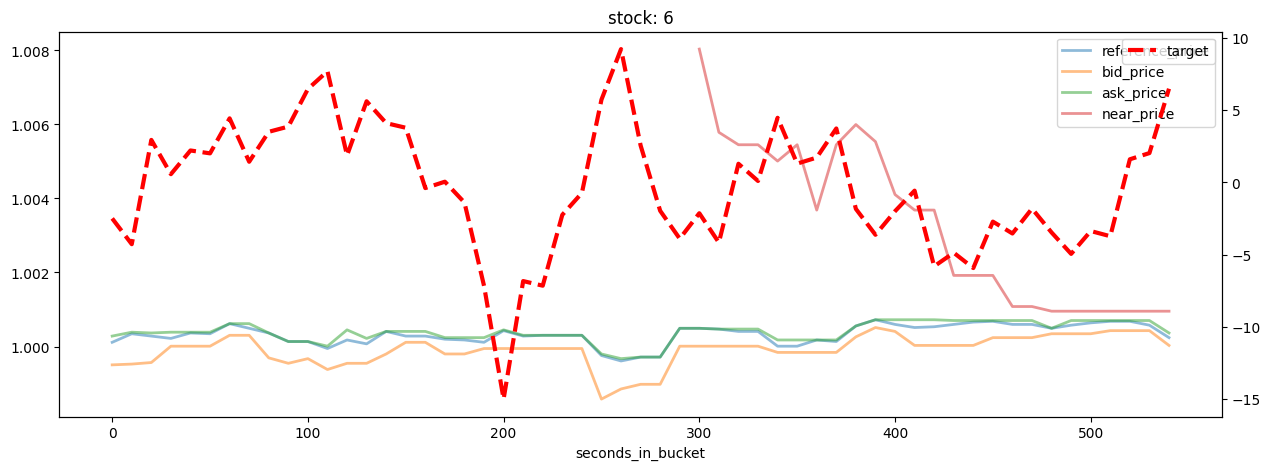

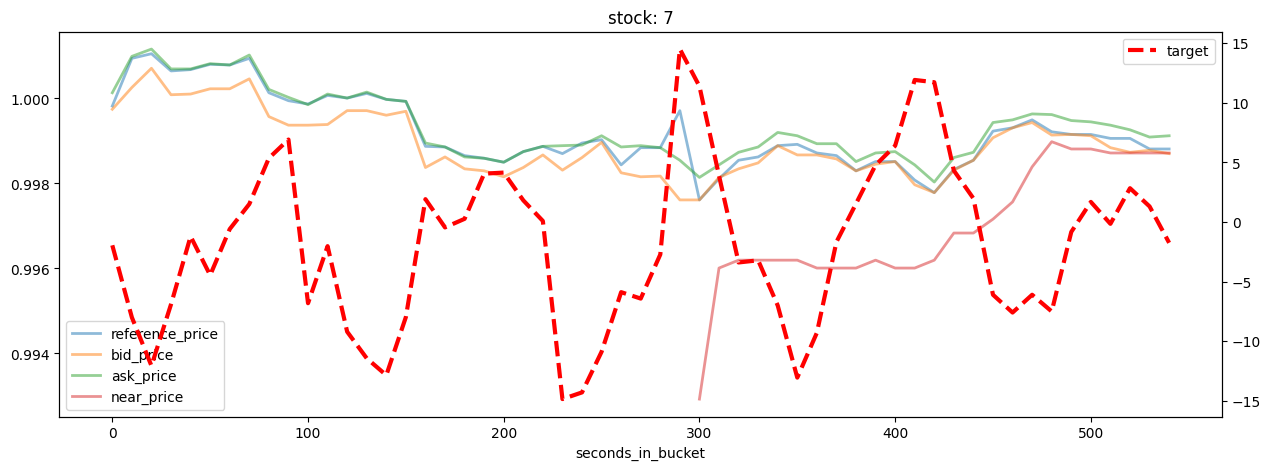

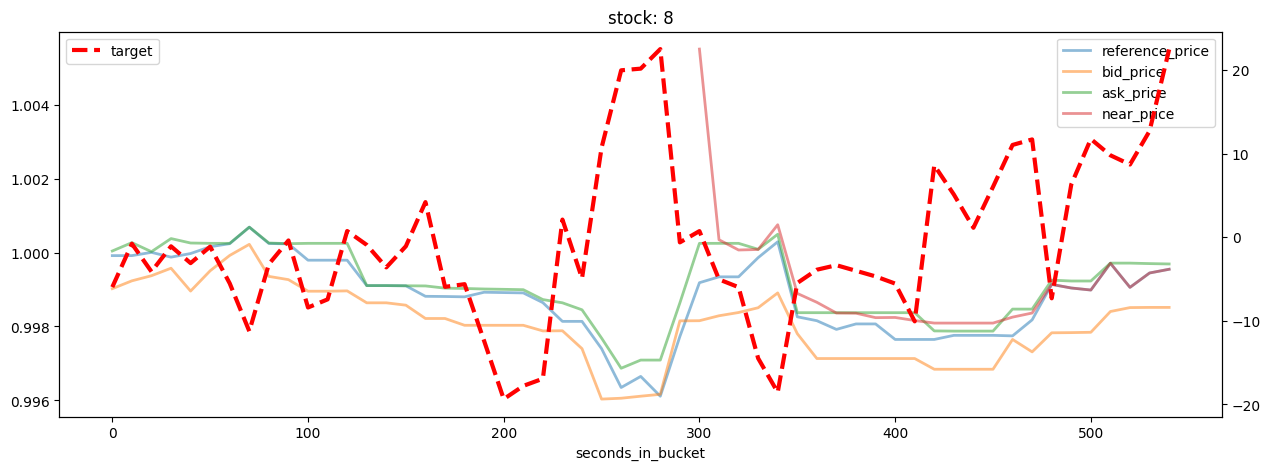

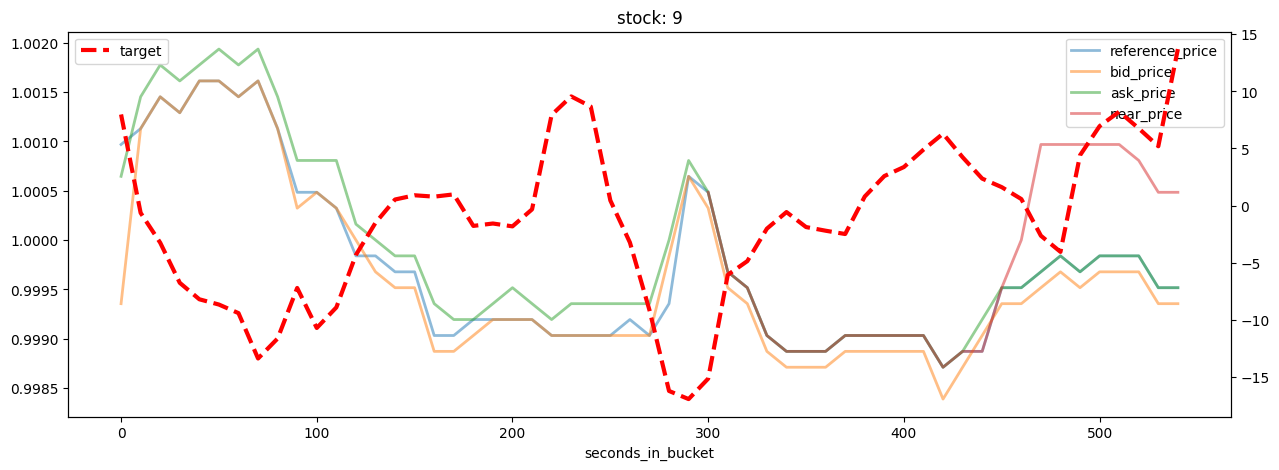

In [58]:
#reference ask and bid Price
count = 0 
for stock_id , data in df.groupby('stock_id'):
    fig , axs = plt.subplots(figsize = (15,5))
    data.query('date_id == 0').set_index('seconds_in_bucket')[['reference_price','bid_price','ask_price','near_price']].plot(ax = axs, title = f"stock: {stock_id}", alpha = 0.5, lw = 2)
    ax2 = axs.twinx()
    data.query('date_id == 0').set_index('seconds_in_bucket')[['target']].plot(ax = ax2, color = "red", ls = '--',lw = 3)
    plt.show()
    count+=1
    if count == 10:
        break
    

    The near and far price which are extimates of matched price are availabele only after 290 seconds so we can make as they are given by optiver , The imputation of these values do not make sense so we can train separate models for time 0 to 290 and 290 to above seperately
    or can impute the values by mean 

    Nearly the same trend is followed by all this prices

In [ ]:
permutations = list(itertools.permutations(float_cols, 2))
float_set = set()

for permutation in permutations:
    permutation_list = list(permutation)
    if permutation_list[0] != permutation_list[1]:
        sorted_permutation = frozenset(sorted(permutation_list))
        float_set.add(sorted_permutation)

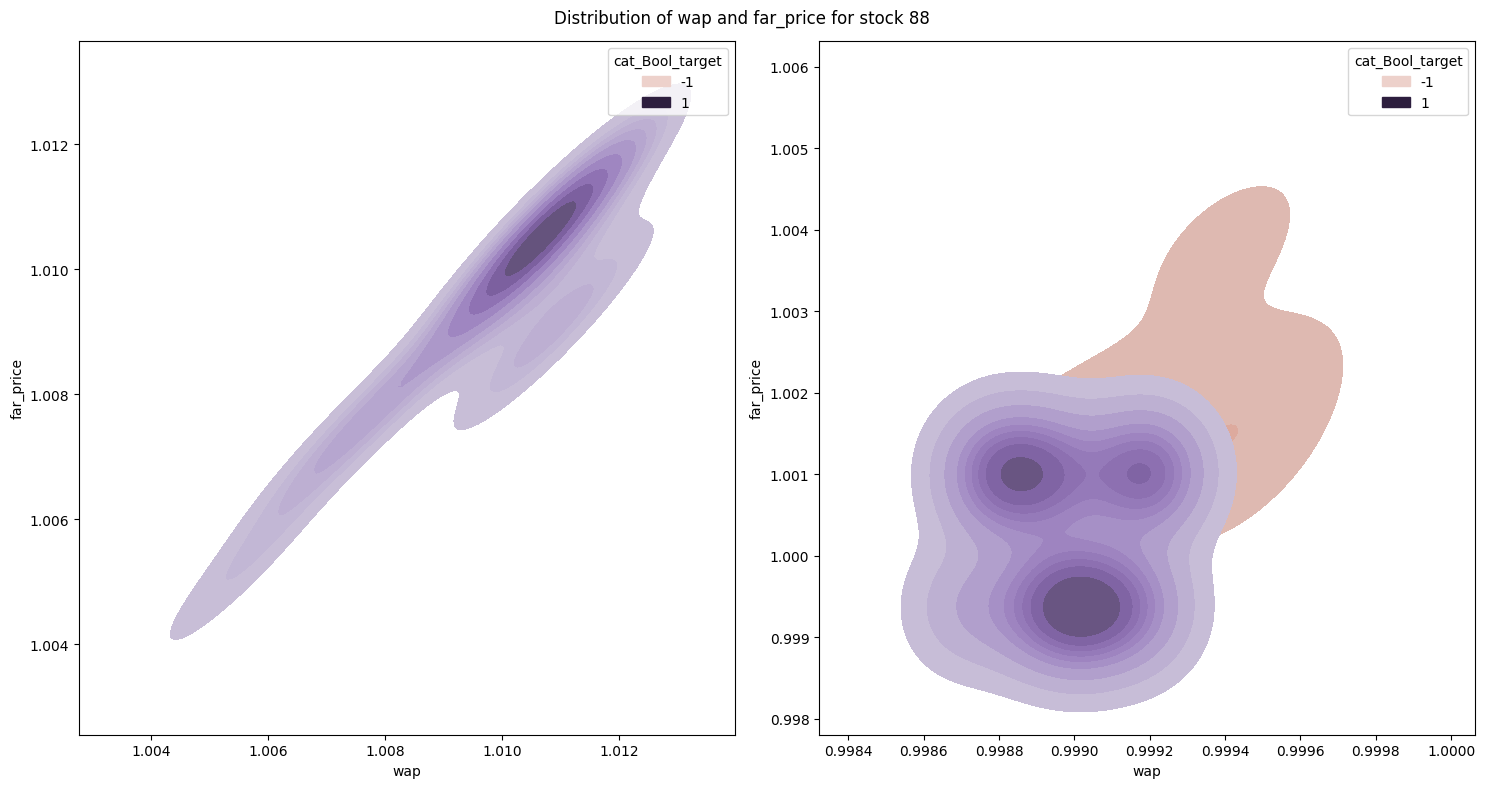

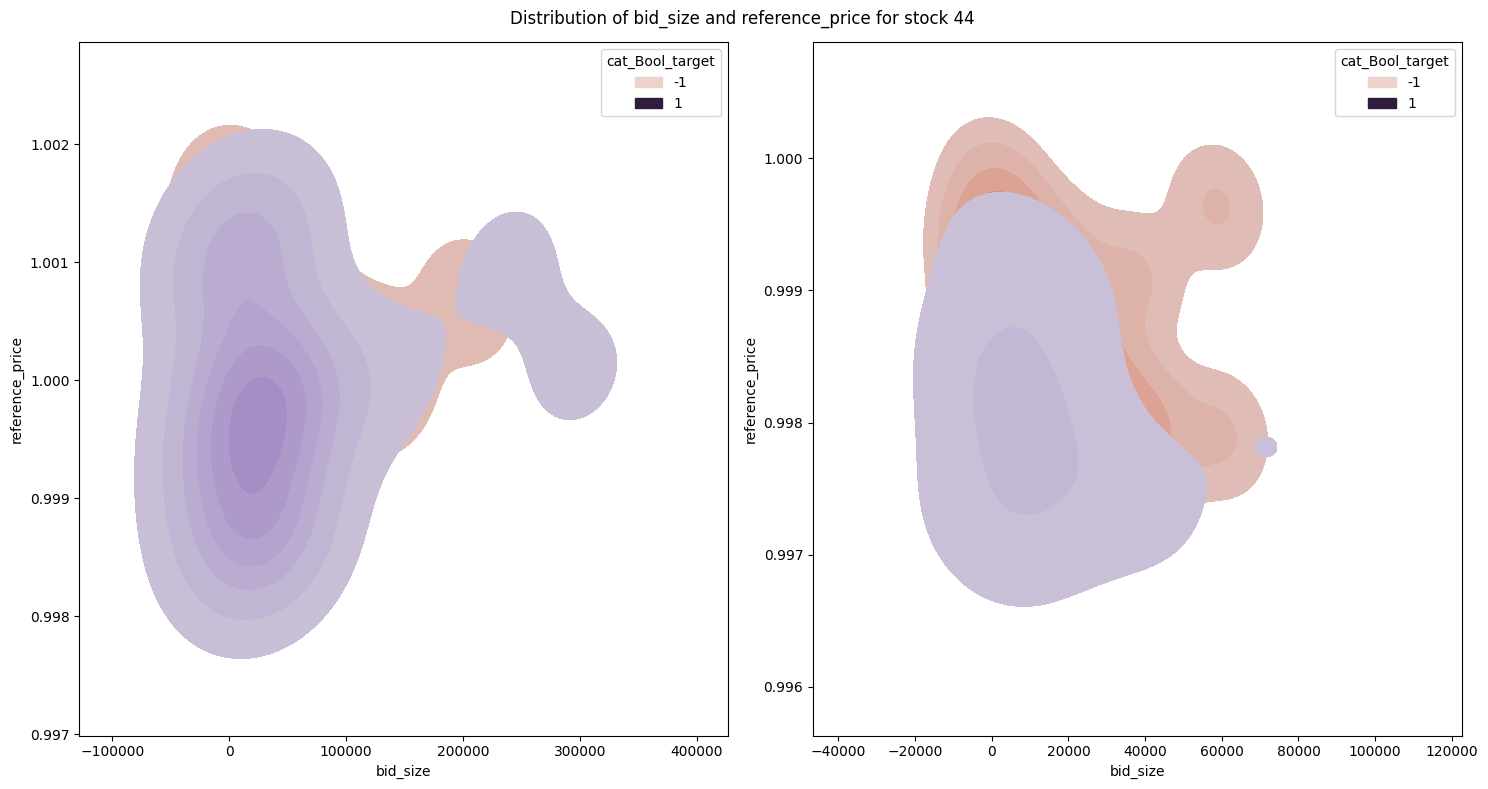

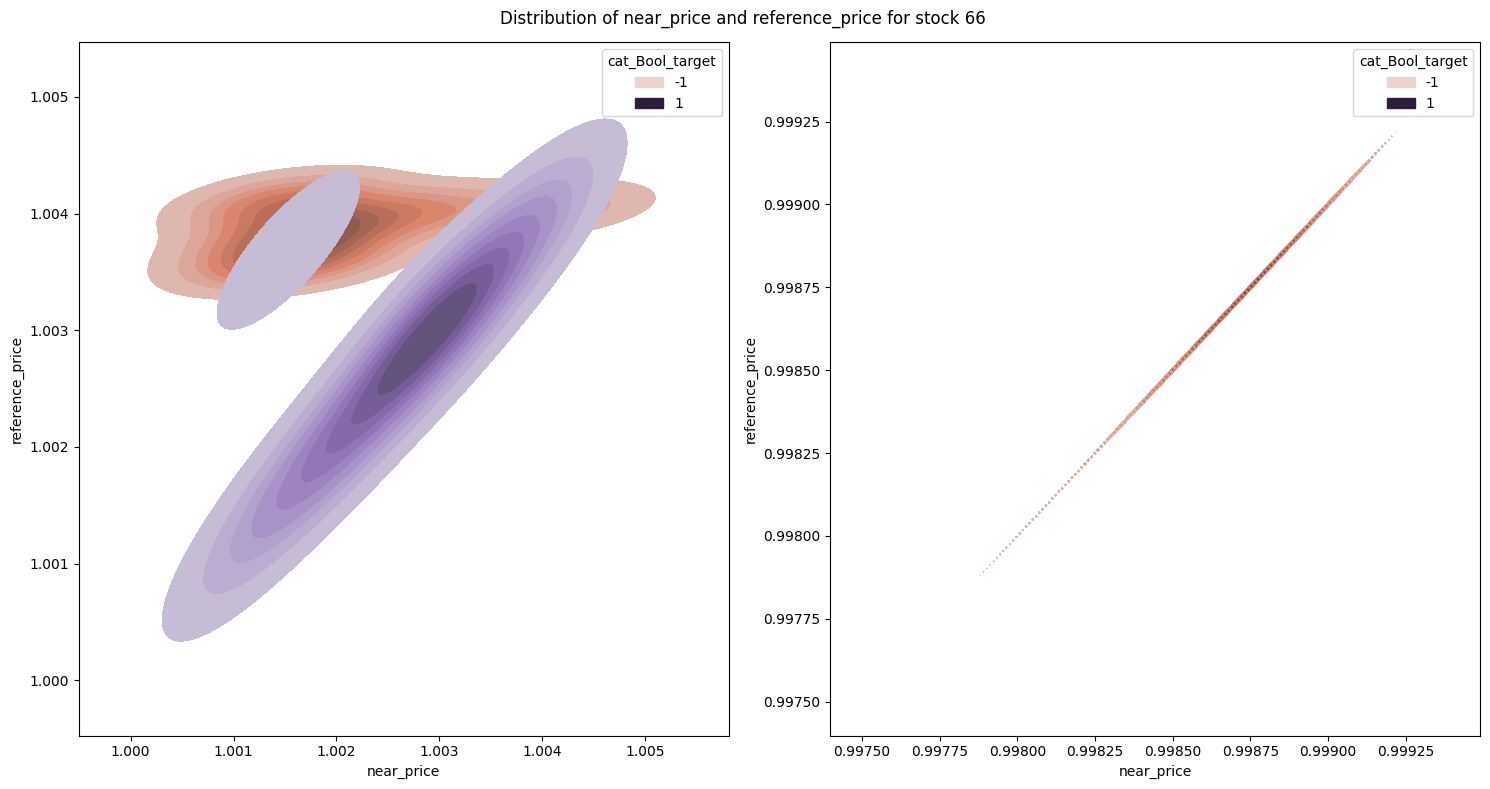

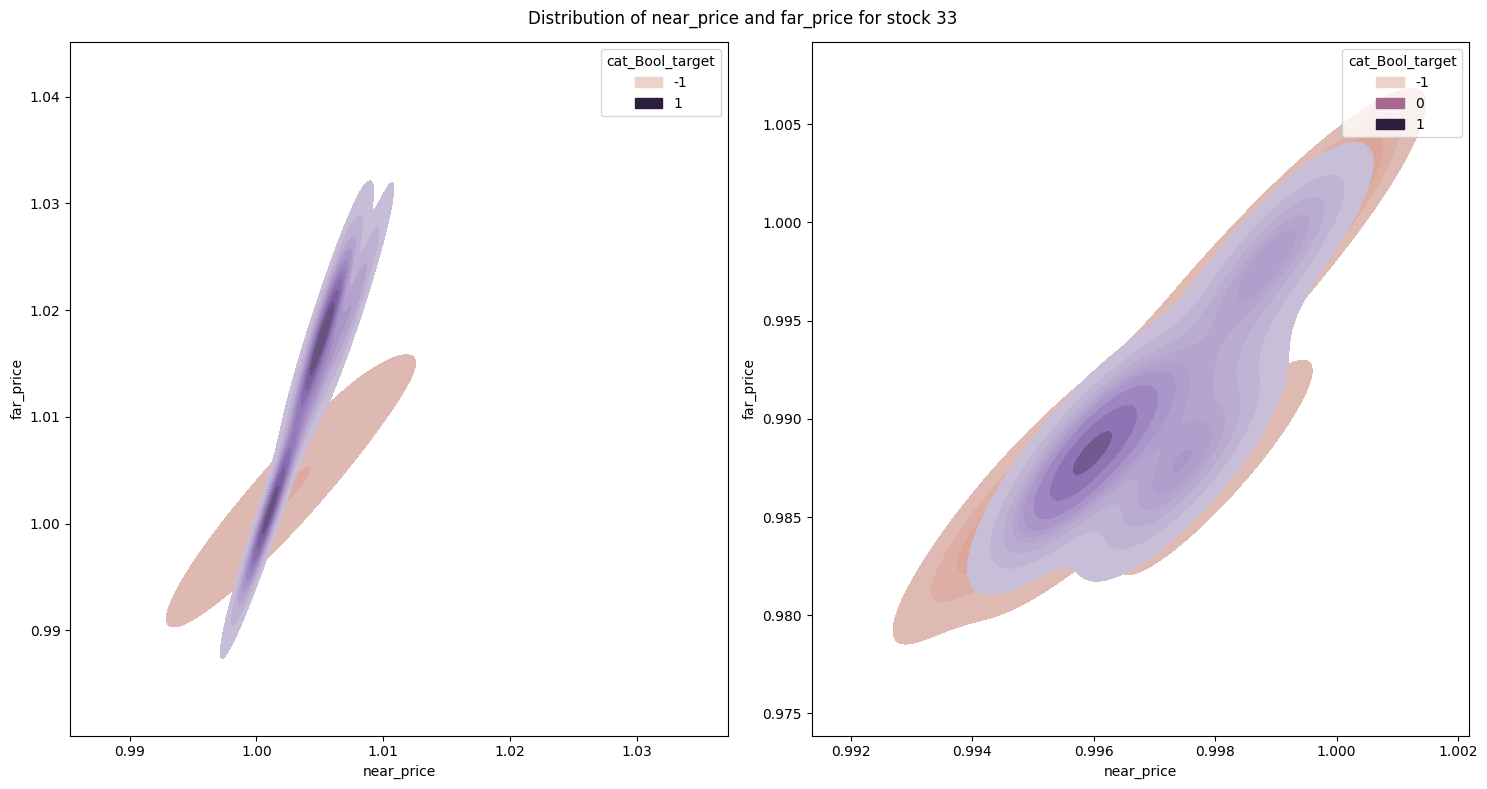

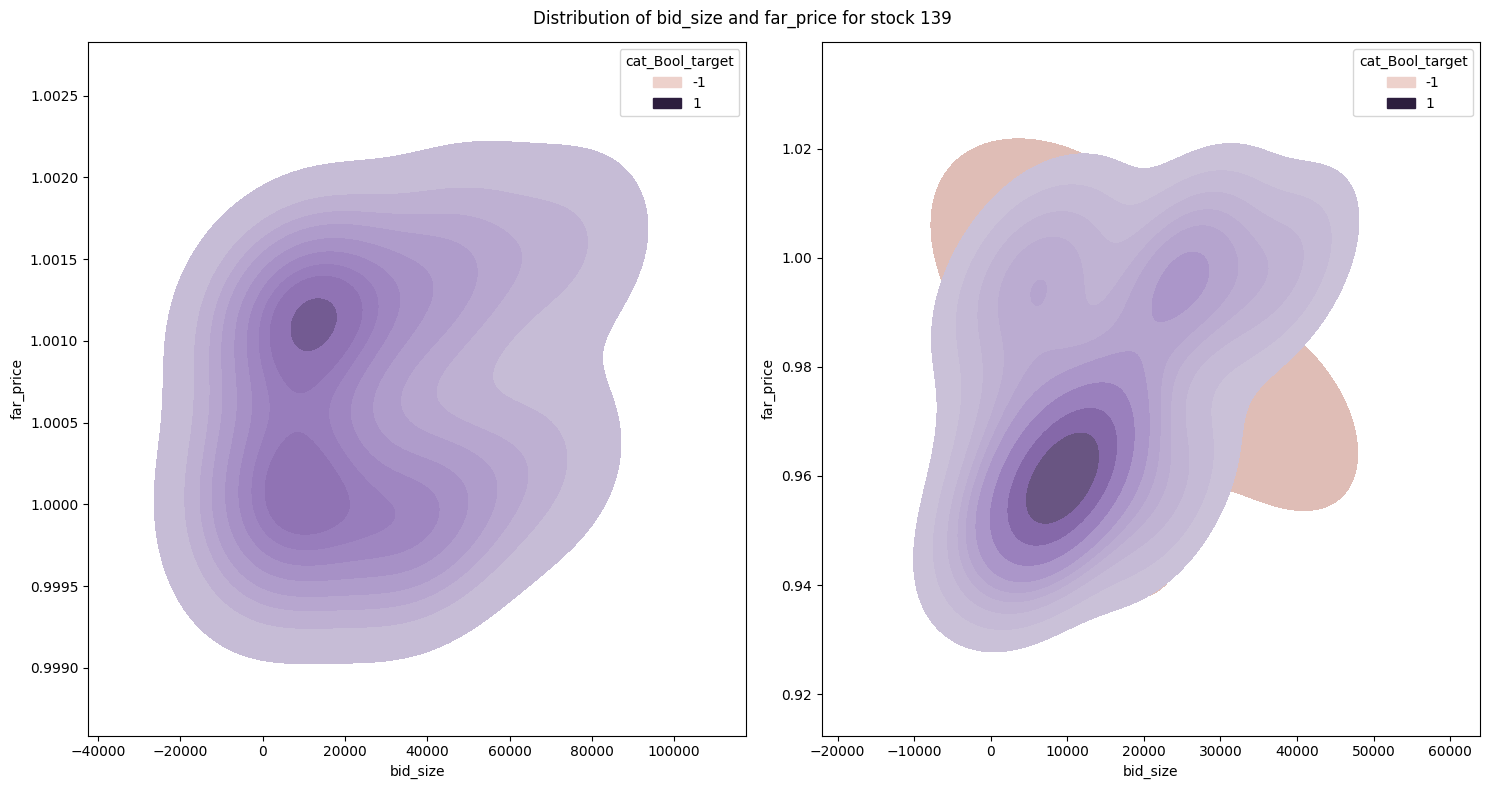

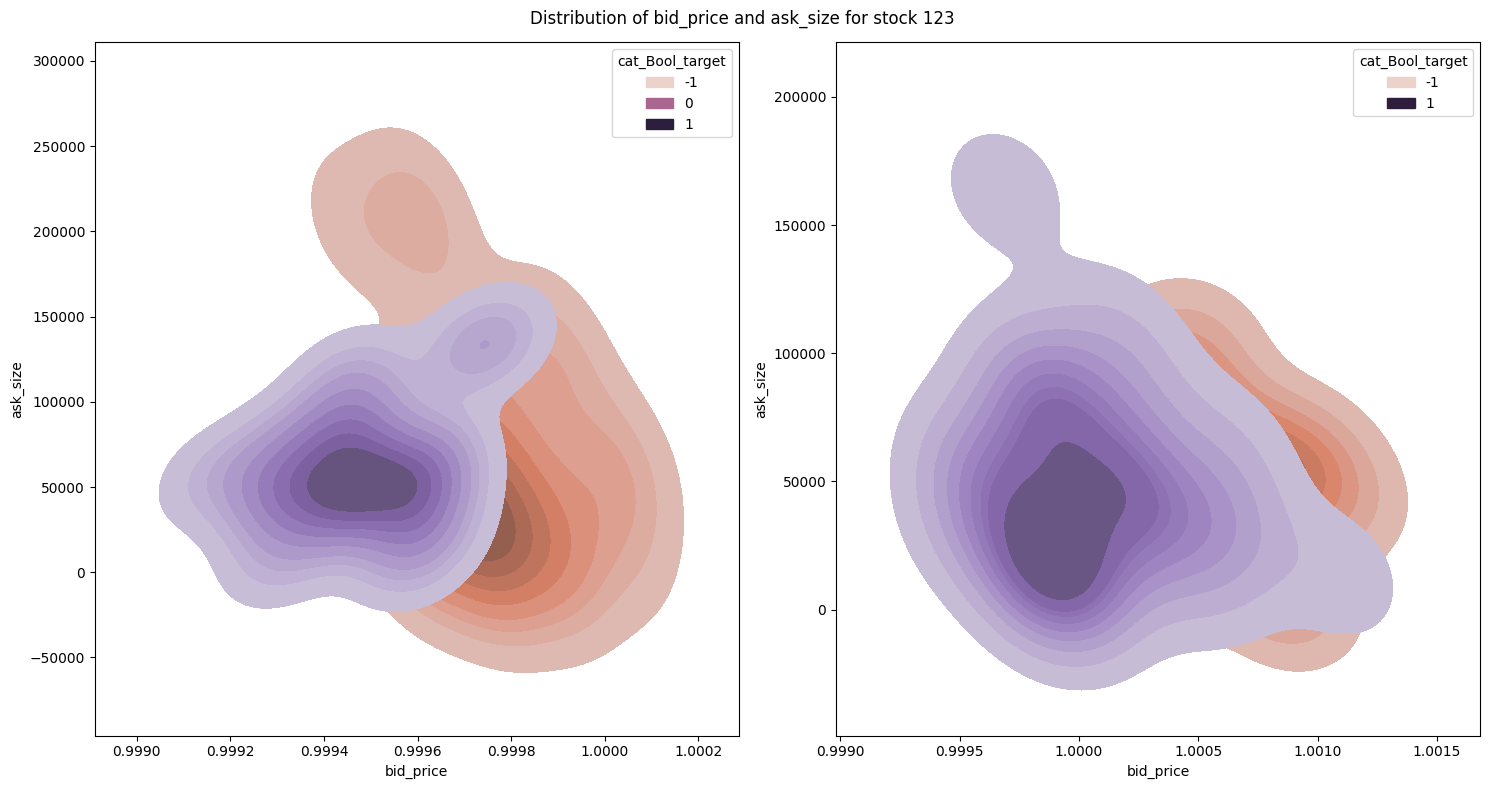

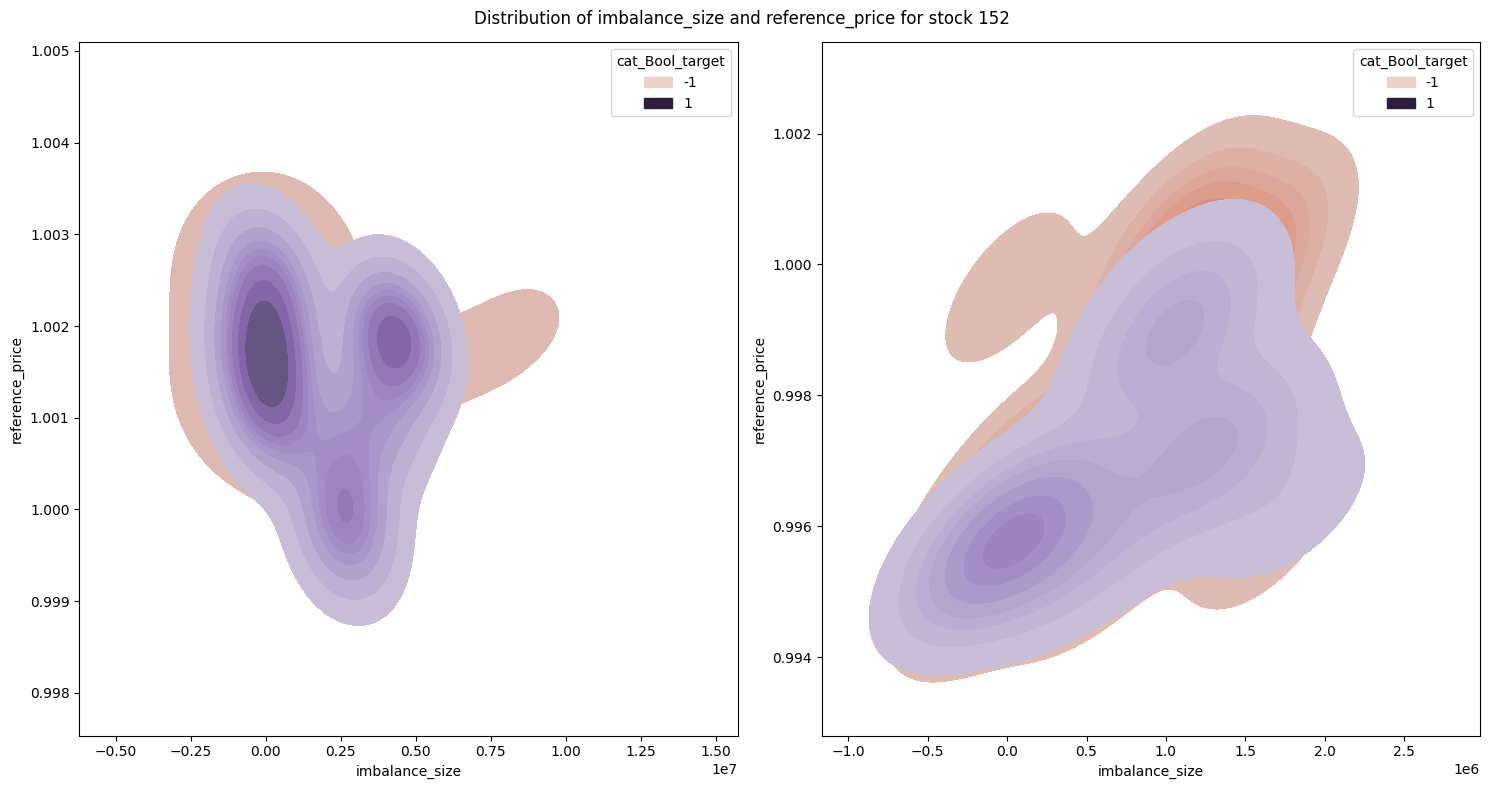

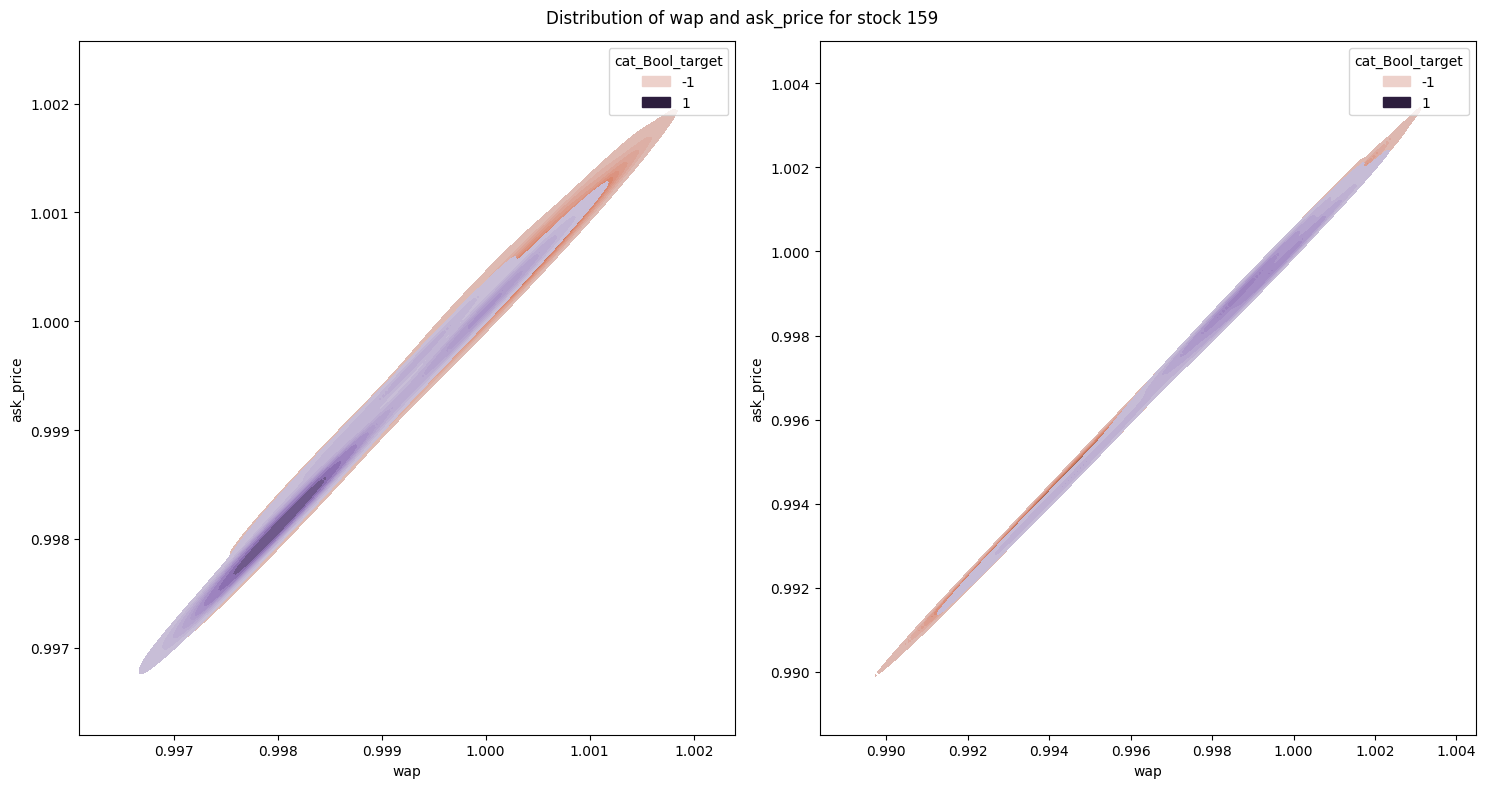

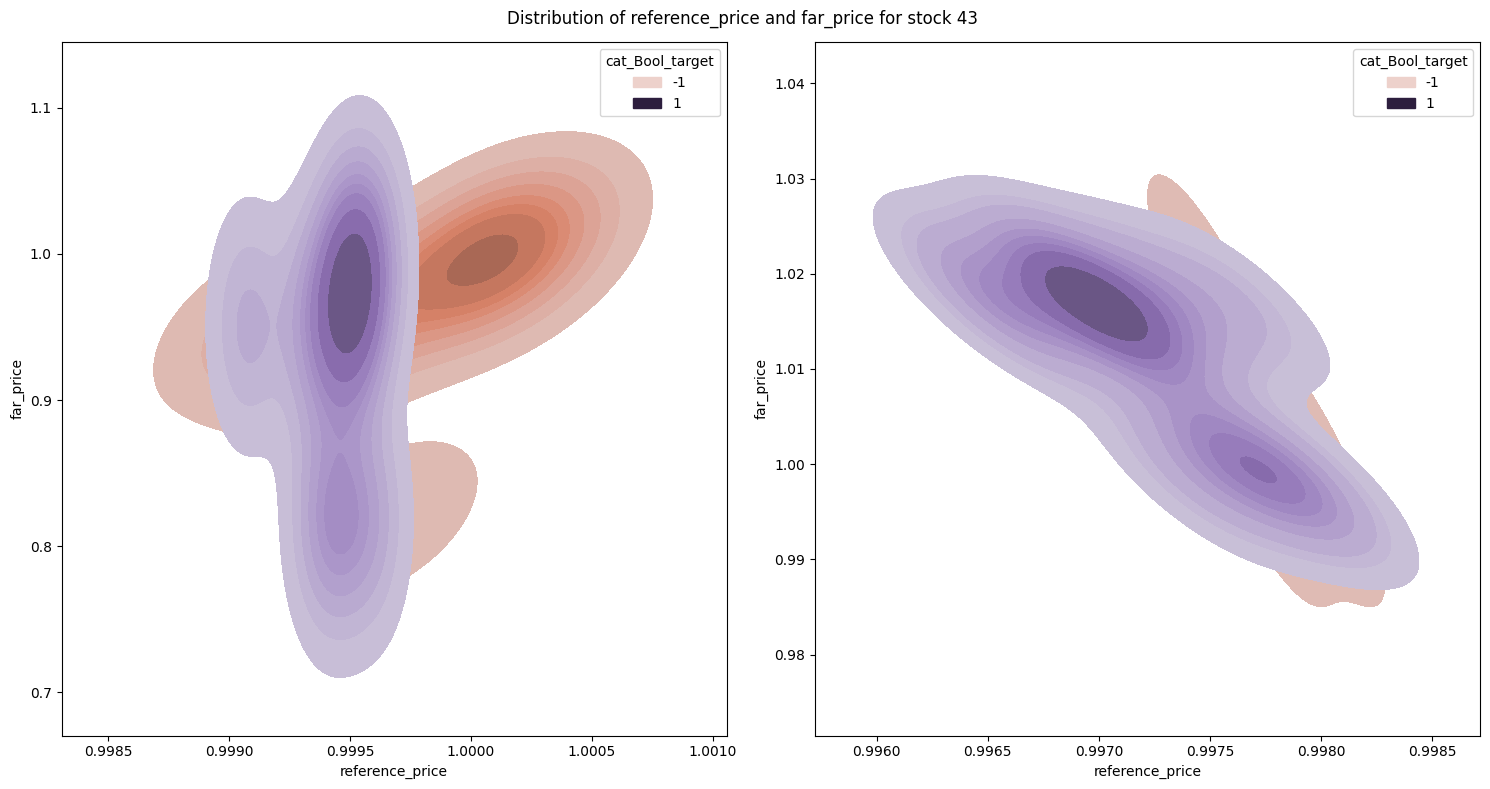

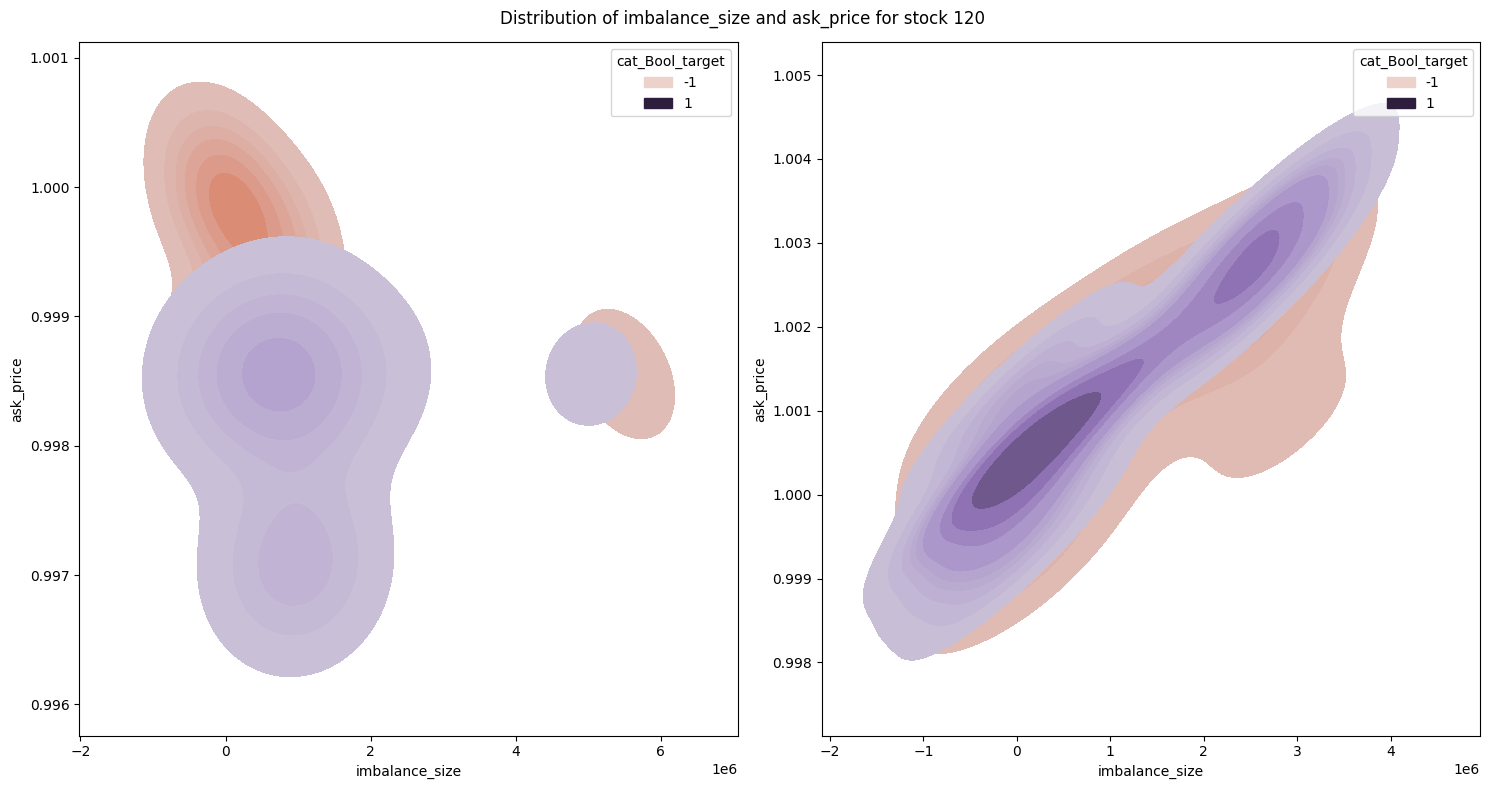

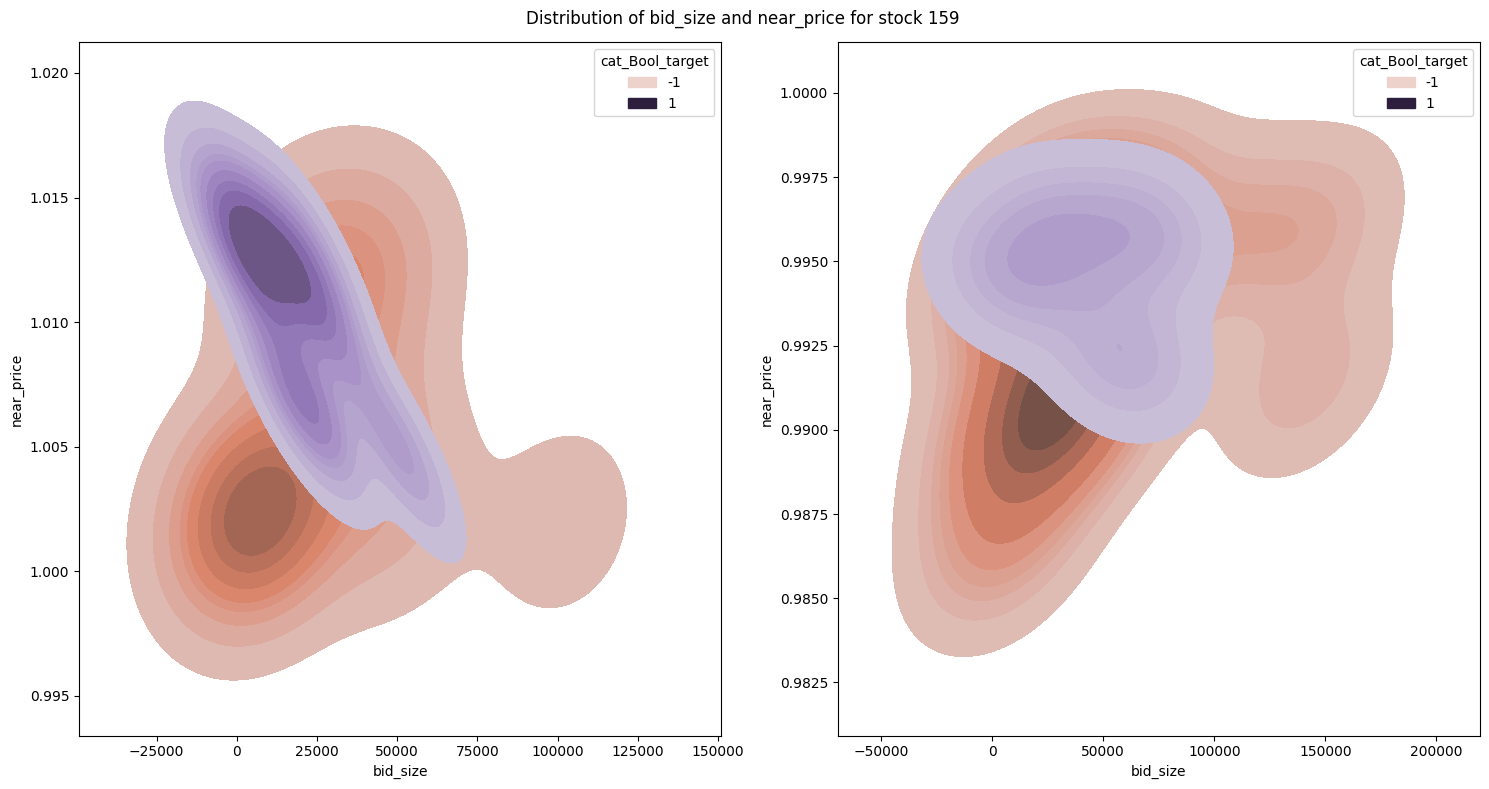

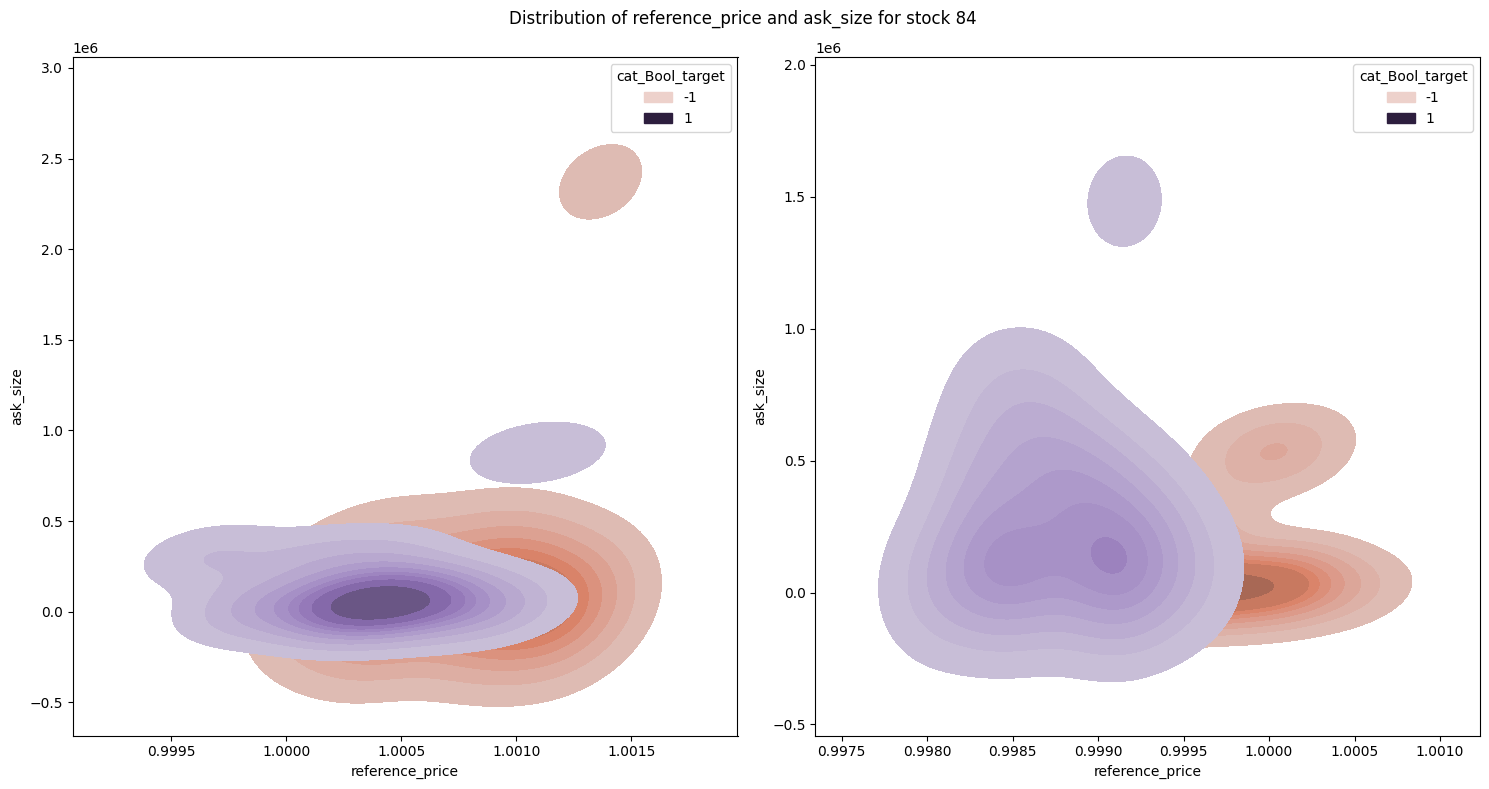

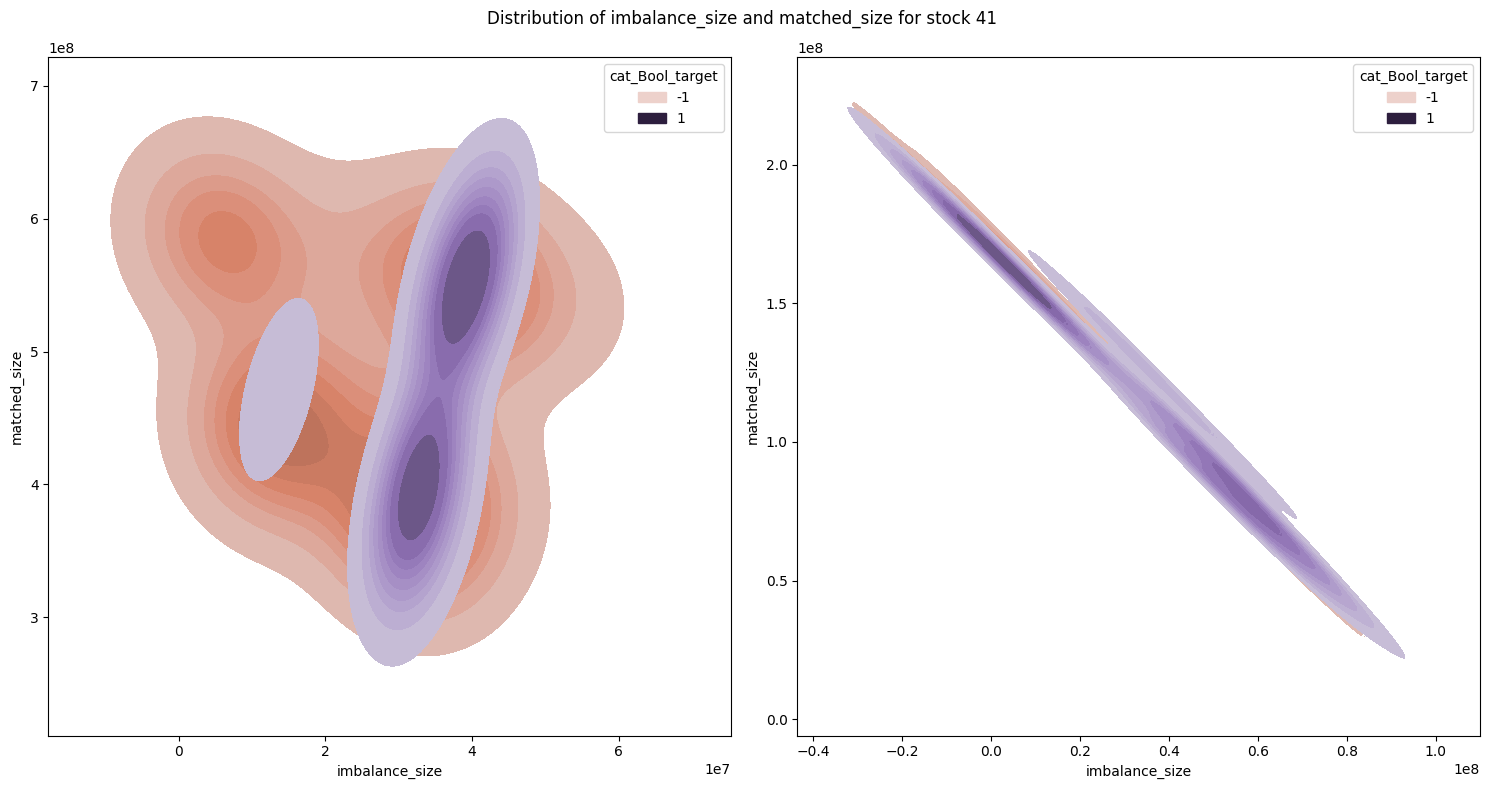

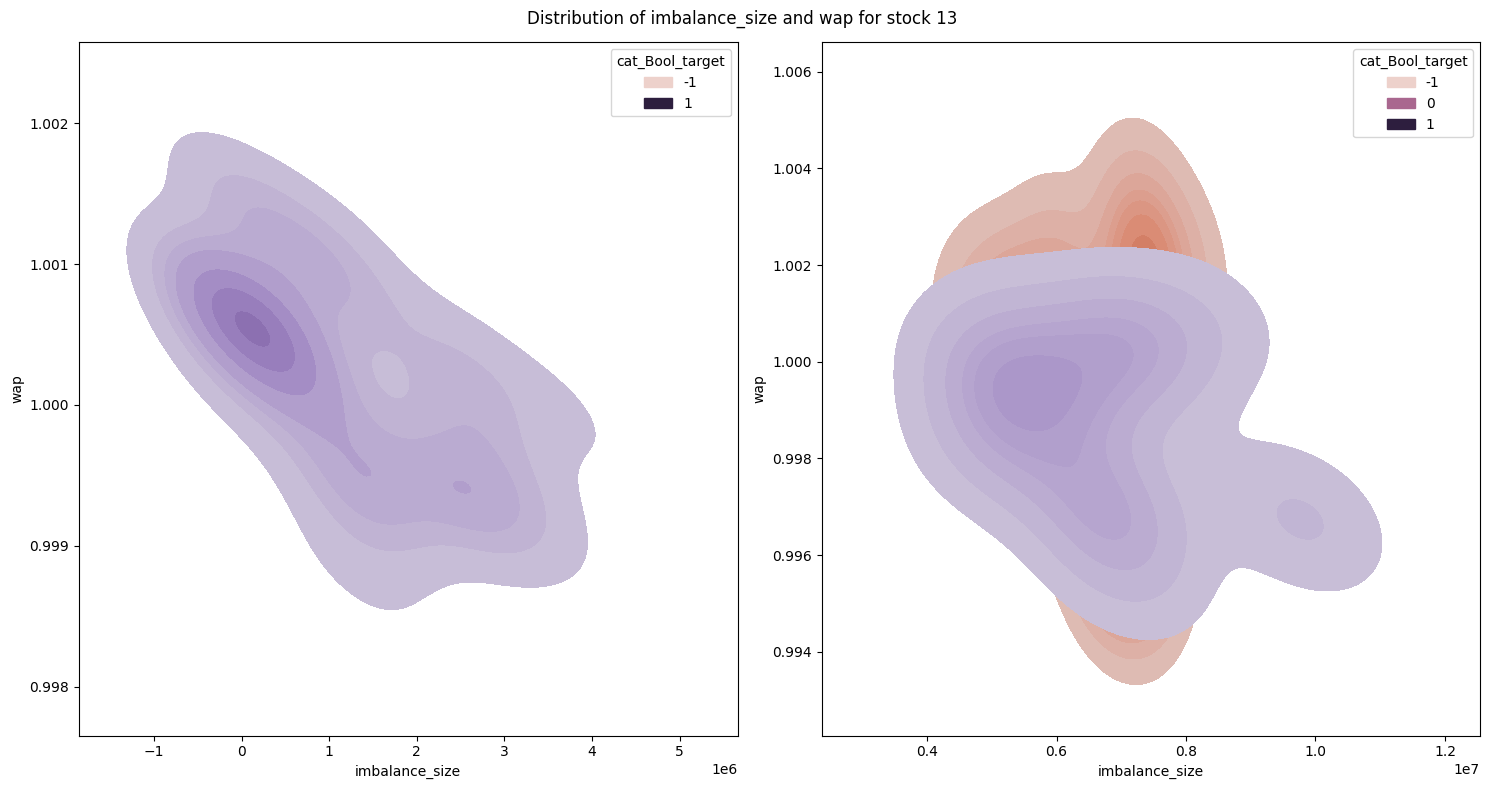

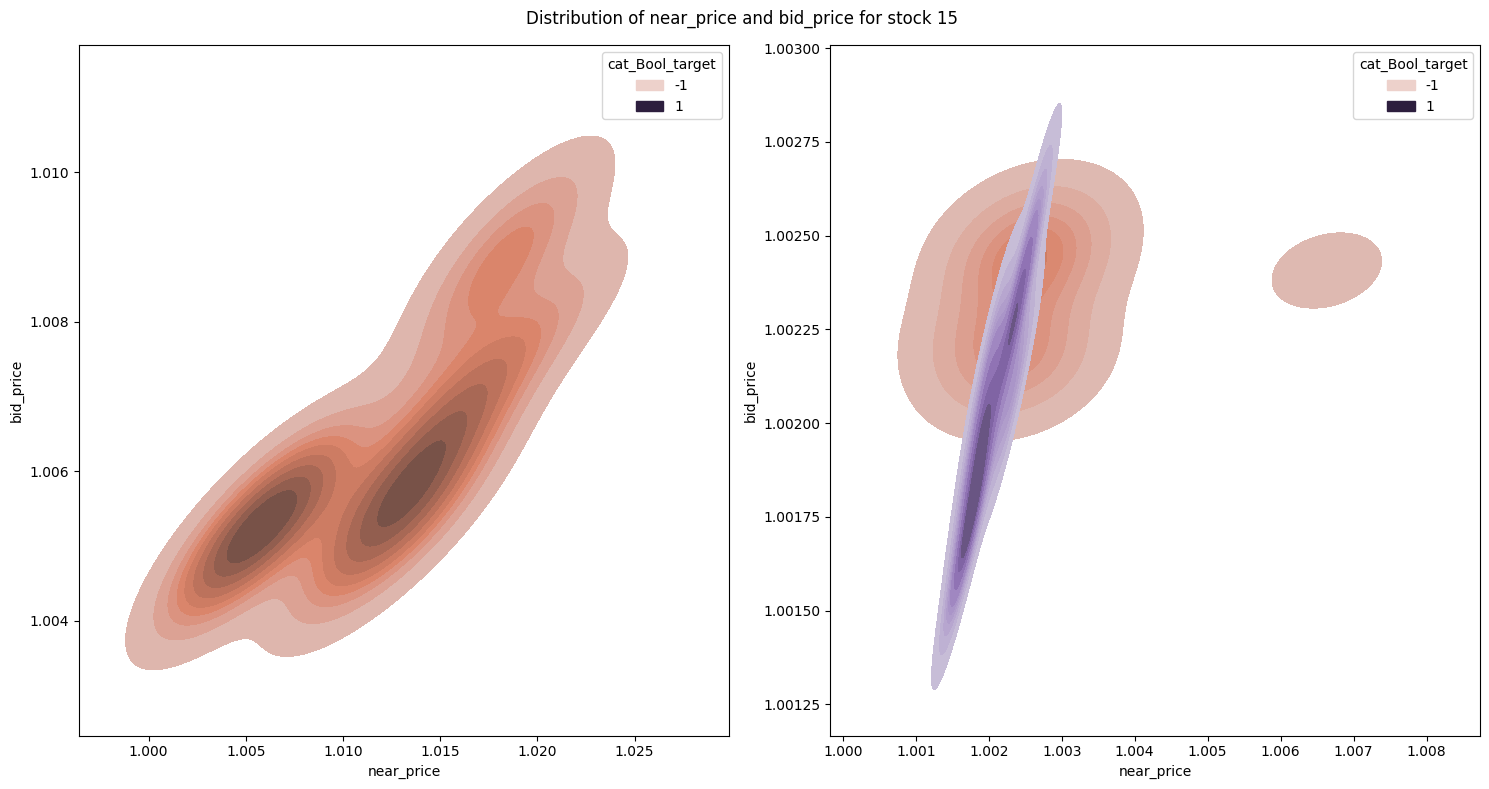

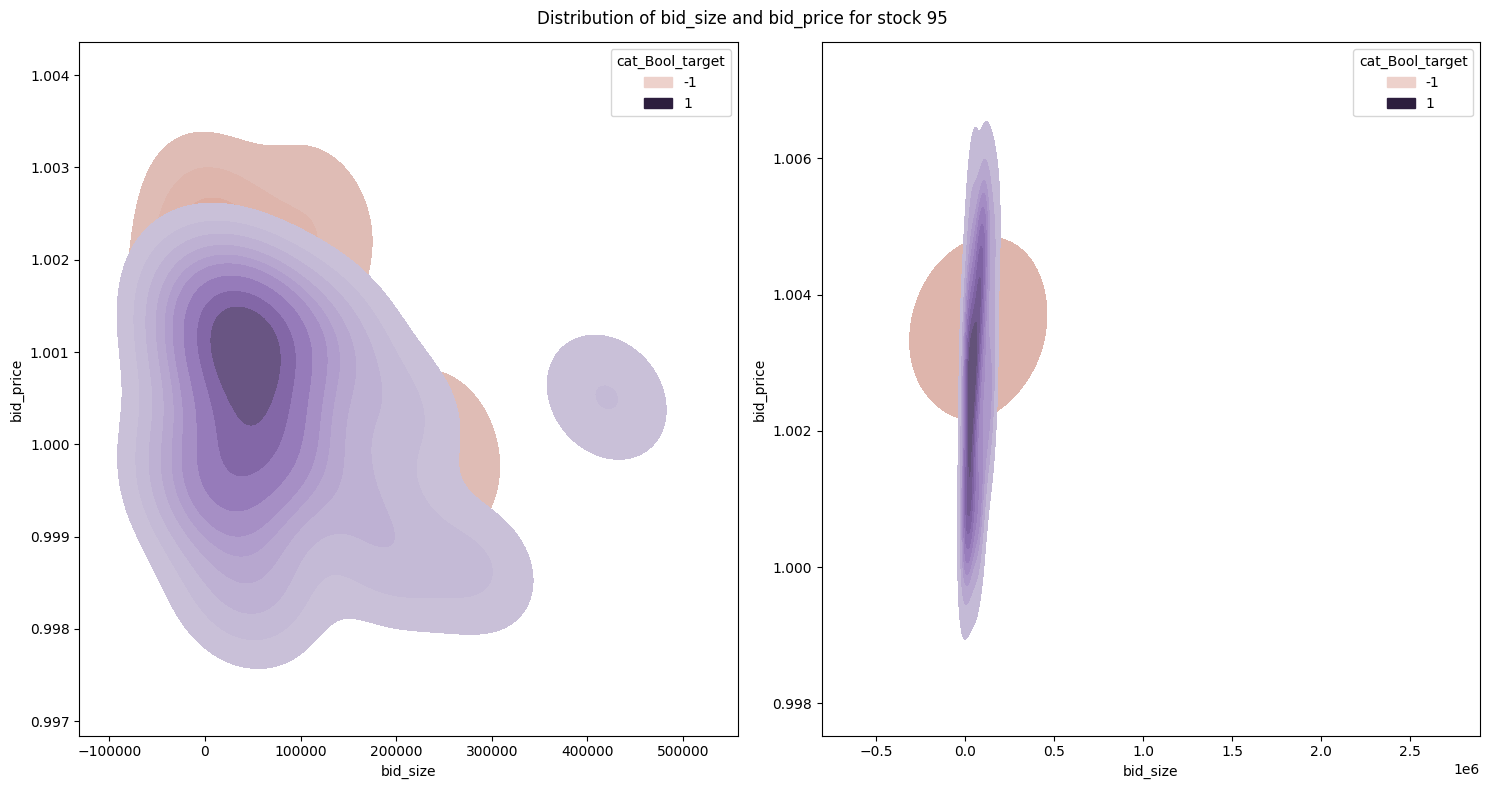

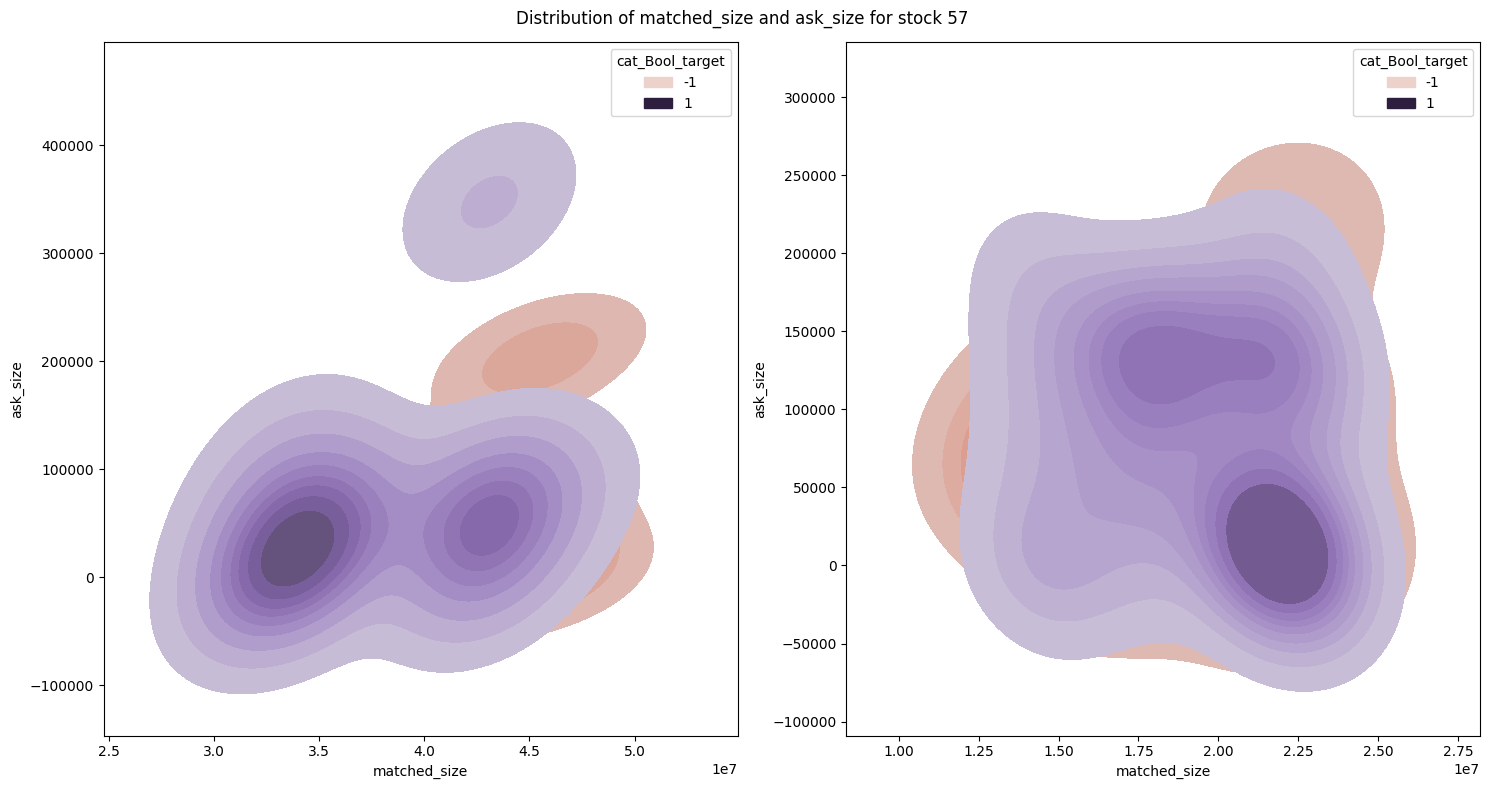

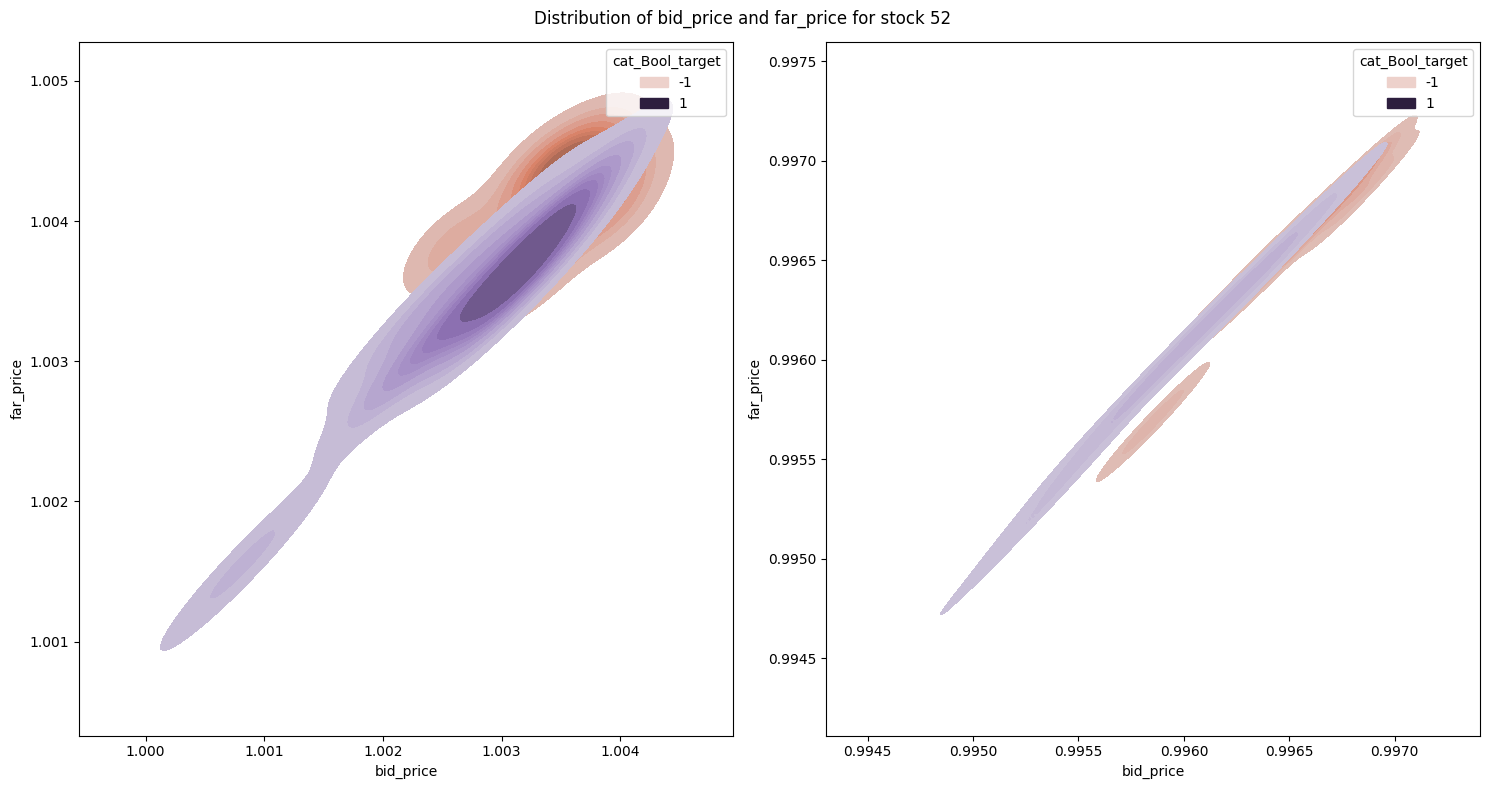

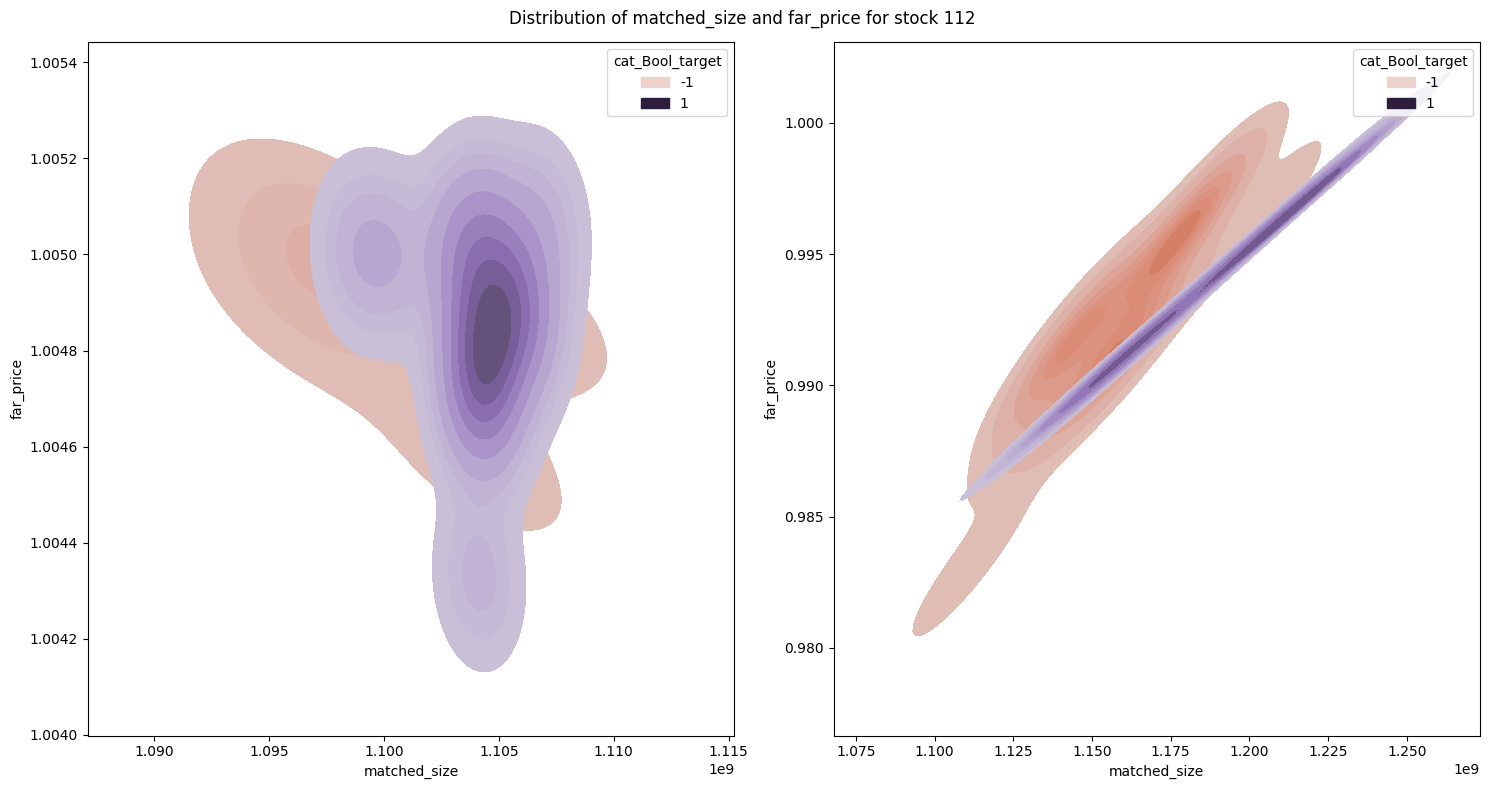

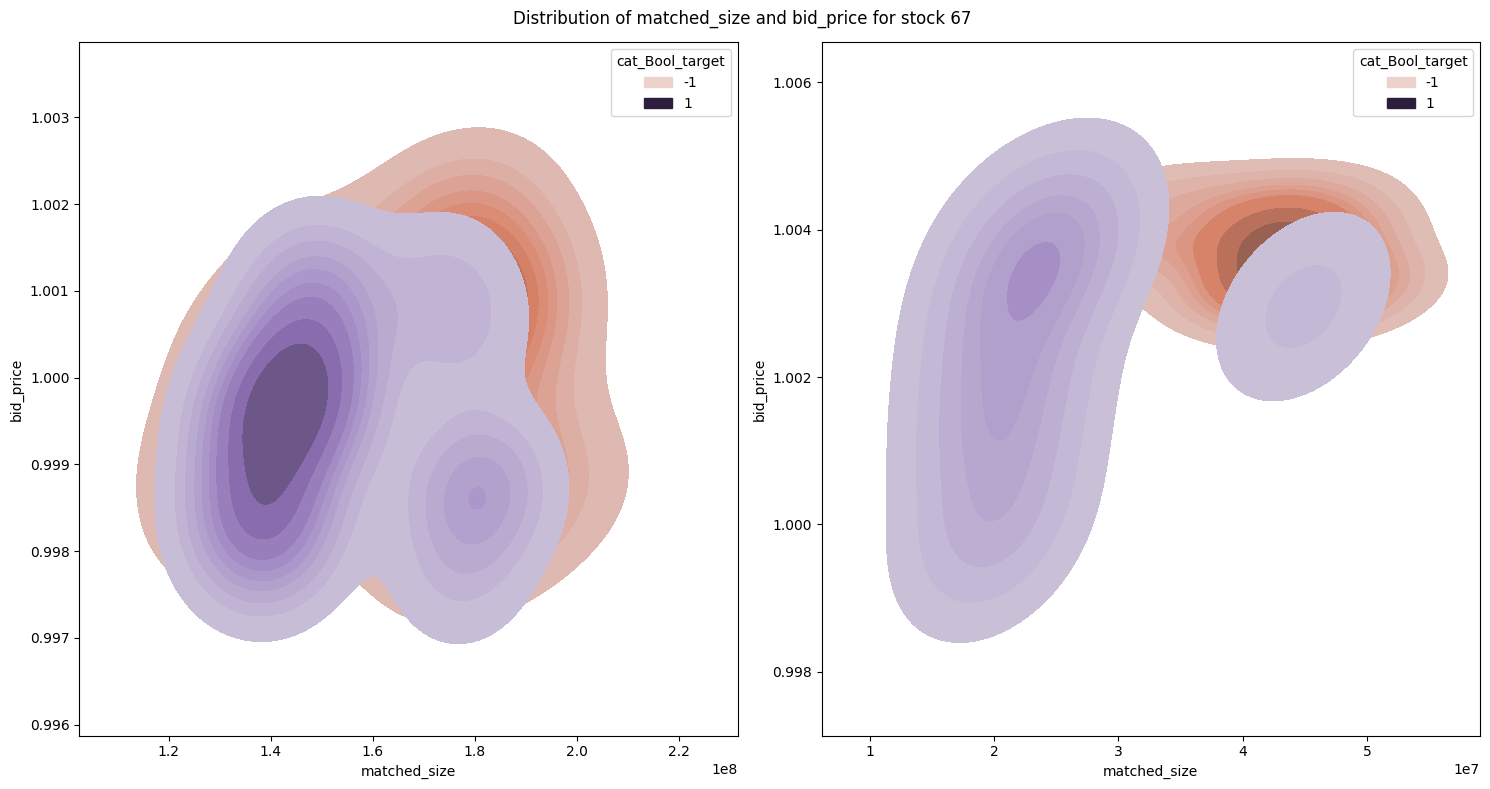

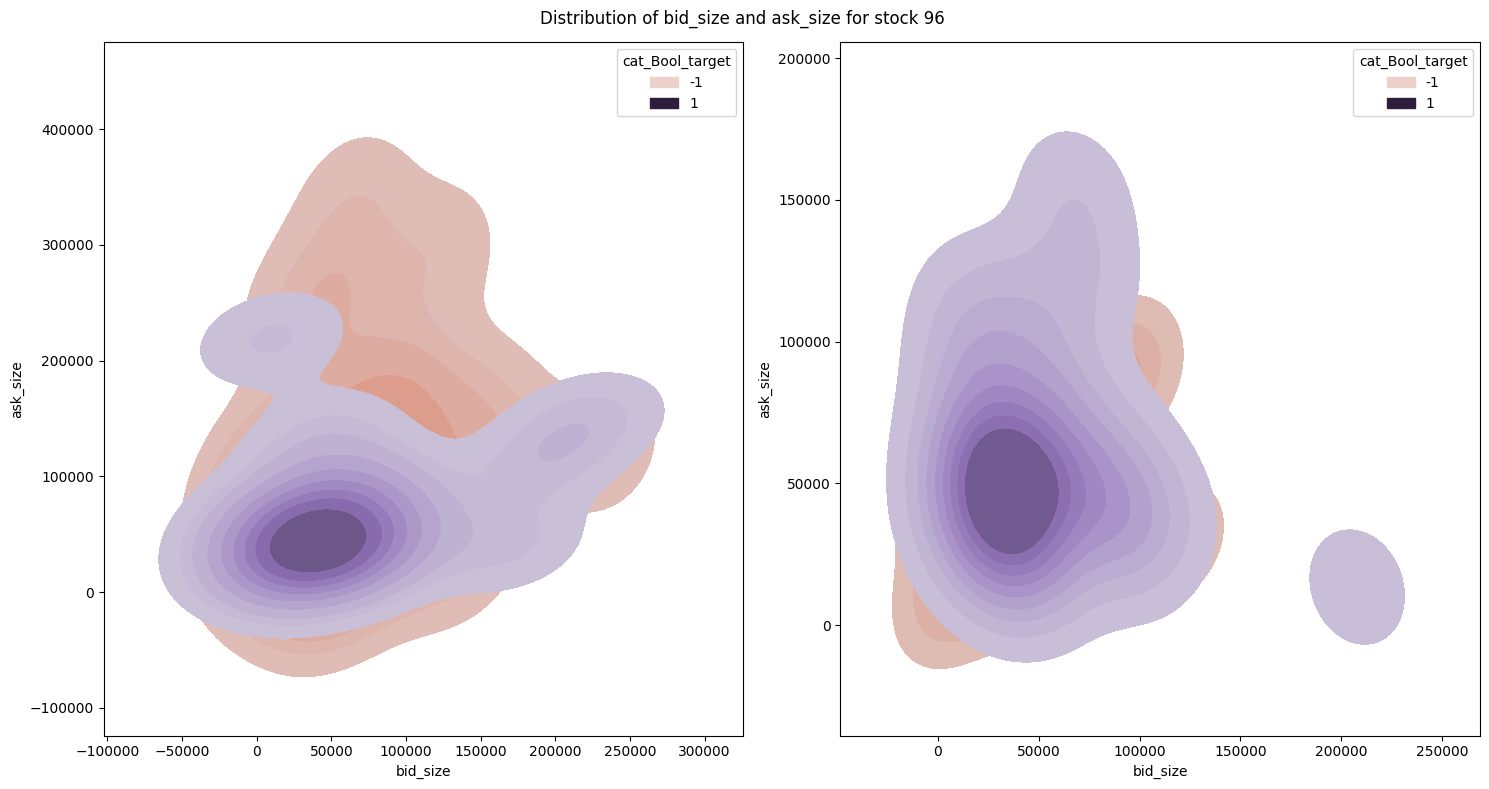

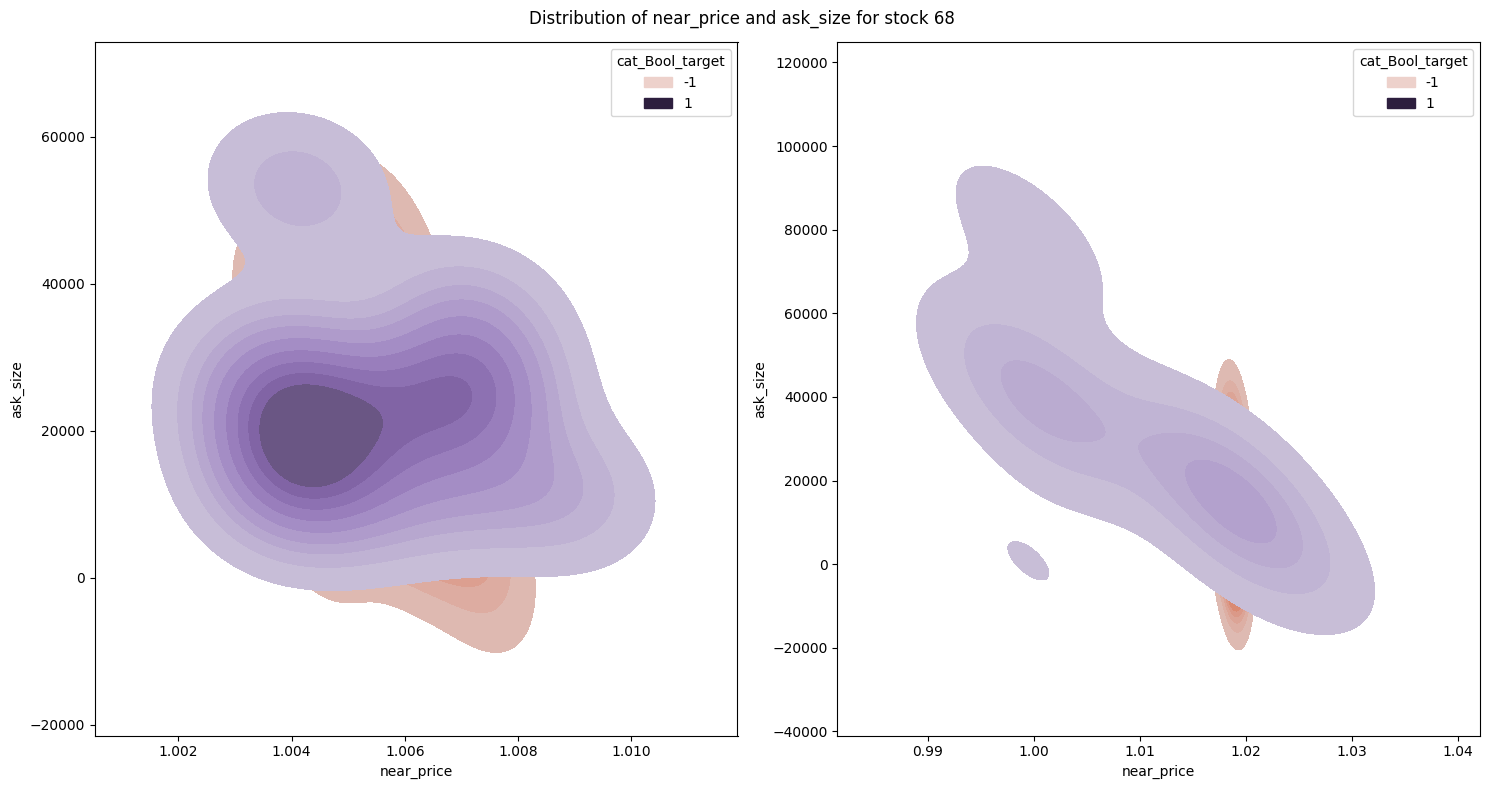

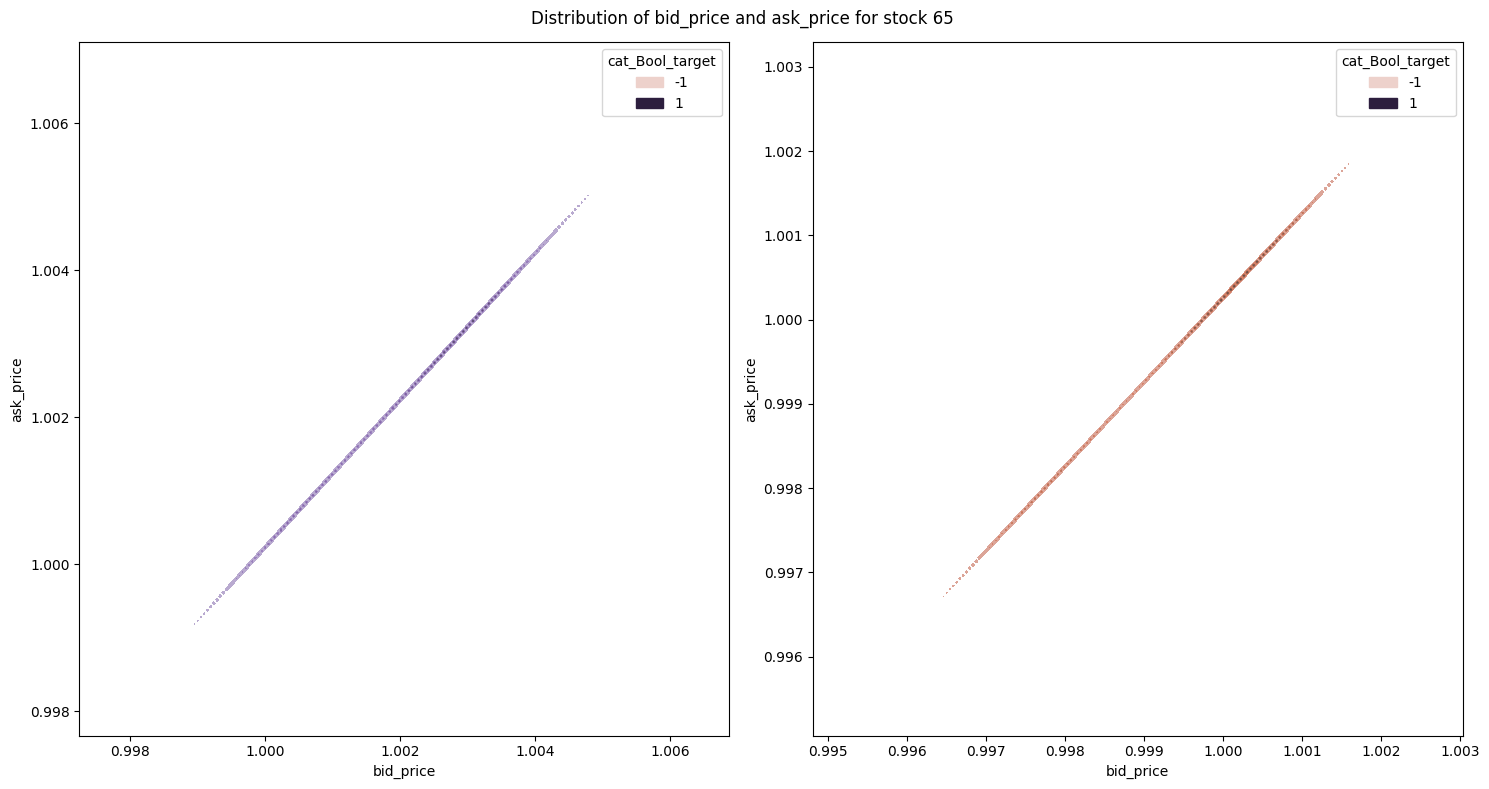

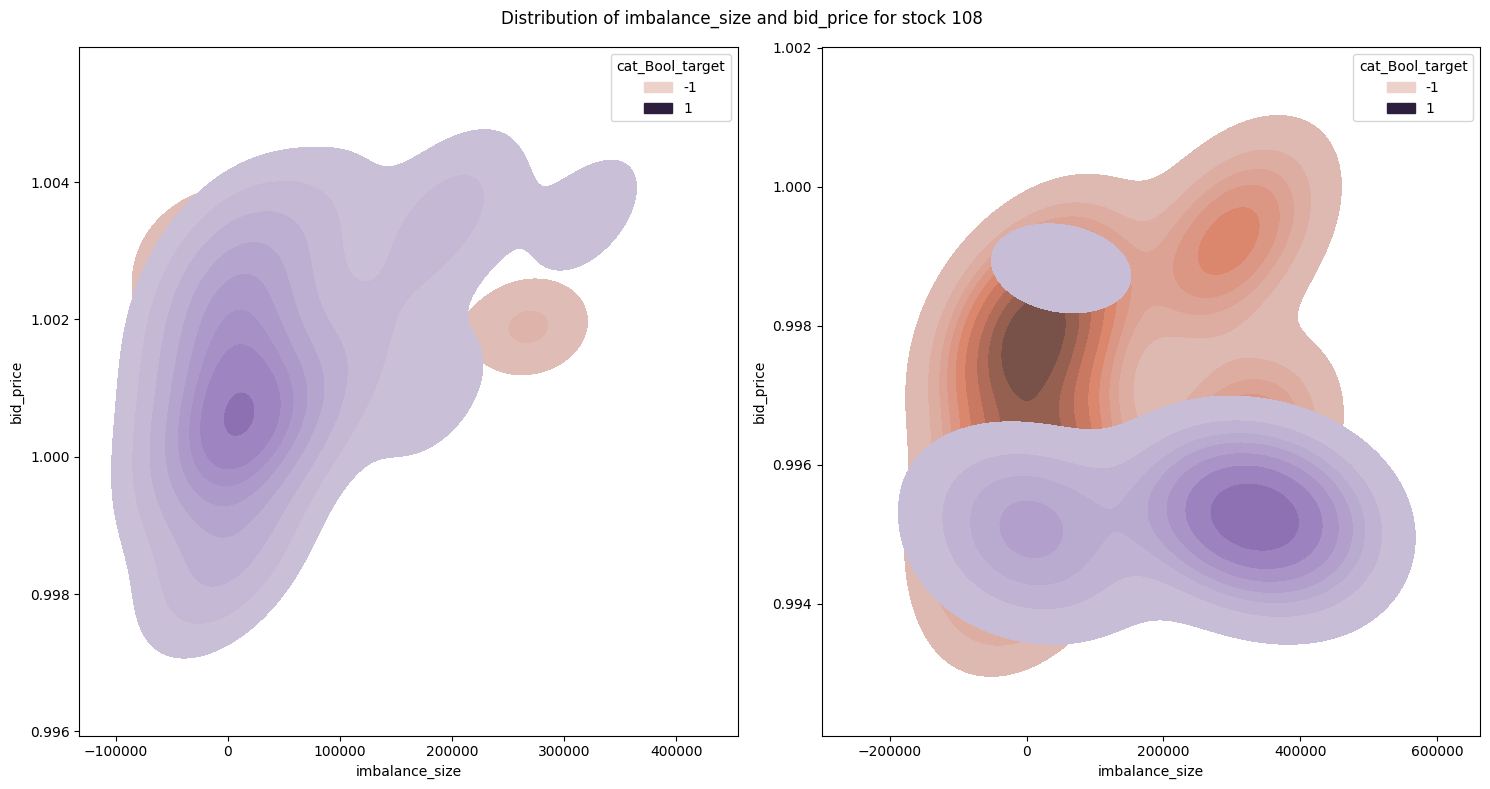

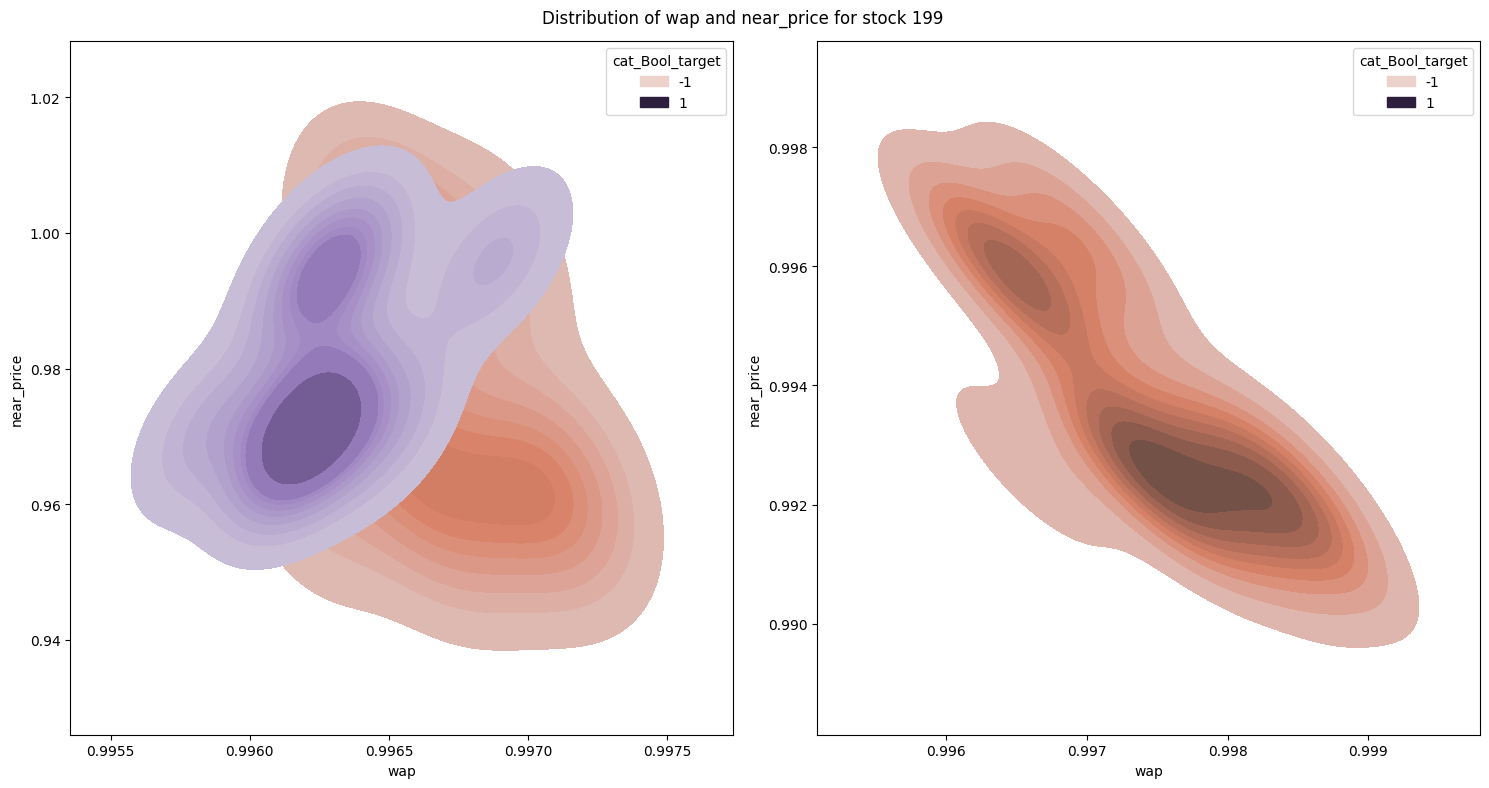

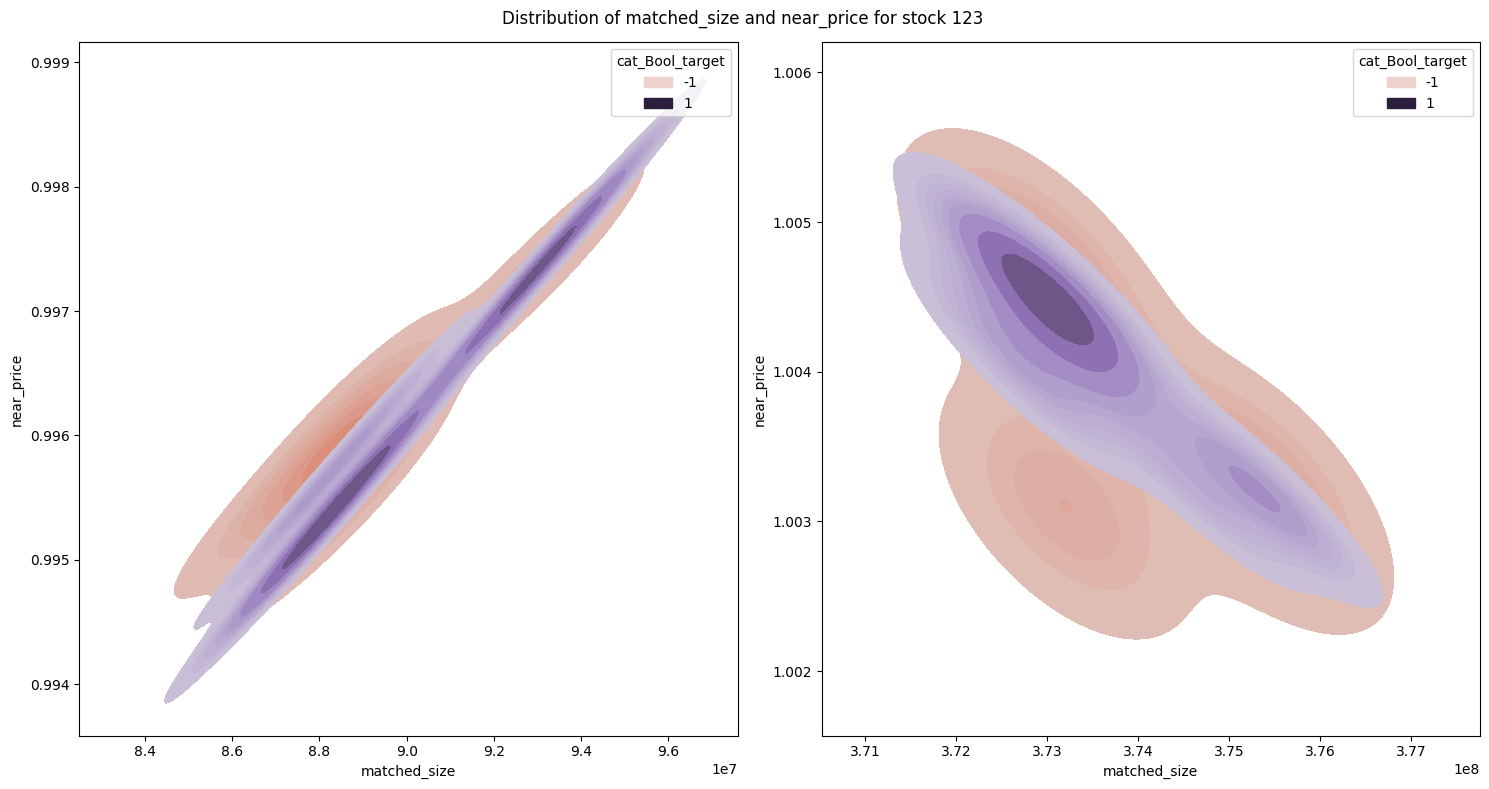

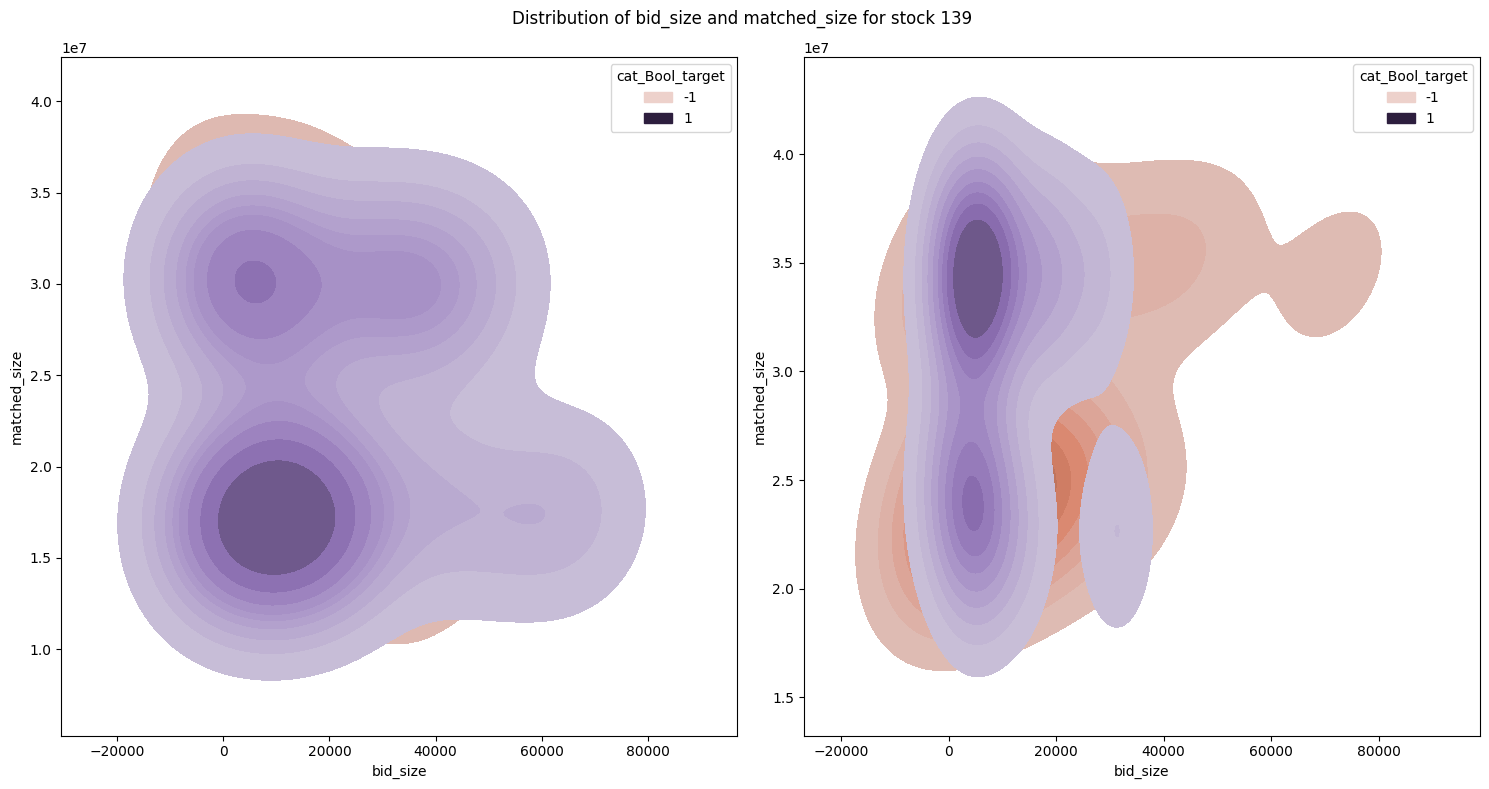

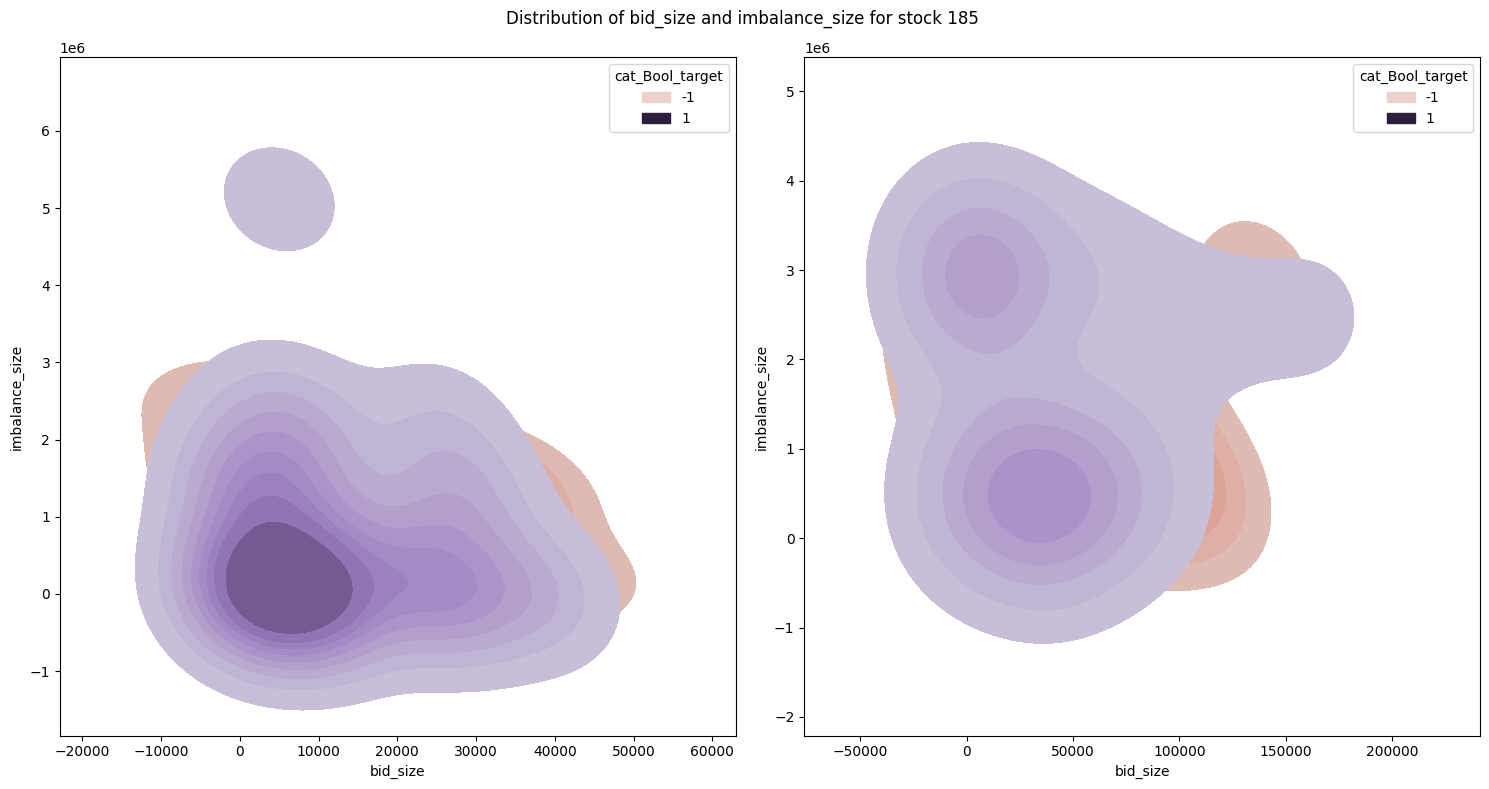

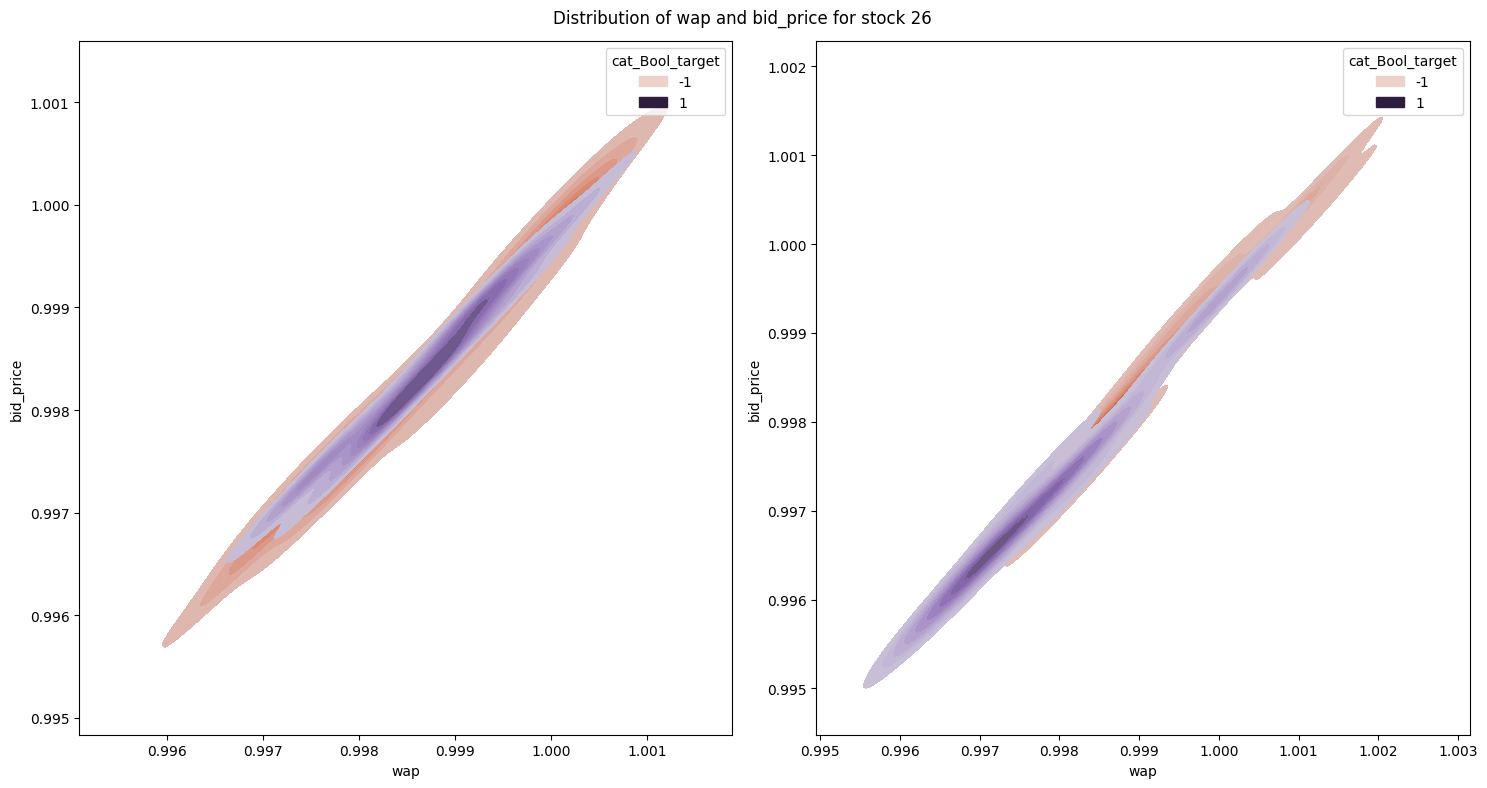

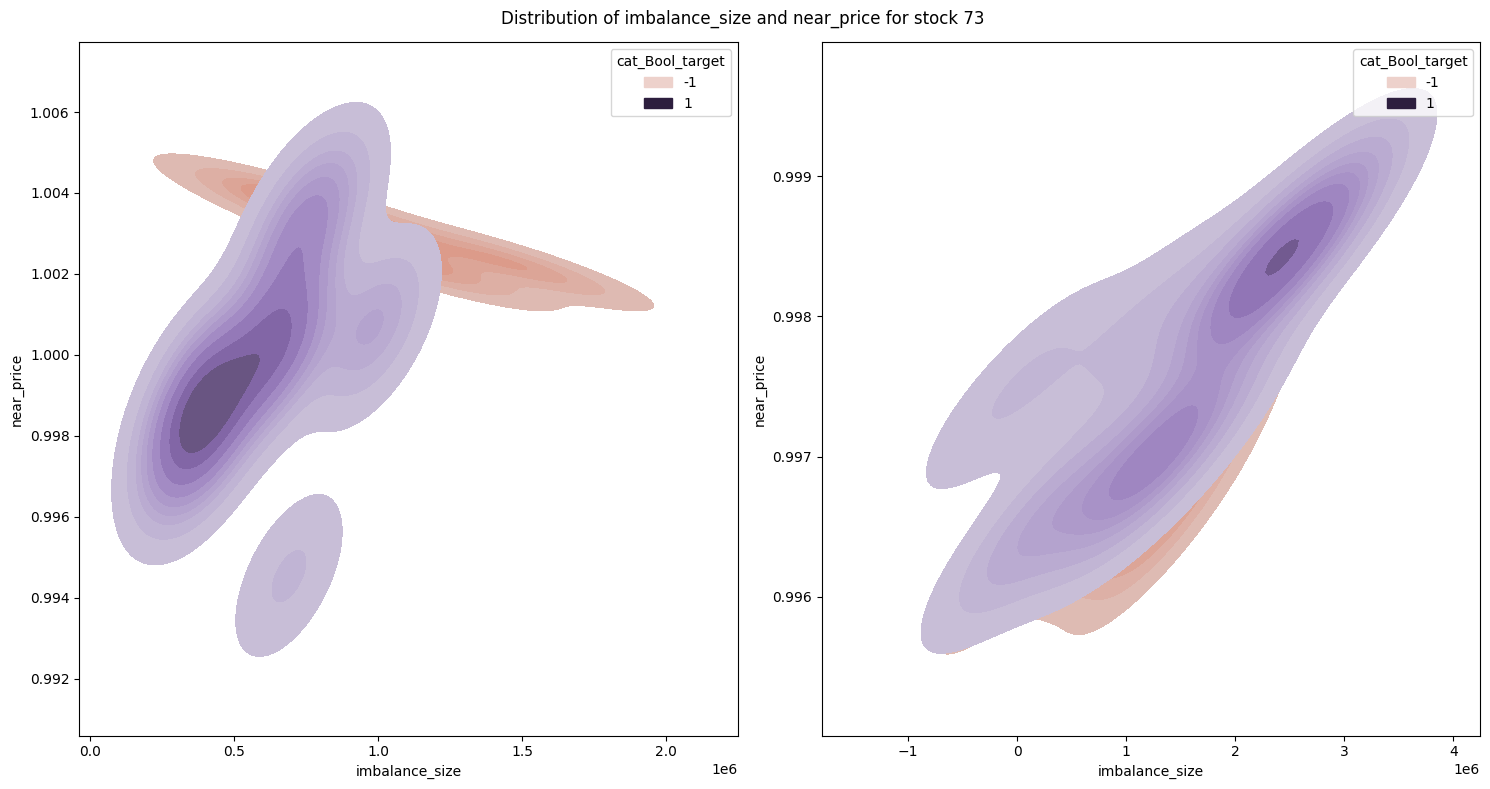

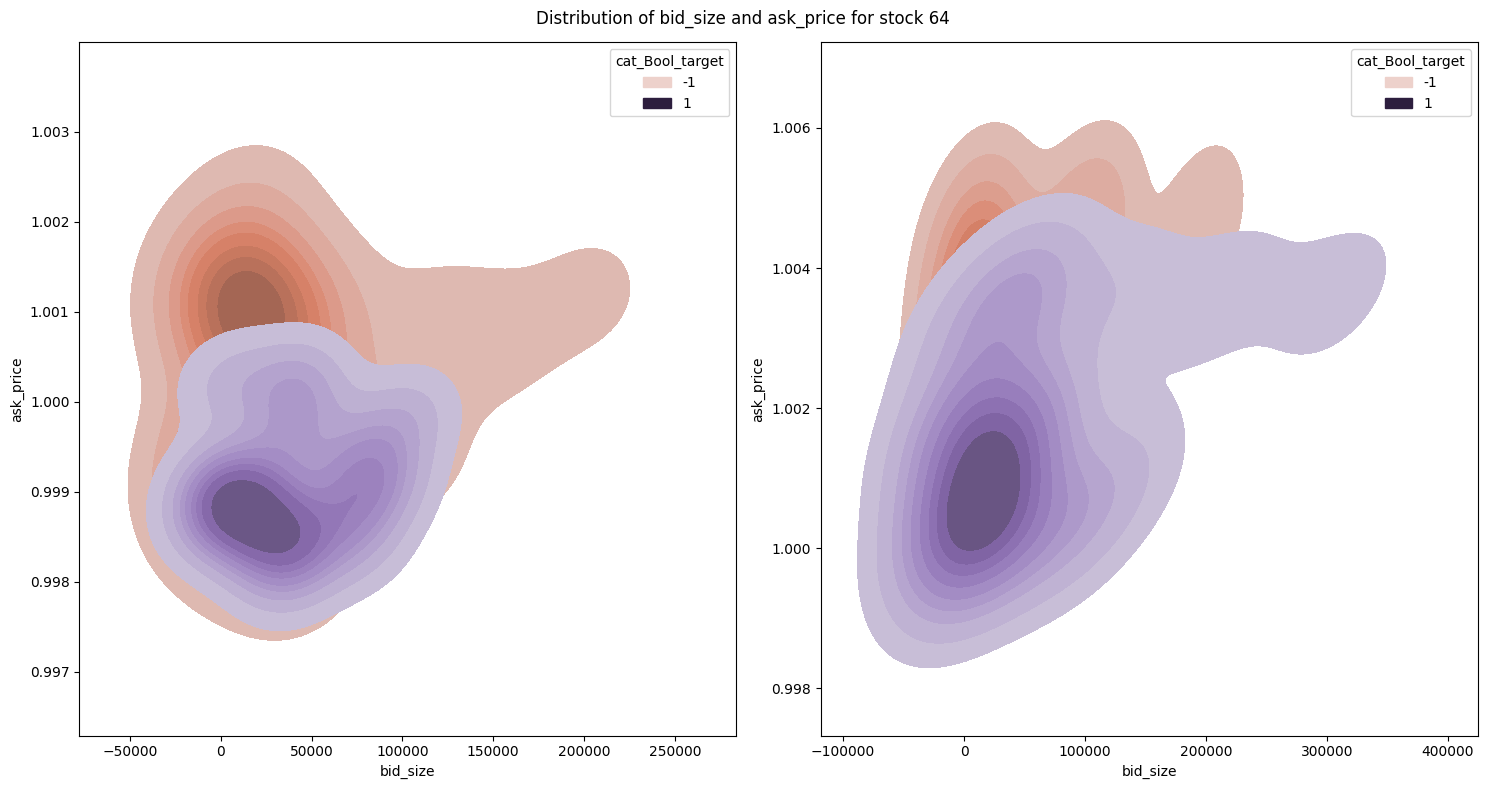

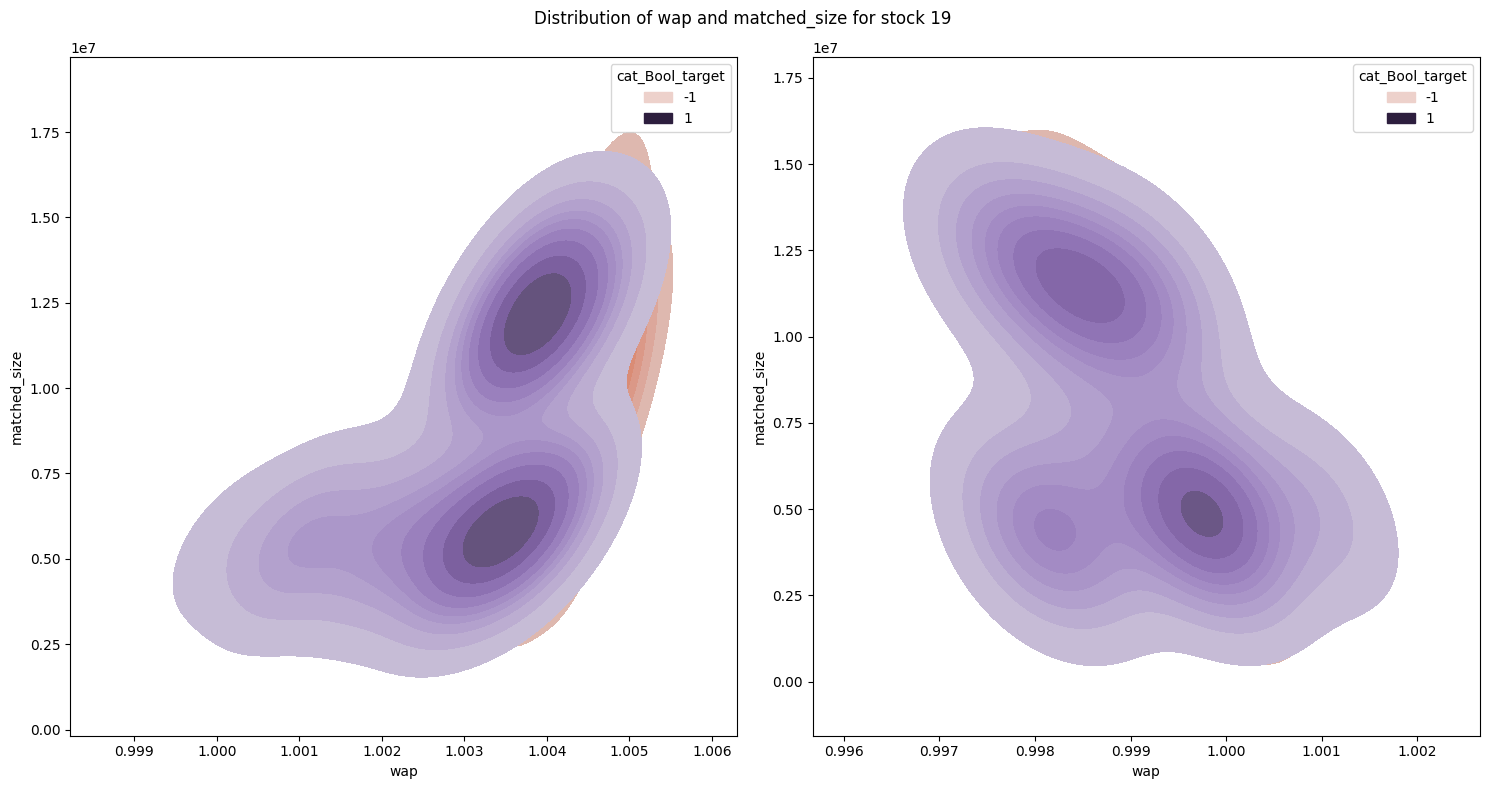

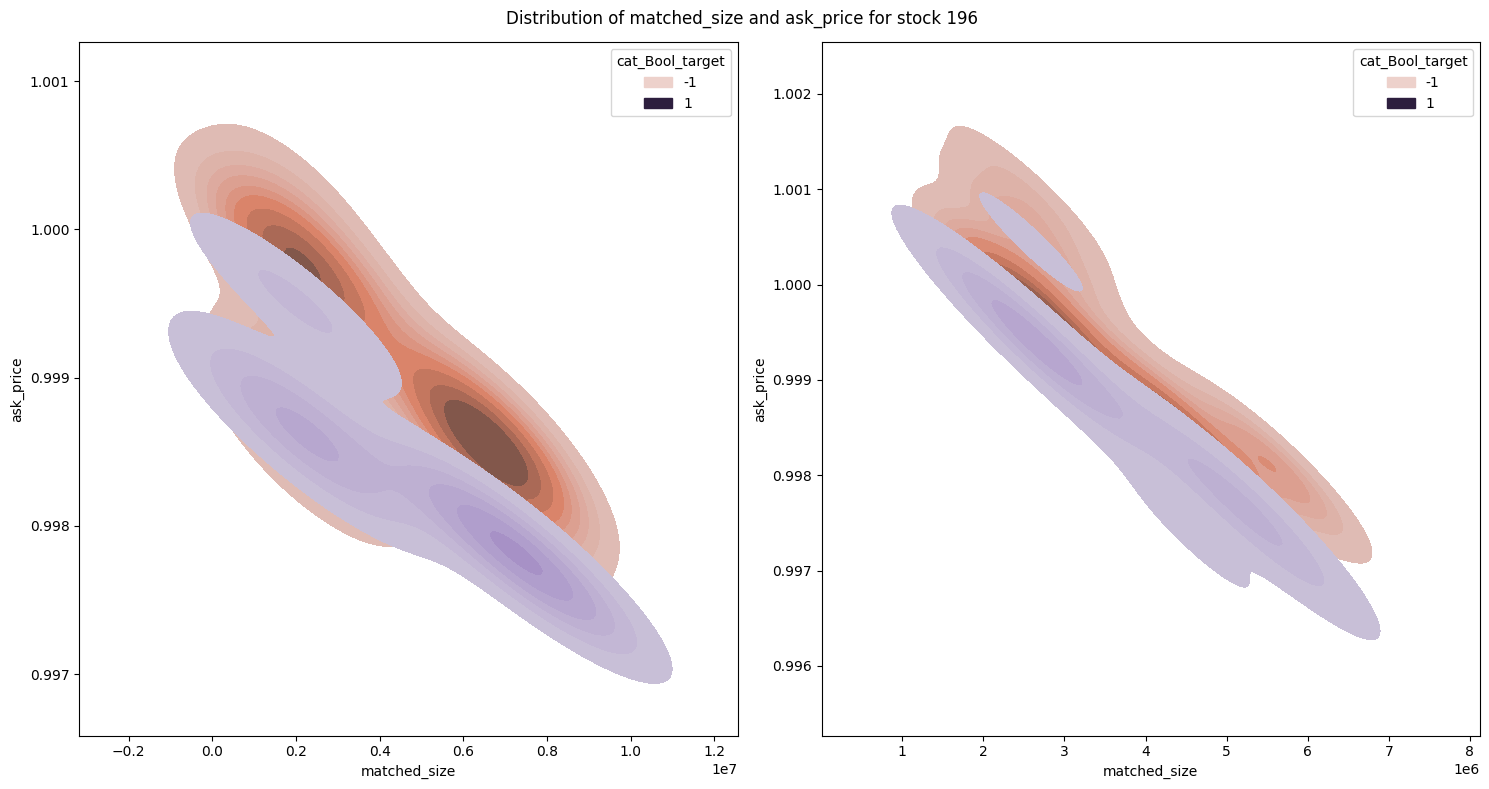

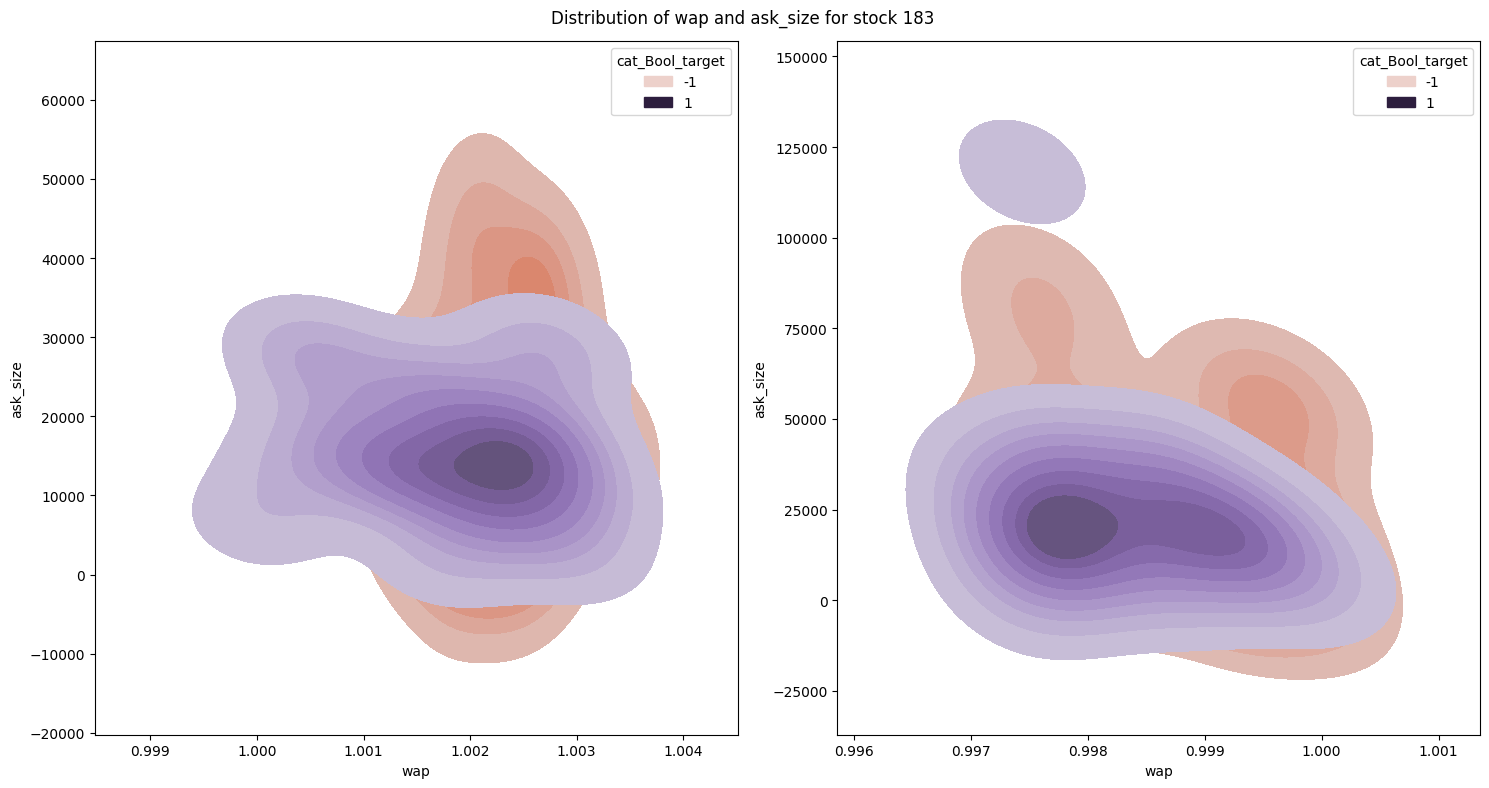

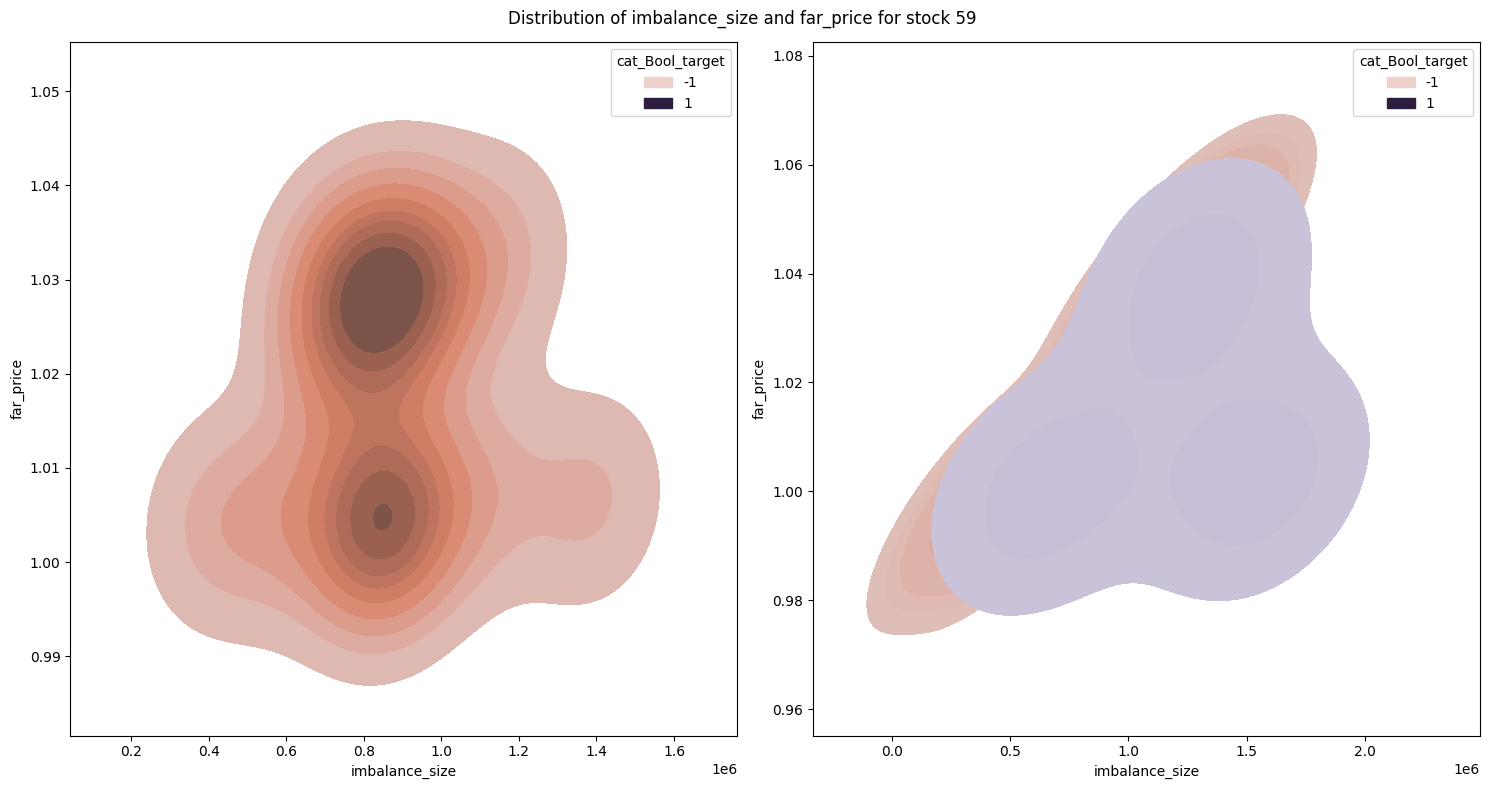

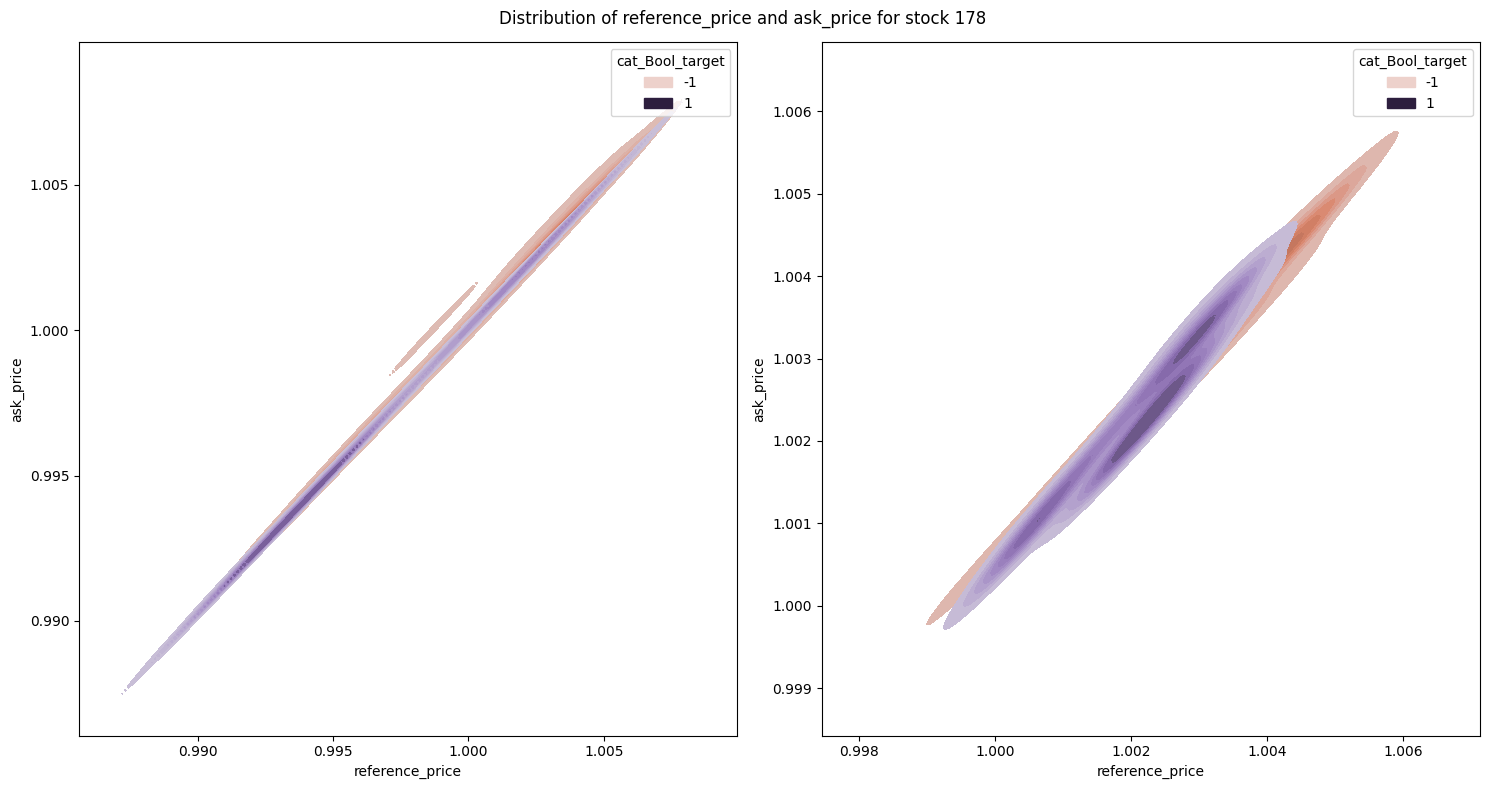

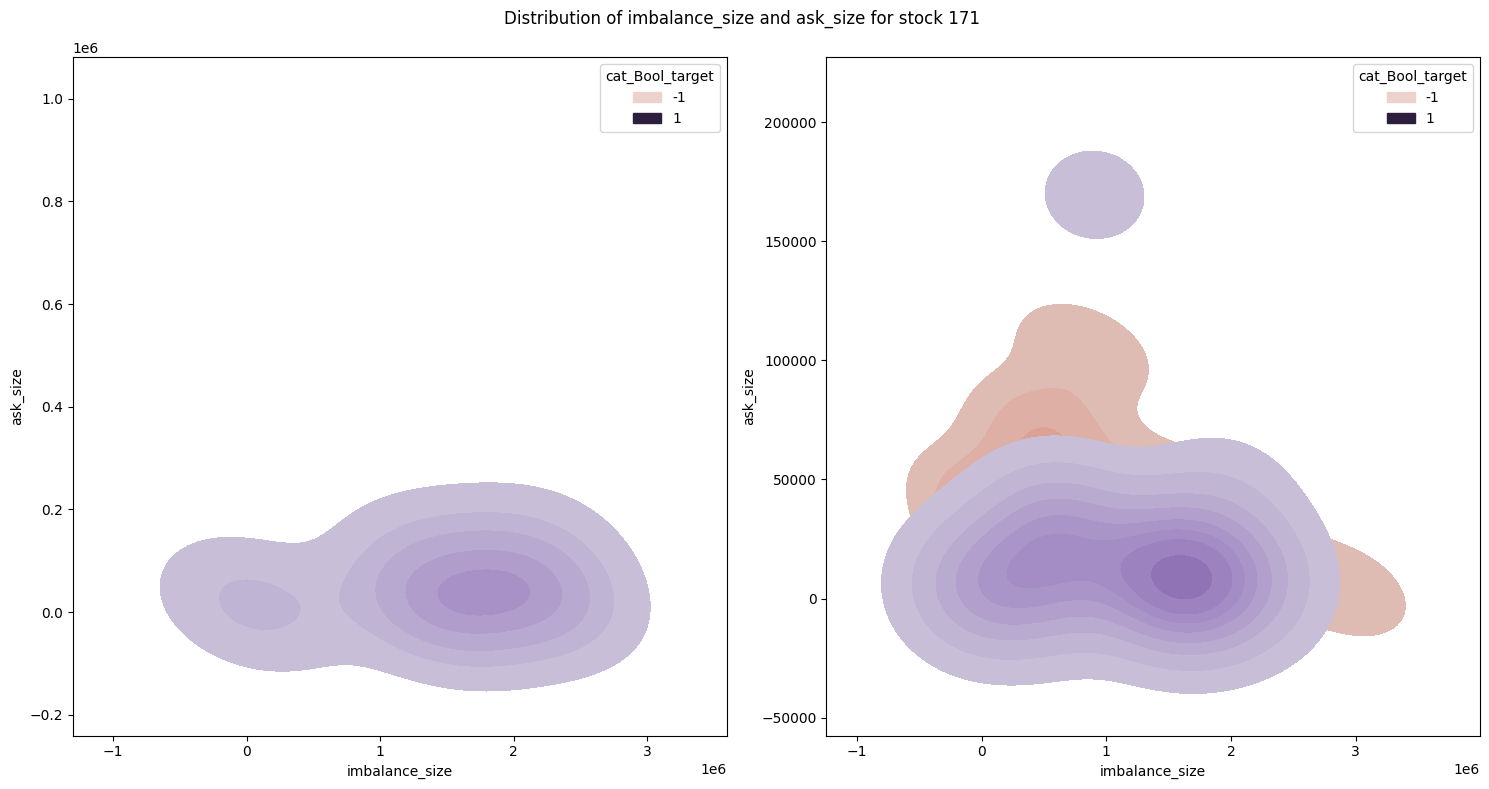

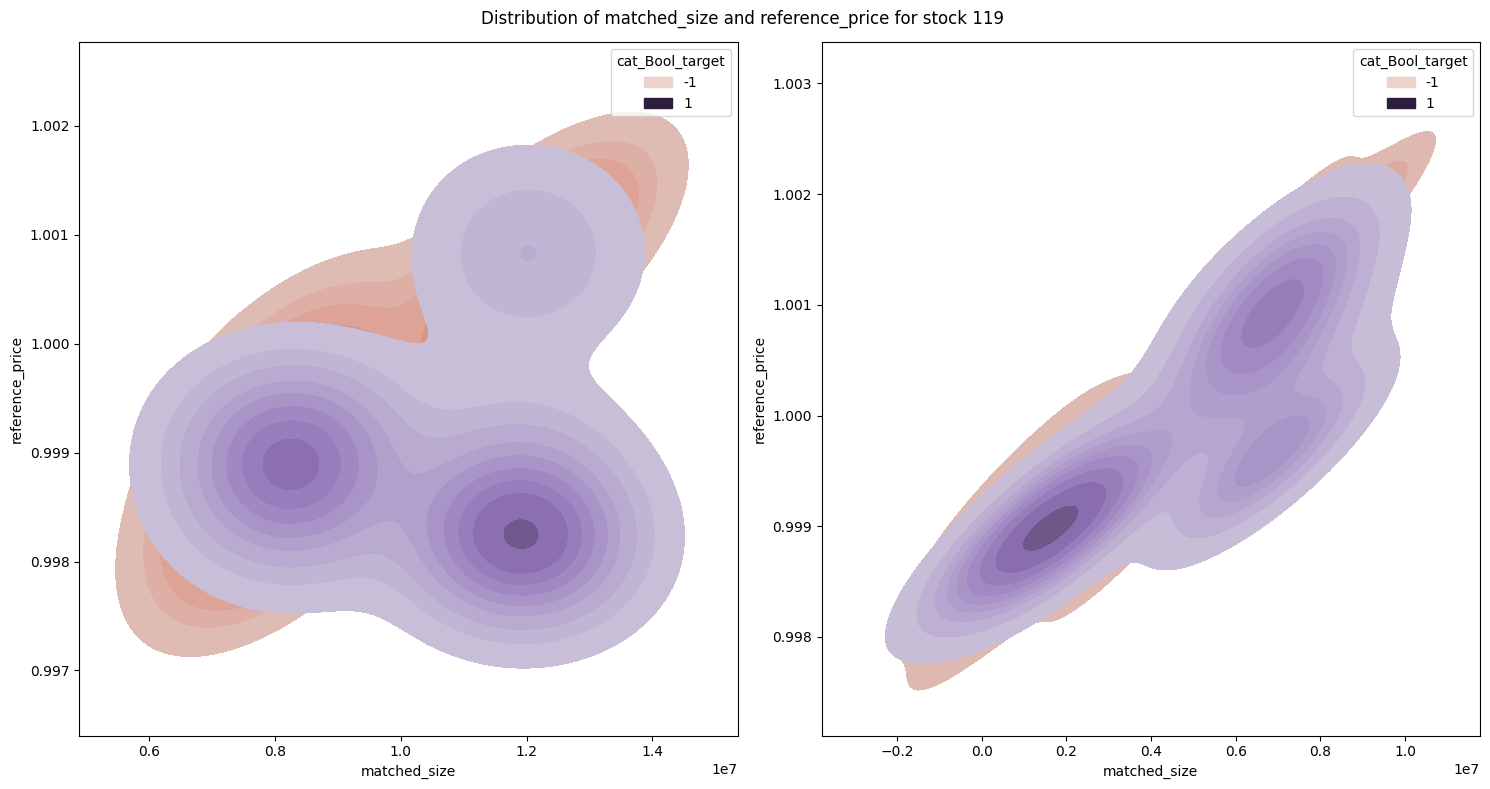

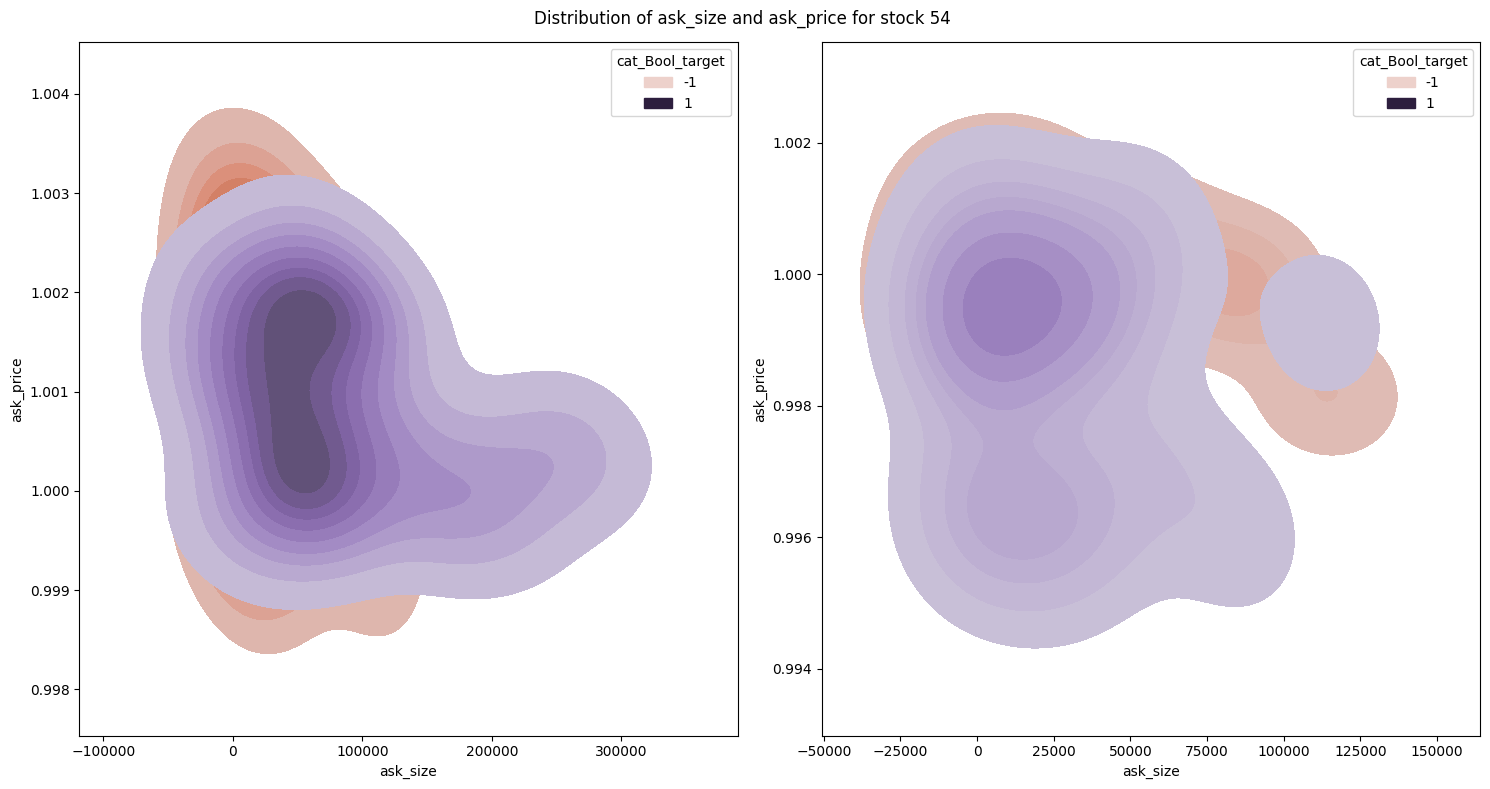

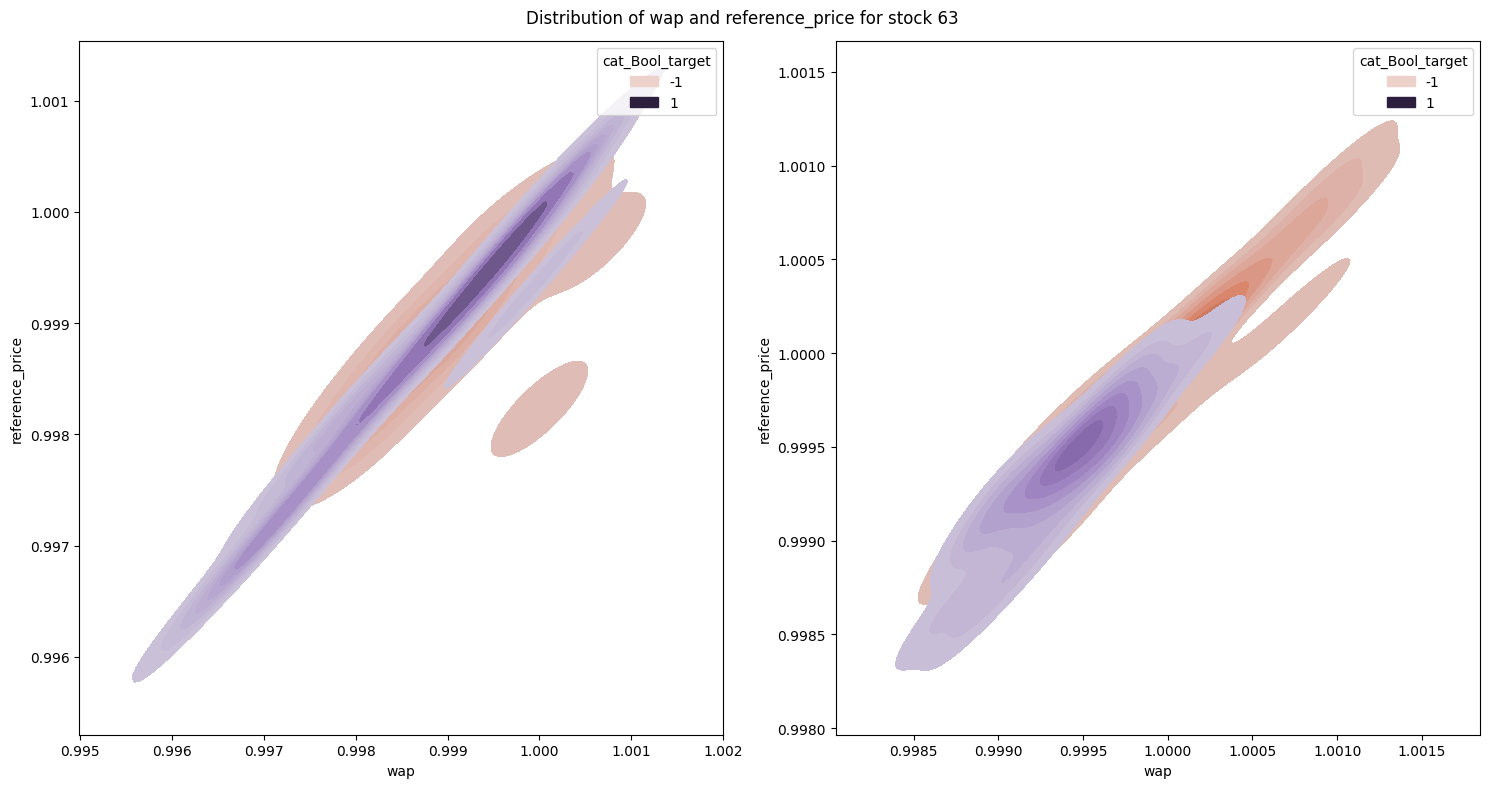

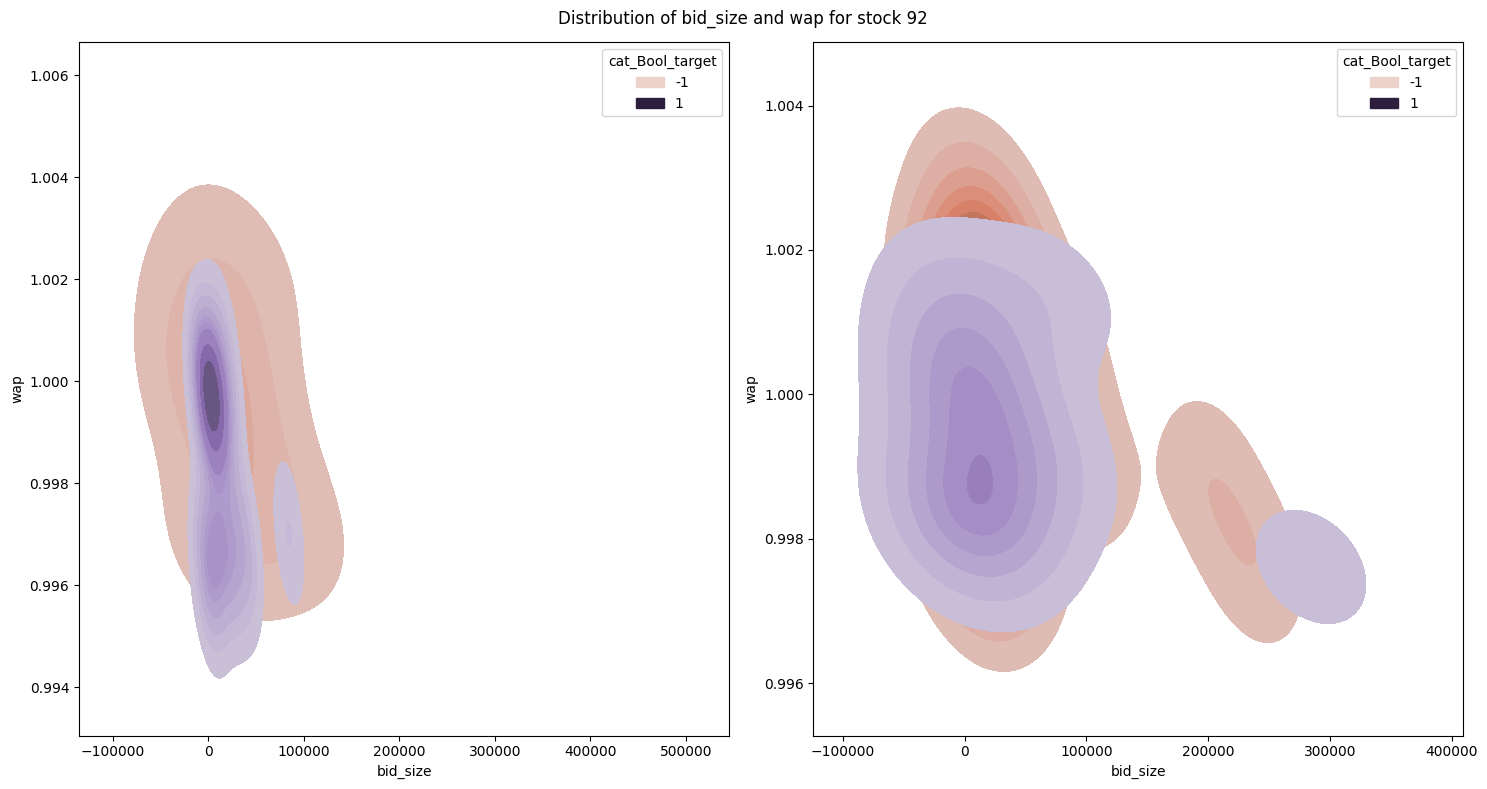

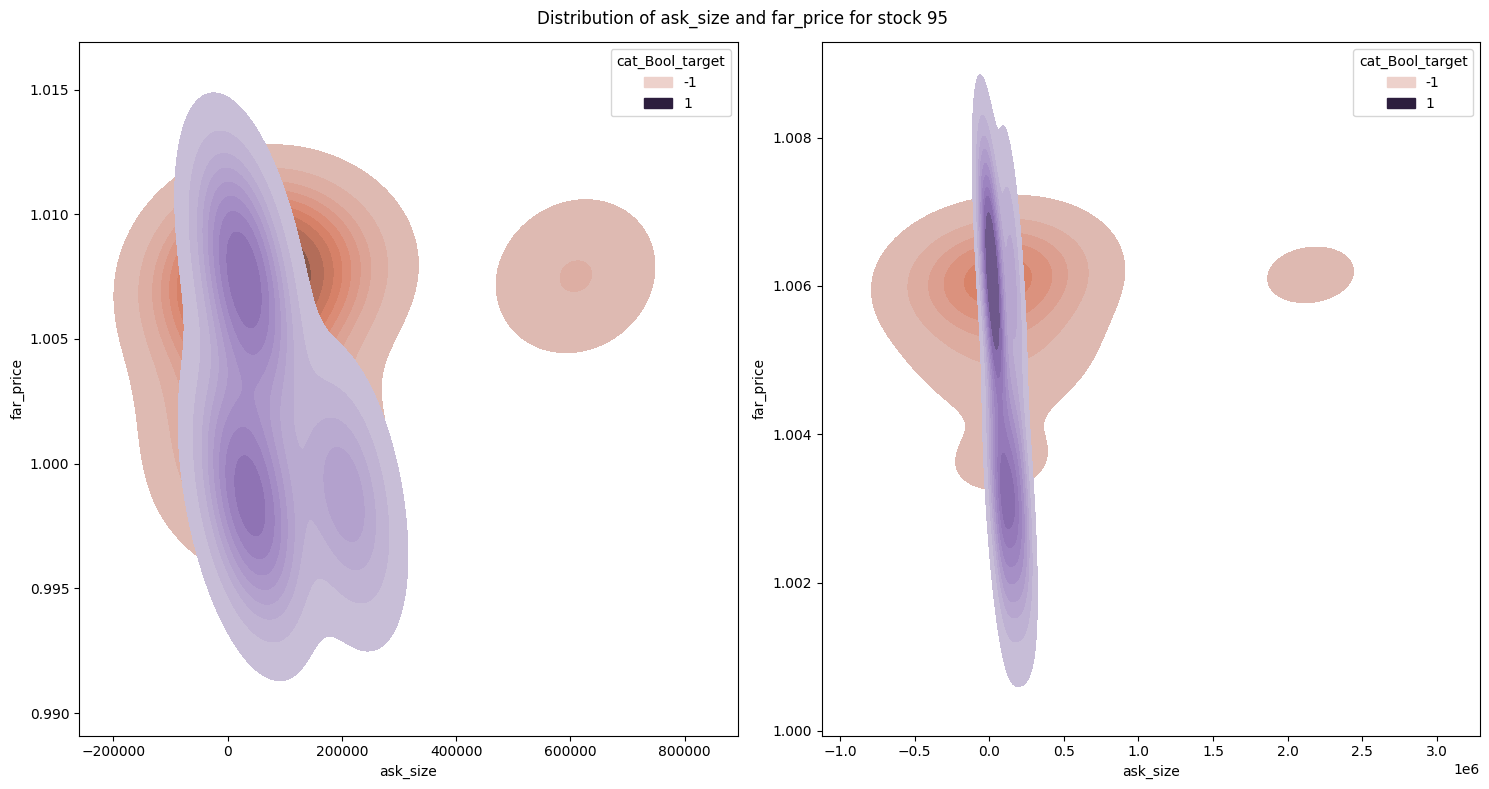

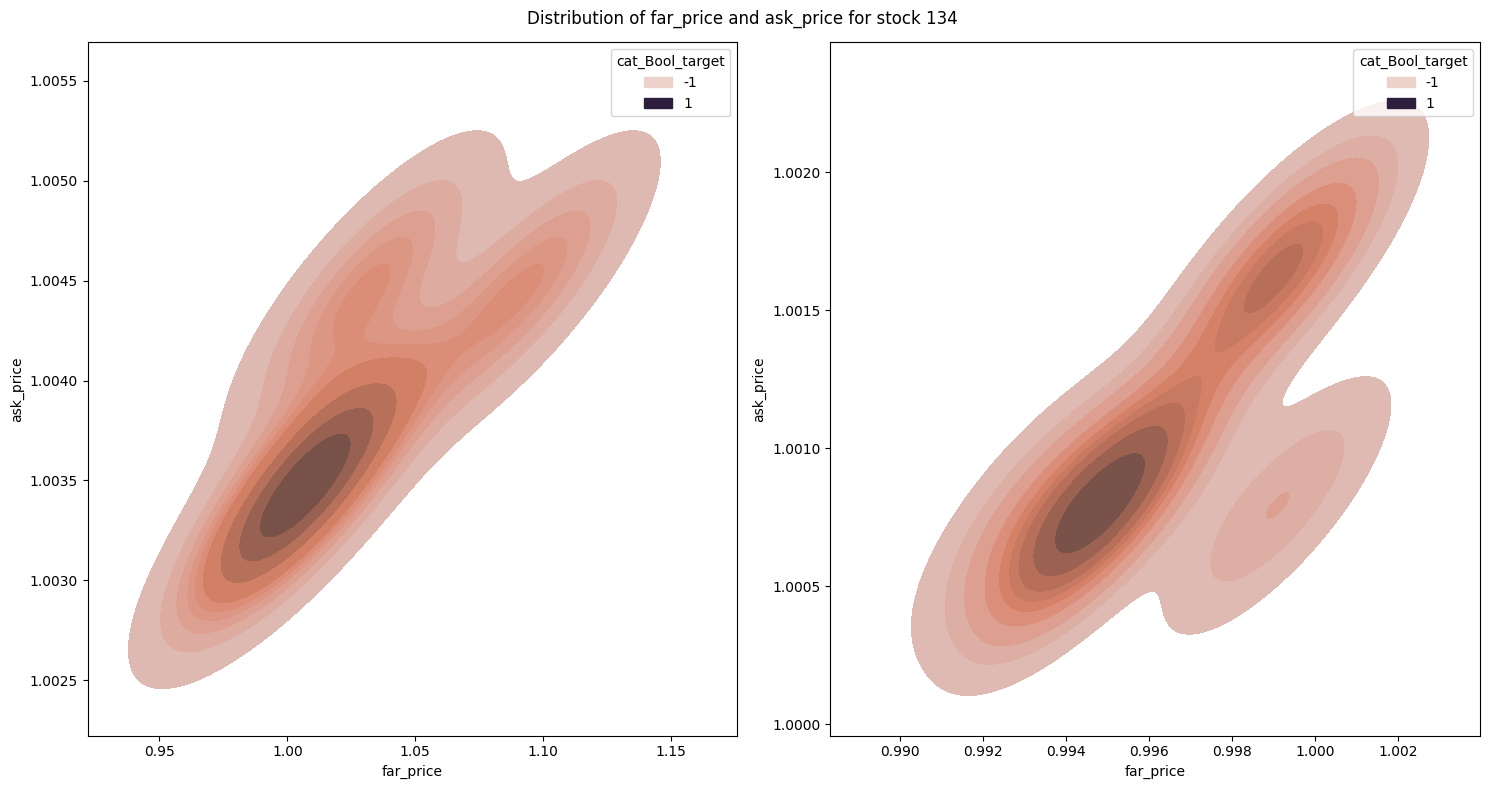

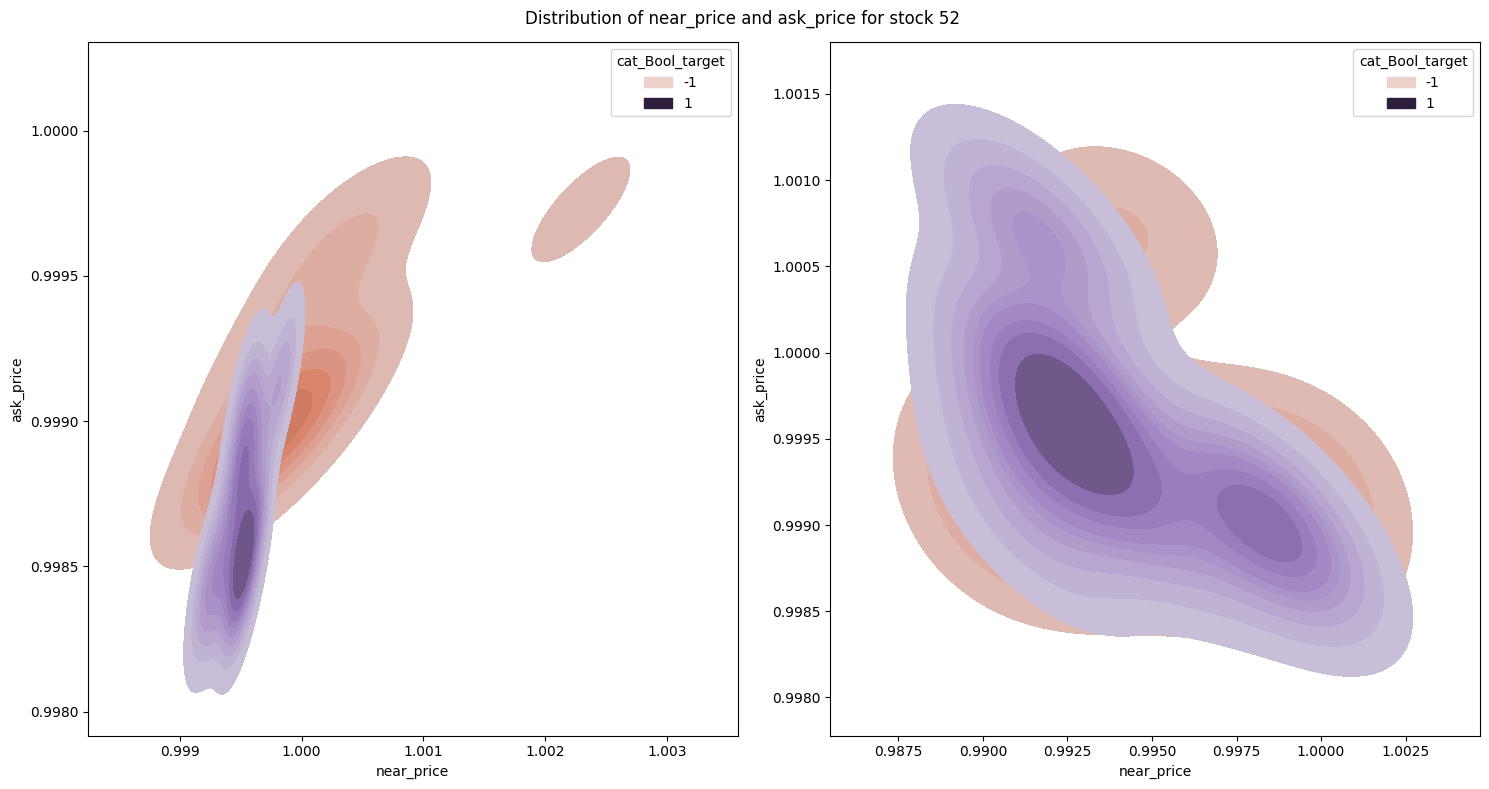

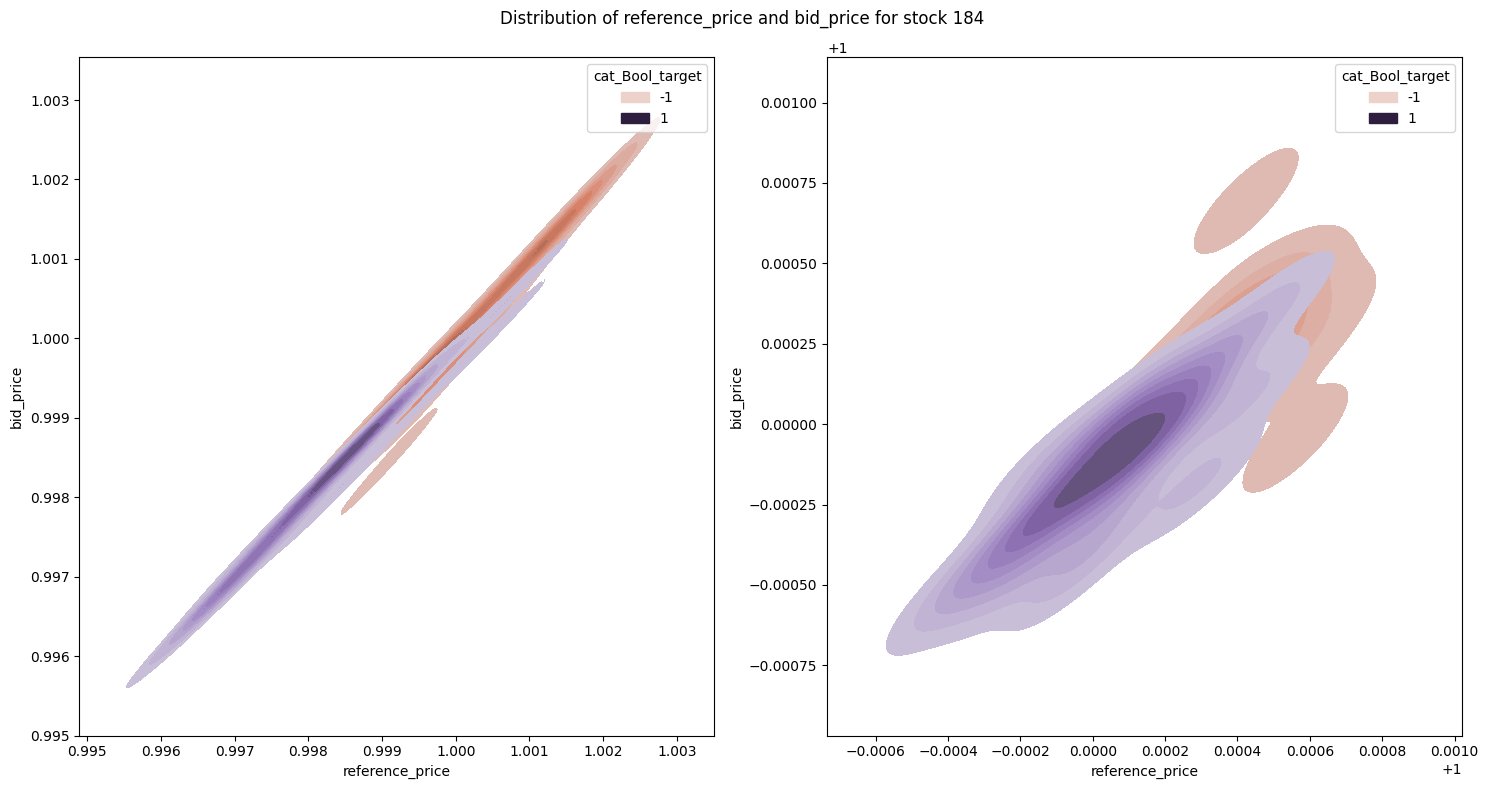

In [58]:
for frozenset_element in float_set:
    element_list = list(frozenset_element)
    random_stock = random.randint(0, 199)
    random_date_1 = random.randint(0 ,480)
    random_date_2 = random.randint(0 ,480)
    fig , axs = plt.subplots(1,2, figsize =(15,8))
    sns.kdeplot(
    data= df.query("stock_id ==@random_stock and date_id ==@random_date_1"), ax = axs[0],x= element_list[0] , y= element_list[1], hue='cat_Bool_target', fill=True,
)
    sns.kdeplot(
        data= df.query("stock_id ==@random_stock and date_id ==@random_date_2"), ax = axs[1],x= element_list[0] , y= element_list[1], hue='cat_Bool_target', fill=True,
    )
    plt.suptitle(f"Distribution of {element_list[0]} and {element_list[1]} for stock {random_stock} ")
    plt.tight_layout()
     
    plt.show()


    As can be seen from above KDE plots there is a visible boundry for negative and positive move of stocks price in 2d itself
    majorly the plots are overlapping but using more than two features we can get a better  disition boundry

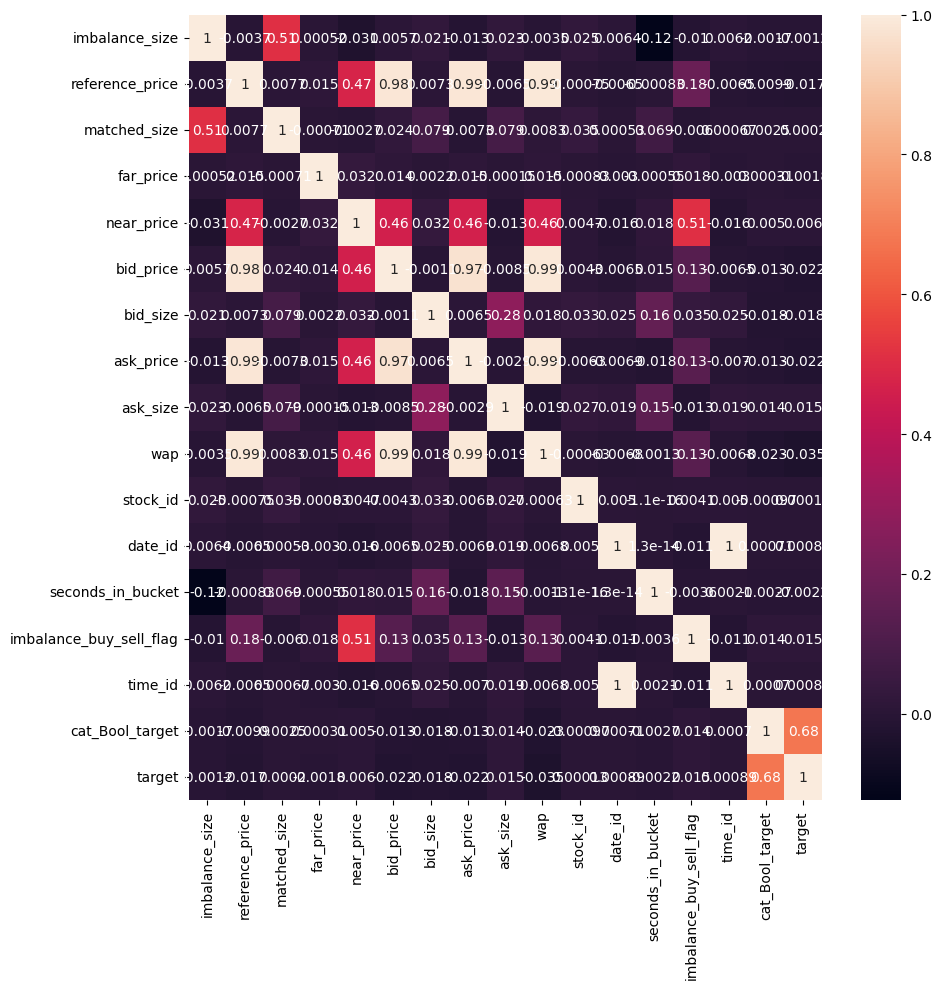

In [64]:
targets = ['cat_Bool_target','target']
fig, axs  = plt.subplots(1,1,figsize = (10,10))
sns.heatmap(df[float_cols + int_cols + targets].corr(),annot= True,ax = axs)
plt.tight_layout()
plt.show()

    As can be seen from corr matrix the target is very less correlated with other features and some of the highty related features are
    matched and imbalanced size
    near bit and ask price wap and reference price and imbalance buy sell flag
    imbalance and matched size
    bid and ask size
    near price imbalance_buy_sell _flag
    
    
    lets try some statistic methods as data contains so many nan we can try this by imputing it 

In [ ]:
columns_with_missing = df.columns[df.isnull().any()].tolist()
imputer = SimpleImputer(strategy='mean')
df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

In [79]:
n_features = 5
scorings ={
 "f_classif": f_classif,
 "chi2": chi2,
 "mutual_info_classif": mutual_info_classif
 }
score_types  = ['f_classif']
for scoring in score_types:
    selector = SelectKBest(
      scorings[scoring],
       k=n_features
    )
    X_selected = selector.fit_transform(df[float_cols+int_cols], df['target'])
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = df[float_cols + int_cols].columns[selected_feature_indices].tolist()
    print(f"Selected Feature Names {scoring}: ", selected_feature_names)

Selected Feature Names f_classif:  ['reference_price', 'far_price', 'bid_price', 'ask_price', 'wap']


    Let's look at te test and reaveled targets

In [28]:
df_test = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv")

In [3]:
df_test.head(20)

stock_id  date_id  seconds_in_bucket  imbalance_size  \
0          0      478                  0      3753451.43   
1          1      478                  0       985977.11   
2          2      478                  0       599128.74   
3          3      478                  0      2872317.54   
4          4      478                  0       740059.14   
5          5      478                  0      1150507.59   
6          6      478                  0        57213.11   
7          7      478                  0     14786077.01   
8          8      478                  0     26157362.75   
9          9      478                  0       426671.05   
10        10      478                  0      3011107.76   
11        11      478                  0      1382738.63   
12        12      478                  0      3271947.15   
13        13      478                  0     10249200.57   
14        14      478                  0     14878510.86   
15        15      478                  0     11813410.50   
16        16      478                  0      1475084.78   
17        17      478                  0     33998319.73   
18        18      478                  0      2415626.44   
19        19      478                  0      2621770.70   

    imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        -1         0.999875   11548975.43        NaN   
1                        -1         1.000245    3850033.97        NaN   
2                         1         1.000584    4359198.25        NaN   
3                        -1         0.999802   27129551.64        NaN   
4                        -1         0.999886    8880890.78        NaN   
5                        -1         0.999867    1580452.21        NaN   
6                         1         1.000361    3424296.94        NaN   
7                         1         0.998998   54031419.37        NaN   
8                        -1         0.999809   24384072.48        NaN   
9                        -1         1.000084    4467248.15        NaN   
10                       -1         0.999943    5424269.27        NaN   
11                        1         0.998150    9375847.37        NaN   
12                       -1         0.999892   20873154.67        NaN   
13                        1         0.999351   13815916.25        NaN   
14                       -1         0.999890   37335745.03        NaN   
15                        1         0.999731   10532083.22        NaN   
16                       -1         1.000139    3292589.67        NaN   
17                        1         1.000369   24586538.61        NaN   
18                       -1         1.000643    1956035.22        NaN   
19                       -1         1.000898    2488544.43        NaN   

    near_price  bid_price  bid_size  ask_price   ask_size  wap  time_id  \
0          NaN   0.999875  22940.00   1.000050    9177.60  1.0    26290   
1          NaN   0.999940   1967.90   1.000601   19692.00  1.0    26290   
2          NaN   0.999918   4488.22   1.000636   34955.12  1.0    26290   
3          NaN   0.999705  16082.04   1.000189   10314.00  1.0    26290   
4          NaN   0.999720  19012.35   1.000107    7245.60  1.0    26290   
5          NaN   0.999722  10312.50   1.000449   16649.60  1.0    26290   
6          NaN   0.999765   5535.45   1.000361    8492.75  1.0    26290   
7          NaN   0.998686  79933.75   1.000263   16012.00  1.0    26290   
8          NaN   0.998885  10638.52   1.000279    2663.34  1.0    26290   
9          NaN   0.999952    755.00   1.000482    7554.00  1.0    26290   
10         NaN   0.999943   1988.40   1.000144    4972.00  1.0    26290   
11         NaN   0.998840   3256.20   1.000773    2175.00  1.0    26290   
12         NaN   0.999756  45037.08   1.000118   21864.15  1.0    26290   
13         NaN   0.999351   6550.20   1.000541    5465.00  1.0    26290   
14         NaN   0.999311  52748.37   1.000695   53306.00  1.0    26290   
15       

In [4]:
revealed_targets = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv")

In [5]:
revealed_targets.head(20)

stock_id  date_id  seconds_in_bucket  time_id  revealed_target  \
0        0.0      478                  0    26290        -2.310276   
1        1.0      478                  0    26290       -12.850165   
2        2.0      478                  0    26290        -0.439882   
3        3.0      478                  0    26290         7.259846   
4        4.0      478                  0    26290         4.780292   
5        5.0      478                  0    26290       -12.639761   
6        6.0      478                  0    26290         5.279779   
7        7.0      478                  0    26290         9.310246   
8        8.0      478                  0    26290        -1.649857   
9        9.0      478                  0    26290        -4.289746   
10      10.0      478                  0    26290        -7.619858   
11      11.0      478                  0    26290       -24.719833   
12      12.0      478                  0    26290        12.630224   
13      13.0      478                  0    26290        -4.469752   
14      14.0      478                  0    26290         7.209778   
15      15.0      478                  0    26290         5.110502   
16      16.0      478                  0    26290        -9.570122   
17      17.0      478                  0    26290        11.440516   
18      18.0      478                  0    26290         4.270077   
19      19.0      478                  0    26290        -5.409718   

    revealed_date_id  revealed_time_id  
0              477.0           26235.0  
1              477.0           26235.0  
2              477.0           26235.0  
3              477.0           26235.0  
4              477.0           26235.0  
5              477.0           26235.0  
6              477.0           26235.0  
7              477.0           26235.0  
8              477.0           26235.0  
9              477.0           26235.0  
10             477.0           26235.0  
11             477.0           26235.0  
12             477.0           26235.0  
13             477.0           26235.0  
14             477.0           26235.0  
15             477.0           26235.0  
16             477.0           26235.0  
17             477.0           26235.0  
18             477.0           26235.0  
19             477.0           26235.0

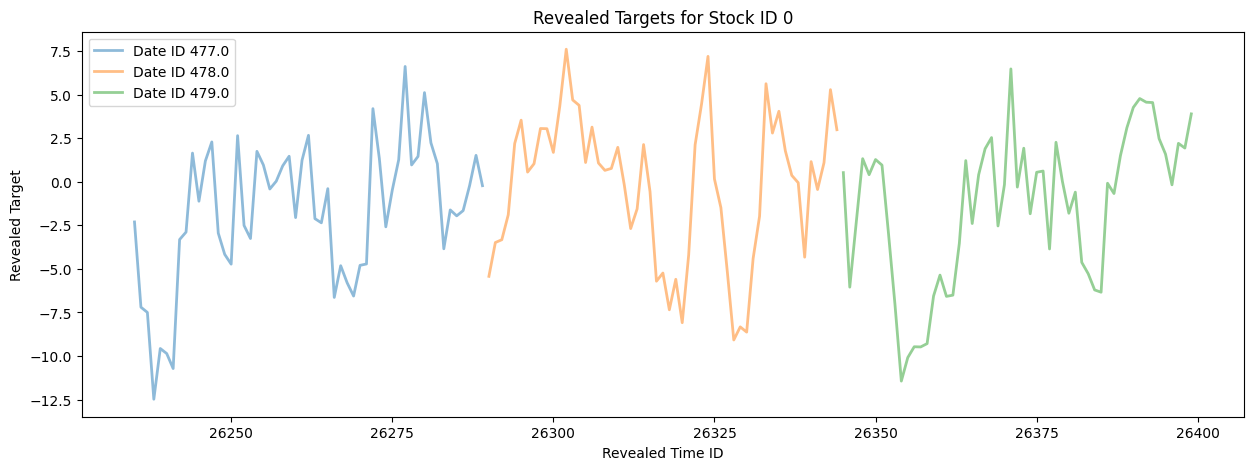

In [6]:
 
fig, axs = plt.subplots(figsize=(15, 5)) 
filtered_data = revealed_targets.query('stock_id == 0') 
unique_date_ids = filtered_data['revealed_date_id'].unique() 
for date_id in unique_date_ids:
    data_by_date = filtered_data[filtered_data['revealed_date_id'] == date_id]
    axs.plot(data_by_date['revealed_time_id'],
             data_by_date['revealed_target'],
             label=f'Date ID {date_id}',
             alpha=0.5,
             lw=2)
axs.legend() 
axs.set_xlabel('Revealed Time ID')
axs.set_ylabel('Revealed Target')
axs.set_title('Revealed Targets for Stock ID 0')

plt.show()


    so we can you previous targets as a feature also 

    variation  in the time ca consider a for a stock a date and a time id and vary seconds in bucket

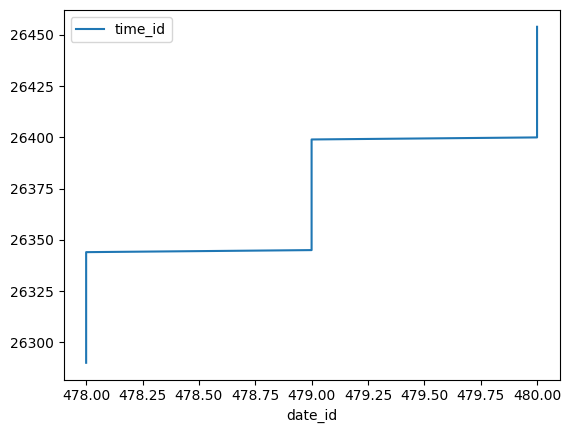

In [85]:
df_test.query('stock_id ==0').set_index('date_id')[['time_id']].plot()
plt.show()

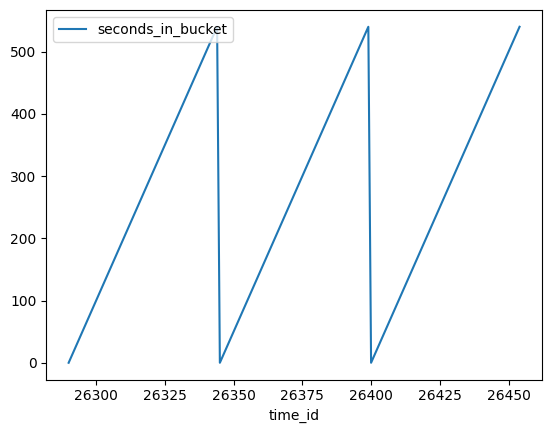

In [82]:
df_test.query('stock_id ==0').set_index('time_id')[['seconds_in_bucket']].plot()
plt.show()

In [7]:
sample_submission = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
sample_submission.head(10)

time_id   row_id  target
0    26290  478_0_0       0
1    26290  478_0_1       0
2    26290  478_0_2       0
3    26290  478_0_3       0
4    26290  478_0_4       0
5    26290  478_0_5       0
6    26290  478_0_6       0
7    26290  478_0_7       0
8    26290  478_0_8       0
9    26290  478_0_9       0

    so we have to predict for a time_id  and date stock time_in_bucket three of which are included in row_id_column as str in sequence  date_time_in_bucket_stock

    lets try to use the Rows provided at the time of inference through API and also The reaveled targets